In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import string
import requests
import sys
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
import urllib
import matplotlib.gridspec as gridspec


from bs4 import BeautifulSoup
import requests

import string

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

from sklearn.decomposition import PCA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import train_test_split


from sklearn import feature_extraction
from bs4 import BeautifulSoup, SoupStrainer
from urllib.request import urlopen
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.linear_model import Perceptron, RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.decomposition import RandomizedPCA
from scipy.cluster.hierarchy import ward, dendrogram
from scipy import optimize
from sklearn.manifold import MDS
from sklearn.utils.validation import check_random_state


<a id='top'></a>

## Table of content
- [0.0 Web Scraping](#WebSraper)
- [0.1 Load Data](#LoadData)
- [0.2 Introduction - General Statstics](#Intro)
- #### [1.0 Check Plays & Genre](#PlaysGenre)
- [1.1 PCA Analysis](#PCA_1)
- [1.2 LSA Analysis](#LSA_1)
- #### [2.0 Check Actors (Sex/Character)](#PlaysGenreActor)
- [2.1 PCA Analysis](#PCA_2)
- [2.2 LSA Analysis](#LSA_2)
- #### [3.0 Classification](#Classifier)
- [3.1 Genre Classification](#ClassifierGenre)
- [3.2 Play Classification](#ClassifierPlay)
- #### [4.0 Network Analysis](#Network Analysis)
- [4.1 Data Preparation and Analysis](#DataAnalysis)
- [4.2 Graph Analysis and Central Measures](#GraphAnalysis)
- #### [5.0 Clustering](#Clustering)
- [5.1 Initial Data Preparation and Analysis](#DataPreparation)
- [5.2 K-means clustering](#k-means)
- [5.3 Hierarchical Clustering Dendrogram](#Dendrogram)

<a id='WebSraper'></a>

# 0.0 Web Scraping

In [107]:
def converter(x):
    try:
        int(list(x.attrs.values())[0])
        return True
    except:
        return False

In [108]:
def speech(x):
    if list(x.attrs.values())[0][:6] == 'speech':
        return True
    else:
        return False

In [109]:
url = 'http://shakespeare.mit.edu/'
main_page=requests.get(url)
soup = BeautifulSoup(main_page.text, "html.parser")

In [110]:
my_dict = {}

genre_list = []
play_list = []
act_list = []
scene_list = []
scene_title = []
n_act_scenes = []
act_scene_text = []
names_list = []

found_speech = False

my_genre = soup.find_all("table")[1].find_all("h2")

for genre in range(len(my_genre)-1):
    
    curr_genre = my_genre[genre].contents[0].replace('\n', '')
    
    curr_play_list = soup.find_all("table")[1].find_all("tr")[1].find_all("td")[genre].find_all('a')
    num_of_plays = len(curr_play_list)
    
    for play in range(num_of_plays):
        curr_play = curr_play_list[play].contents[0].strip()
        curr_play_link = url + curr_play_list[play].attrs['href']
        
        play_page = requests.get(curr_play_link, timeout=3000)
        play_soup = BeautifulSoup(play_page.text, "html.parser")
        
        num_act_scenes = len(play_soup.find_all('a'))
                
        found_full = False   
        for act_scene in range(num_act_scenes):
            if not found_full:
                found_full = play_soup.find_all('a')[act_scene].attrs['href'] == 'full.html'
            else:
                link_act_scene = play_soup.find_all('a')[act_scene].attrs['href']

            
                scene_link = curr_play_link[:curr_play_link.index('index.html')] + link_act_scene
                act_scene_page = requests.get(scene_link, timeout=10000)
                act_scene_soup = BeautifulSoup(act_scene_page.text, "html.parser")
                n = len(act_scene_soup.find_all('a'))
                
                curr_speaker = 0
                curr_act_scene_text = []

                for text in range(n):
                    
                    my_text_i = act_scene_soup.find_all('a')[text]
                    
                    if speech(my_text_i):
                        found_speech = True
                        curr_act_scene_text = []
                        name = act_scene_soup.find_all('b')[curr_speaker].contents[0]
                        curr_speaker += 1             
                    
                    if converter(my_text_i):
                        curr_act_scene_text = curr_act_scene_text + act_scene_soup.find_all('a')[text].contents

                
                    if found_speech:
                        if (text == (n-1)):  
                            act_list.append(link_act_scene.split('.')[1])
                            scene_list.append(link_act_scene.split('.')[2])
                            scene_title.append(play_soup.find_all('a')[act_scene].contents[0])
                            genre_list.append(curr_genre)
                            play_list.append(curr_play)
                            n_act_scenes.append(num_act_scenes)
                            act_scene_text.append(curr_act_scene_text)
                            
                            names_list.append(name)
                        
                        elif speech(act_scene_soup.find_all('a')[text+1]):
                            act_list.append(link_act_scene.split('.')[1])
                            scene_list.append(link_act_scene.split('.')[2])
                            scene_title.append(play_soup.find_all('a')[act_scene].contents[0])
                            genre_list.append(curr_genre)
                            play_list.append(curr_play)
                            n_act_scenes.append(num_act_scenes)
                            act_scene_text.append(curr_act_scene_text)
                            
                            names_list.append(name)
           
                print(curr_play, link_act_scene.split('.')[1], link_act_scene.split('.')[2])
                       
my_dict = {'genre': genre_list,
            'play': play_list,
            'act_scenes': n_act_scenes,
            'act': act_list,
            'scene': scene_list,
            'scene_title': scene_title,
            'scene_text': act_scene_text,
            'actor_name': names_list}

All's Well That Ends Well 1 1
All's Well That Ends Well 1 2
All's Well That Ends Well 1 3
All's Well That Ends Well 2 1
All's Well That Ends Well 2 2
All's Well That Ends Well 2 3
All's Well That Ends Well 2 4
All's Well That Ends Well 2 5
All's Well That Ends Well 3 1
All's Well That Ends Well 3 2
All's Well That Ends Well 3 3
All's Well That Ends Well 3 4
All's Well That Ends Well 3 5
All's Well That Ends Well 3 6
All's Well That Ends Well 3 7
All's Well That Ends Well 4 1
All's Well That Ends Well 4 2
All's Well That Ends Well 4 3
All's Well That Ends Well 4 4
All's Well That Ends Well 4 5
All's Well That Ends Well 5 1
All's Well That Ends Well 5 2
All's Well That Ends Well 5 3
As You Like It 1 1
As You Like It 1 2
As You Like It 1 3
As You Like It 2 1
As You Like It 2 2
As You Like It 2 3
As You Like It 2 4
As You Like It 2 5
As You Like It 2 6
As You Like It 2 7
As You Like It 3 1
As You Like It 3 2
As You Like It 3 3
As You Like It 3 4
As You Like It 3 5
As You Like It 4 1
As You

Henry V 4 5
Henry V 4 6
Henry V 4 7
Henry V 4 8
Henry V 5 0
Henry V 5 1
Henry V 5 2
Henry VI, part 1 1 1
Henry VI, part 1 1 2
Henry VI, part 1 1 3
Henry VI, part 1 1 4
Henry VI, part 1 1 5
Henry VI, part 1 1 6
Henry VI, part 1 2 1
Henry VI, part 1 2 2
Henry VI, part 1 2 3
Henry VI, part 1 2 4
Henry VI, part 1 2 5
Henry VI, part 1 3 1
Henry VI, part 1 3 2
Henry VI, part 1 3 3
Henry VI, part 1 3 4
Henry VI, part 1 4 1
Henry VI, part 1 4 2
Henry VI, part 1 4 3
Henry VI, part 1 4 4
Henry VI, part 1 4 5
Henry VI, part 1 4 6
Henry VI, part 1 4 7
Henry VI, part 1 5 1
Henry VI, part 1 5 2
Henry VI, part 1 5 3
Henry VI, part 1 5 4
Henry VI, part 1 5 5
Henry VI, part 2 1 1
Henry VI, part 2 1 2
Henry VI, part 2 1 3
Henry VI, part 2 1 4
Henry VI, part 2 2 1
Henry VI, part 2 2 2
Henry VI, part 2 2 3
Henry VI, part 2 2 4
Henry VI, part 2 3 1
Henry VI, part 2 3 2
Henry VI, part 2 3 3
Henry VI, part 2 4 1
Henry VI, part 2 4 2
Henry VI, part 2 4 3
Henry VI, part 2 4 4
Henry VI, part 2 4 5
Henry VI, par

In [111]:
sp = pd.DataFrame(my_dict)

In [112]:
ch = ['<br/>', '[', ']', ':', ',', '\'', '\\n', '"', '  \\t']

In [113]:
sonnet_link = 'http://shakespeare.mit.edu/Poetry/sonnets.html'
p1 = requests.get(sonnet_link)
p_soup_1 = BeautifulSoup(p1.text, "html.parser")
n = len(p_soup_1.find_all('a'))

play_name = []
sonnet_name = []
sonnet_text = []

for i in range(1, n):
    link = p_soup_1.find_all('a')[i].attrs['href']
    full_link = sonnet_link[:sonnet_link.index('sonnets.html')] + link
    sonnet = requests.get(full_link, timeout=3000)
    s_soup = BeautifulSoup(sonnet.text, "html.parser") 
    
    sonnet_name.append(s_soup.find_all('h1')[0].contents[0])
    s = str(s_soup.find_all('blockquote')[0].contents)
   
    for c in ch:
        s = s.replace(c, '')
    
    sonnet_text.append(s)

    
    # print(s_soup.find_all('h1')[0].contents[0])
play_name = ['The Sonnets']*len(sonnet_text)

sonnet_1 = pd.DataFrame({'play': play_name,
                        'scene_title': sonnet_name,
                        'genre': ['Poetry']*len(play_name),
                        'scene_text': sonnet_text})

In [114]:
sonnet_text = []

sonnet_link = 'http://shakespeare.mit.edu/Poetry/LoversComplaint.html'
p = requests.get(sonnet_link)
p_soup = BeautifulSoup(p.text, "html.parser")

n = len(p_soup.find_all('blockquote'))

for i in range(0, n): 
    s = str(p_soup.find_all('blockquote')[i].contents)
   
    for c in ch:
        s = s.replace(c, '')
    
    sonnet_text.append(s)

    
stext = [sonnet_text[0]]    

for i in range(1, len(sonnet_text)):
    stext = [stext[0] + ' ' + sonnet_text[i]]    
    
play_name = ['A Lovers Complaint']

sonnet_2 = pd.DataFrame({'play': play_name,
                        'genre': ['Poetry'],
                        'scene_text': stext})

In [115]:
sonnet_text = []

sonnet_link = 'http://shakespeare.mit.edu/Poetry/RapeOfLucrece.html'
p = requests.get(sonnet_link)
p_soup = BeautifulSoup(p.text, "html.parser")

n = len(p_soup.find_all('blockquote'))

for i in range(0, n): 
    s = str(p_soup.find_all('blockquote')[i].contents)
   
    for c in ch:
        s = s.replace(c, '')
    
    sonnet_text.append(s)

    
stext = [sonnet_text[0]]    

for i in range(1, len(sonnet_text)):
    stext = [stext[0] + ' ' + sonnet_text[i]]    
    
play_name = ['The Rape of Lucrece']

sonnet_3 = pd.DataFrame({'play': play_name,
                        'genre': ['Poetry'],
                        'scene_text': stext})

In [116]:
sonnet_text = []

sonnet_link = 'http://shakespeare.mit.edu/Poetry/VenusAndAdonis.html'
p = requests.get(sonnet_link)
p_soup = BeautifulSoup(p.text, "html.parser")

n = len(p_soup.find_all('blockquote'))

for i in range(0, n): 
    s = str(p_soup.find_all('blockquote')[i].contents)
   
    for c in ch:
        s = s.replace(c, '')
    
    sonnet_text.append(s)

    
stext = [sonnet_text[0]]    

for i in range(1, len(sonnet_text)):
    stext = [stext[0] + ' ' + sonnet_text[i]]    
    
play_name = ['Venus and Adonis']

sonnet_4 = pd.DataFrame({'play': play_name,
                        'genre': ['Poetry'],
                        'scene_text': stext})

In [117]:
sp_full = sp.append([sonnet_1, sonnet_2, sonnet_3, sonnet_4])

In [118]:
sp_full.to_csv('shakespeare_4_full.csv')

<a id='LoadData'></a>

# 0.1 Load Data

In [119]:
sp = pd.read_csv('shakespeare_4_full.csv')
sp = sp.iloc[:,1:]
sp.head()

act  act_scenes actor_name   genre                       play  scene  \
0  1.0        26.0   COUNTESS  Comedy  All's Well That Ends Well    1.0   
1  1.0        26.0    BERTRAM  Comedy  All's Well That Ends Well    1.0   
2  1.0        26.0      LAFEU  Comedy  All's Well That Ends Well    1.0   
3  1.0        26.0   COUNTESS  Comedy  All's Well That Ends Well    1.0   
4  1.0        26.0      LAFEU  Comedy  All's Well That Ends Well    1.0   

                                          scene_text  \
0  ['In delivering my son from me, I bury a secon...   
1  ["And I in going, madam, weep o'er my father's...   
2  ['You shall find of the king a husband, madam;...   
3  ["What hope is there of his majesty's amendmen...   
4  ['He hath abandoned his physicians, madam; und...   

                      scene_title  
0  Rousillon. The COUNT's palace.  
1  Rousillon. The COUNT's palace.  
2  Rousillon. The COUNT's palace.  
3  Rousillon. The COUNT's palace.  
4  Rousillon. The COUNT's palace.

In [120]:
def clean_string(x):
    my_str = x
    
    # lower case
    my_str = my_str.lower()
    
    # remove special characters
    for i in string.punctuation:
        my_str = my_str.replace(i, '')
    
    # remove stop words
    stops = set(stopwords.words("english"))
    stops.union('The')
    my_str =  ' '.join([w for w in my_str.split() if not w in stops])    
    
    # Porter Stemmer
    porter = PorterStemmer() 
    my_str = ' '.join([porter.stem(word) for word in my_str.split()])  
    
    return my_str

In [121]:
# Clean the data
sp['scene_text_cleaned'] = sp.scene_text
sp['scene_text_cleaned'] = sp['scene_text_cleaned'].apply(lambda x: clean_string(x))
sp['play'] = sp['play'].apply(lambda x: x.replace('\r\n', ' '))
sp.head()

act  act_scenes actor_name   genre                       play  scene  \
0  1.0        26.0   COUNTESS  Comedy  All's Well That Ends Well    1.0   
1  1.0        26.0    BERTRAM  Comedy  All's Well That Ends Well    1.0   
2  1.0        26.0      LAFEU  Comedy  All's Well That Ends Well    1.0   
3  1.0        26.0   COUNTESS  Comedy  All's Well That Ends Well    1.0   
4  1.0        26.0      LAFEU  Comedy  All's Well That Ends Well    1.0   

                                          scene_text  \
0  ['In delivering my son from me, I bury a secon...   
1  ["And I in going, madam, weep o'er my father's...   
2  ['You shall find of the king a husband, madam;...   
3  ["What hope is there of his majesty's amendmen...   
4  ['He hath abandoned his physicians, madam; und...   

                      scene_title  \
0  Rousillon. The COUNT's palace.   
1  Rousillon. The COUNT's palace.   
2  Rousillon. The COUNT's palace.   
3  Rousillon. The COUNT's palace.   
4  Rousillon. The COUNT's palace.   

                                  scene_text_cleaned  
0                      deliv son buri second husband  
1  go madam weep oer father death anew must atten...  
2  shall find king husband madam sir father gener...  
3                                 hope majesti amend  
4  hath abandon physician madam whose practis hat...

In [122]:
vectorizer = CountVectorizer()
count_vec = vectorizer.fit_transform(sp.scene_text_cleaned)
tf = count_vec.toarray()
pd.Series(sum(tf)).value_counts().head()

1    8495
2    2218
3    1242
4     826
5     618
dtype: int64

In [123]:
pd.Series(sum(tf[:, sum(tf)>1])).value_counts().head()

2    2218
3    1242
4     826
5     618
6     506
dtype: int64

In [124]:
def calc_tfidf(x=sp.scene_text_cleaned, group=sp.index.get_level_values(0), norm=False):
    vectorizer = CountVectorizer()
    count_vec = vectorizer.fit_transform(x)
    tf = count_vec.toarray()
    
    my_prep_db = pd.concat([sp, pd.DataFrame(tf)], axis=1)
    tf_update = np.array(my_prep_db.groupby(group)[np.arange(count_vec.shape[1])].sum())
    
    
    #n_rows = count_vec.shape[0]
    n_rows = tf_update.shape[0]
    
    #sum_each_col = sum(tf>0)
    sum_each_col = sum(tf_update>0)    
    
    idf = np.log((1+n_rows)/(1+sum_each_col)) + 1
    
    #tfidf = tf*idf
    tfidf = tf_update*idf    
    
    if norm == True:
        normalization = np.linalg.norm(tfidf, axis=1)
        tfidf = np.true_divide(tfidf.T, normalization, where=(normalization!=0)).T
    
    return [tfidf, vectorizer.get_feature_names()]

In [125]:
print(sum(sum(calc_tfidf(norm=False)[0])))

vectorizer = TfidfVectorizer(norm=None)
X = vectorizer.fit_transform(sp.scene_text_cleaned)
print((sum(sum(X.toarray()))))

print(sum(sum(calc_tfidf(norm=True)[0])))

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(sp.scene_text_cleaned)
print((sum(sum(X.toarray()))))

2673496.87208
2673496.87208
88969.9633423
88969.9633423


In [126]:
def create_df(data, key_group):
    dataset = {}
    grouped_list = data.groupby(key_group).size().index.values.tolist()
        
    for i in range(len(key_group)):
        dataset[key_group[i]] = [k[i] for k in grouped_list]
    return pd.DataFrame(dataset)

<a id='Intro'></a>

# 0.2 Introduction - General Statstics

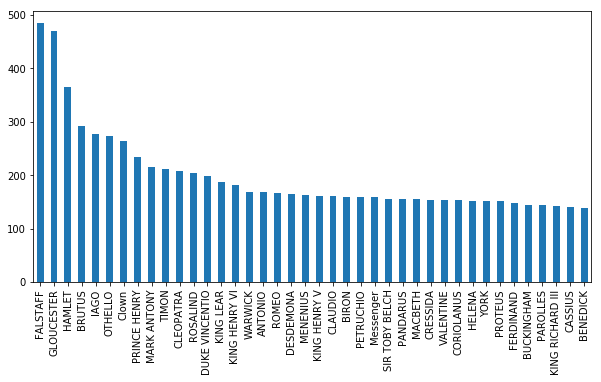

In [127]:
to_plot = sp.actor_name.value_counts().head(40)
plt.figure(figsize=(10,5))
to_plot.plot(kind='bar')
plt.show()

In [128]:
my_vec = CountVectorizer()
count_w = my_vec.fit_transform(sp.scene_text_cleaned)
plot_names = my_vec.get_feature_names()
plot_values = sum(count_w.toarray())

In [129]:
d = pd.DataFrame({'names': plot_names, 'values': plot_values})
d = d.sort_values('values', ascending=False).head(20)

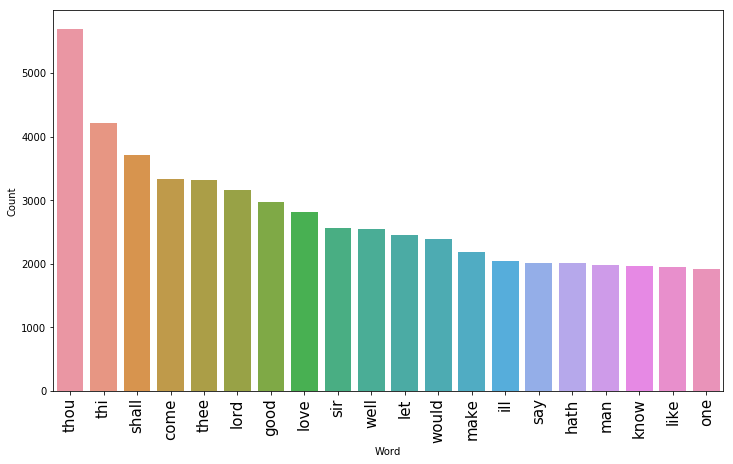

In [130]:
plt.figure(figsize=(12,7))

to_plot = sns.barplot(x="names", y="values", data=d)
to_plot.set(xlabel='Word', ylabel='Count')

plt.xticks(fontsize=15, rotation=90)
plt.show()

<a id='PlaysGenre'></a>

# 1.0 Check Plays & Genre

### The main goal of this part of analysis is to check whether one can distinguish between different plays and genres. 

- Are the plays written differetnly in terms words they are using? 
- Can one clearly differntiate between the four genres?
- Have all plays been written by Shakepeare or are there plays which are completely different from the others?

#### Check Plays & Genre (normalizaiton = False)

In [131]:
# create output with tfidf array
d = calc_tfidf(group=['genre', 'play'], norm=False)
tf_score = d[0]
tf_score.shape

(41, 19346)

In [132]:
# Create a table with the indexes for the ifidf array
selected_cols = create_df(sp, ['genre', 'play'])
selected_cols.play

0       A Midsummer Night's Dream
1       All's Well That Ends Well
2                  As You Like It
3                       Cymbeline
4             Love's Labours Lost
5             Measure for Measure
6          Much Ado About Nothing
7        Pericles, Prince of Tyre
8             Taming of the Shrew
9     The\nMerry Wives of Windsor
10           The Comedy of Errors
11         The Merchant of Venice
12                    The Tempest
13           Troilus and Cressida
14                  Twelfth Night
15        Two Gentlemen of Verona
16                  Winter's Tale
17               Henry IV, part 1
18               Henry IV, part 2
19                        Henry V
20               Henry VI, part 1
21               Henry VI, part 2
22               Henry VI, part 3
23                     Henry VIII
24                      King John
25                     Richard II
26                    Richard III
27             A Lovers Complaint
28            The Rape of Lucrece
29            

<a id='PCA_1'></a>

### 1.1 PCA Analysis

#### Check Plays & Genre (normalizaiton = False, count of words > 0)

In [133]:
# Select only columns where words appear greater than 0 times
selected = tf_score[:,sum(tf_score>0)>0]
selected.shape

(41, 19346)

In [134]:
pca = PCA(n_components=10)
pca.fit(selected)

projected = pca.fit_transform(selected)
print(pca.explained_variance_ratio_)
print('\nTotal Variance explained ' + str(np.round(sum(pca.explained_variance_ratio_),3)))

[ 0.0874698   0.07010793  0.06339535  0.05755011  0.05429252  0.04825492
  0.04151323  0.03716584  0.03281146  0.03068468]

Total Variance explained 0.523


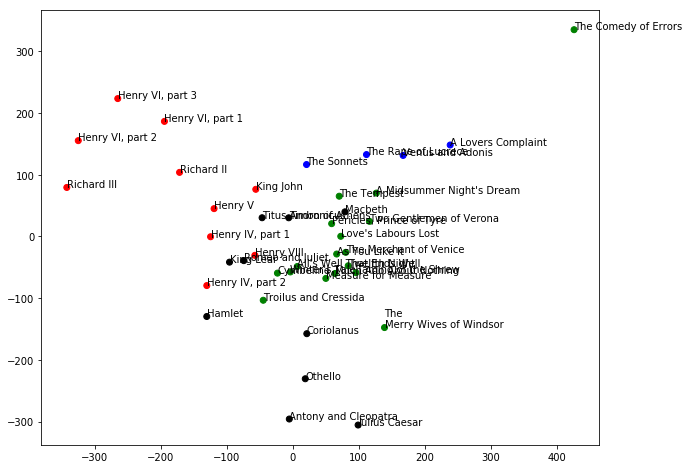

In [135]:
colors = {'Comedy':'green', 'Poetry':'blue', 'History':'red', 'Tragedy':'black'}

fig = plt.figure(figsize=(10, 8))

plt.scatter(projected[:, 0], projected[:, 1], c=selected_cols.genre.apply(lambda x: colors[x]))

for label, x, y in zip(selected_cols.play, projected[:, 0], projected[:, 1]):
    plt.annotate(label, xy=(x, y))

plt.show()

#### Conclusion:
This looks quite good, Histroy has a quite good separation, Poetry as well. Comedy in the upper right corener is quite an outlier in comparison to the other Comedies.

#### Check Plays & Genre (normalizaiton = False, count of words > 1)

In [136]:
# Select only columns where words appear greater than 1 time
selected = tf_score[:,sum(tf_score>0)>1]
selected.shape

(41, 9888)

In [137]:
pca = PCA(n_components=10)
pca.fit(selected)

projected = pca.fit_transform(selected)
print(pca.explained_variance_ratio_)
print('\nTotal Variance explained ' + str(np.round(sum(pca.explained_variance_ratio_),3)))

[ 0.1161042   0.08982849  0.08273347  0.06062229  0.05101032  0.04136283
  0.03665991  0.03410297  0.03392402  0.03076148]

Total Variance explained 0.577


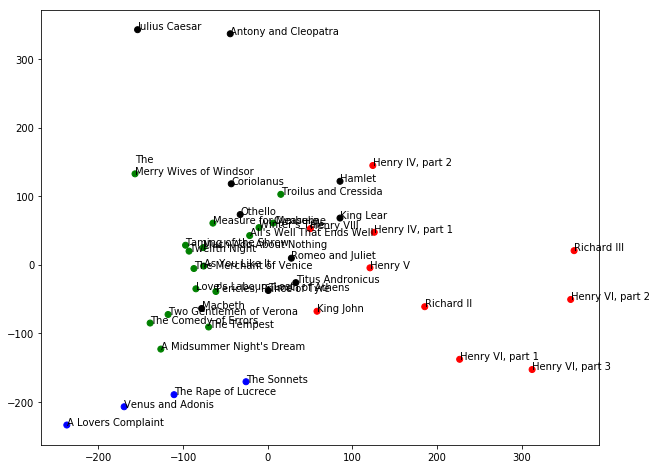

In [138]:
colors = {'Comedy':'green', 'Poetry':'blue', 'History':'red', 'Tragedy':'black'}

fig = plt.figure(figsize=(10, 8))

plt.scatter(projected[:, 0], projected[:, 1], c=selected_cols.genre.apply(lambda x: colors[x]))

for label, x, y in zip(selected_cols.play, projected[:, 0], projected[:, 1]):
    plt.annotate(label, xy=(x, y))

plt.show()

#### Conclusion
- Antony and Cleopatra & Julius Caesar are pulled away from the other Tragedies
- Macbeth is inmitten of Comedies.
- Intrestingly Comedies and Tragedies are next to each other.
- The Sonnets are clearly written differently than other genres as well as History.

#### Check Plays & Genre (normalizaiton = False, count of words > 2)

In [139]:
# Select only columns where words appear greater than 2 time
selected = tf_score[:,sum(tf_score>0)>2]
selected.shape

(41, 7579)

In [140]:
pca = PCA(n_components=10)
pca.fit(selected)

projected = pca.fit_transform(selected)
print(pca.explained_variance_ratio_)
print('\nTotal Variance explained ' + str(np.round(sum(pca.explained_variance_ratio_),3)))

[ 0.12812181  0.09734777  0.0846553   0.06419803  0.05301424  0.04346048
  0.03747865  0.03533173  0.03190299  0.02913652]

Total Variance explained 0.605


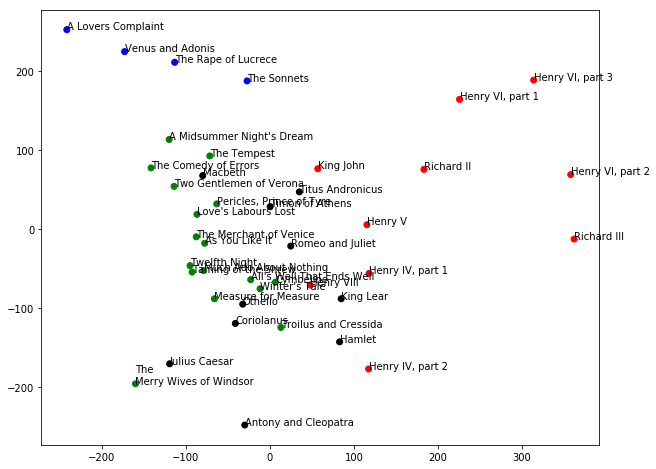

In [141]:
colors = {'Comedy':'green', 'Poetry':'blue', 'History':'red', 'Tragedy':'black'}

fig = plt.figure(figsize=(10, 8))

plt.scatter(projected[:, 0], projected[:, 1], c=selected_cols.genre.apply(lambda x: colors[x]))

for label, x, y in zip(selected_cols.play, projected[:, 0], projected[:, 1]):
    plt.annotate(label, xy=(x, y))

plt.show()

#### Conclusion
- Overall picutre remains unchanged
- The movement is to observe on the buttom with Antony and Cleopatra, The Comdedy of Errors & Julius Caesar. The both Tragedies come closer to the pulk with other strategies.

#### Check Plays & Genre (normalizaiton = False, count of words > 3)

In [142]:
# Select only columns where words appear greater than 3 time
selected = tf_score[:,sum(tf_score>0)>3]
selected.shape

(41, 6352)

In [143]:
pca = PCA(n_components=10)
pca.fit(selected)

projected = pca.fit_transform(selected)
print(pca.explained_variance_ratio_)
print('\nTotal Variance explained ' + str(np.round(sum(pca.explained_variance_ratio_),3)))

[ 0.13420004  0.10276631  0.08979428  0.06721154  0.05624967  0.04194426
  0.03723882  0.0358713   0.03171658  0.02881712]

Total Variance explained 0.626


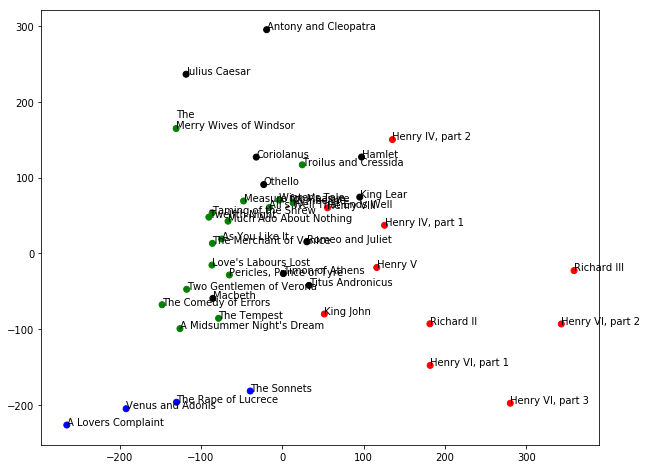

In [144]:
colors = {'Comedy':'green', 'Poetry':'blue', 'History':'red', 'Tragedy':'black'}

fig = plt.figure(figsize=(10, 8))

plt.scatter(projected[:, 0], projected[:, 1], c=selected_cols.genre.apply(lambda x: colors[x]))

for label, x, y in zip(selected_cols.play, projected[:, 0], projected[:, 1]):
    plt.annotate(label, xy=(x, y))

plt.show()

#### Conclusion
- The picture does not change a lot. Antony and Cleopatra remains kind of outlier in cmparison to other strategies.
- Comedy and Tragedy are overlapping.

#### Check Plays & Genre (normalizaiton = True, count of words > 3)

In [145]:
# create output with tfidf array
d = calc_tfidf(group=['genre', 'play'], norm=True)
tf_score = d[0]
tf_score.shape

(41, 19346)

In [146]:
# Select only columns where words appear greater than 3 time
selected = tf_score[:,sum(tf_score>0)>3]
selected.shape

(41, 6352)

In [147]:
pca = PCA(n_components=10)
pca.fit(selected)

projected = pca.fit_transform(selected)
print(pca.explained_variance_ratio_)
print('\nTotal Variance explained ' + str(np.round(sum(pca.explained_variance_ratio_),3)))

[ 0.10919286  0.10568574  0.07057837  0.05904745  0.04481456  0.04165014
  0.03810387  0.03614956  0.03231271  0.03022334]

Total Variance explained 0.568


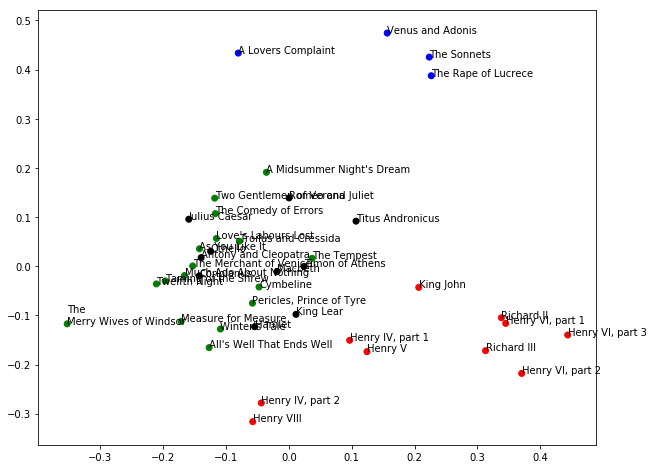

In [148]:
colors = {'Comedy':'green', 'Poetry':'blue', 'History':'red', 'Tragedy':'black'}

fig = plt.figure(figsize=(10, 8))

plt.scatter(projected[:, 0], projected[:, 1], c=selected_cols.genre.apply(lambda x: colors[x]))

for label, x, y in zip(selected_cols.play, projected[:, 0], projected[:, 1]):
    plt.annotate(label, xy=(x, y))

plt.show()

#### Conclusion
- As we cann see, the Poetries and Histories are clearly far away from each other
- The Comedies and Tragedies are somehow overlapping and quite different
- The Merry Wives of Windsor is the only Comedy which is somehow further away from the others

<a id='LSA_1'></a>

### 1.2 LSA Analysis

In [149]:
# create output with tfidf array
d = calc_tfidf(group=['genre', 'play'], norm=True)
tf_score = d[0]
tf_score.shape

(41, 19346)

In [150]:
# Select only columns where words appear greater than 3 time
selected = tf_score[:,sum(tf_score>0)>3]
selected.shape

(41, 6352)

In [151]:
lsa = TruncatedSVD(2, algorithm = 'arpack')
dtm_lsa = lsa.fit_transform(selected)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)
lsa.components_.shape

(2, 6352)

In [152]:
selected_columns_vec = [x for x, y in zip(d[1], sum(tf_score>0)>3) if y == True]
pd.DataFrame(lsa.components_, index = ["component_1","component_2"], columns = selected_columns_vec)

abandon  abandond      abat     abbey       abe     abhor  \
component_1  0.000804  0.000966  0.002525  0.001393  0.001299  0.003188   
component_2 -0.001013 -0.001416  0.000236 -0.000859 -0.001858 -0.000411   

              abhorrd      abid      abil    abject    ...        youll  \
component_1  0.001415  0.004497  0.001947  0.001412    ...     0.010206   
component_2 -0.001312  0.002170 -0.003229  0.000958    ...    -0.021239   

                young   younger  youngest      your     youth      youv  \
component_1  0.025077  0.003713  0.002400  0.006214  0.020265  0.000742   
component_2 -0.009549 -0.005483 -0.002192 -0.016147 -0.005398 -0.000349   

                 zeal    zealou     zound  
component_1  0.003772  0.001185  0.002841  
component_2  0.001774  0.002108  0.004095  

[2 rows x 6352 columns]

In [153]:
sel_db = create_df(sp, ['genre', 'play'])
lsa_db = pd.concat([sel_db, pd.DataFrame(dtm_lsa, columns=['comp1', 'comp2'])], axis=1)
lsa_db.head()

genre                       play     comp1     comp2
0  Comedy  A Midsummer Night's Dream  0.999124  0.041845
1  Comedy  All's Well That Ends Well  0.978693 -0.205330
2  Comedy             As You Like It  0.984839 -0.173470
3  Comedy                  Cymbeline  0.996735 -0.080748
4  Comedy        Love's Labours Lost  0.991251 -0.131987

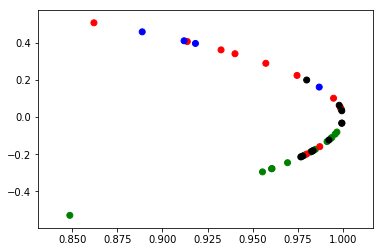

In [154]:
colors = {'Comedy':'green', 'Poetry':'blue', 'History':'red', 'Tragedy':'black'}
plt.scatter(lsa_db.comp1, lsa_db.comp2, c=lsa_db.genre.apply(lambda x: colors[x]))
plt.show()

#### A little different picturea as from above:
- Poetry and History are clearly separable
- Comedies and Tragedies are sligthly overlapping
- One comedy is clearly far away from all the other comedies. Is it maybe "The Merry Wives of Windsor" as seen slightly in PCA? 

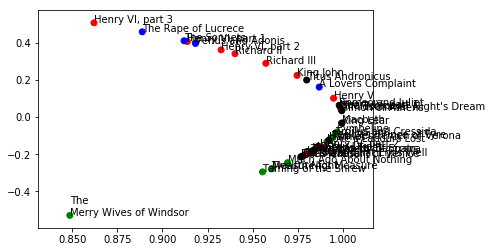

In [155]:
colors = {'Comedy':'green', 'Poetry':'blue', 'History':'red', 'Tragedy':'black'}
plt.scatter(lsa_db.comp1, lsa_db.comp2, c=lsa_db.genre.apply(lambda x: colors[x]))
for label, x, y in zip(lsa_db.play, lsa_db.comp1, lsa_db.comp2):
    plt.annotate(label, xy=(x, y))
plt.show()

It is "The Merry Wives of Windsor"

<a id='PlaysGenreActor'></a>

# 2.0 Check Actors (Sex/Character)

### The main goal of this part of analysis is to analyse the characters on its self

- Can one differentiate between female and male? 
- Can one identify characters which differ significatnly from the others?

In [157]:
sex = pd.read_csv('actor_sex.csv', sep=';', encoding='latin-1')
sp_sex = pd.merge(sp, sex, on='actor_name', how='left')
sp_sex.shape

(31743, 10)

In [158]:
sp_sex.Sex = sp_sex.Sex.fillna('Unknown')
sp_sex.Sex.unique()

array(['Female', 'Male', 'Unknown'], dtype=object)

In [159]:
# create output with tfidf array
d = calc_tfidf(group=['genre', 'play', 'actor_name'], norm=True)
tf_score = d[0]
tf_score.shape

(1383, 19346)

In [160]:
# Check if everthying worked as expected
selected_cols = create_df(sp_sex, ['genre', 'play', 'actor_name'])
pd.DataFrame(selected_cols['actor_name']).head()

actor_name
0        ALL
1     BOTTOM
2     COBWEB
3  DEMETRIUS
4      EGEUS

In [161]:
sex_selected = pd.merge(pd.DataFrame(selected_cols['actor_name']), sex, on='actor_name', how='left')
sex_selected.Sex = sex_selected.Sex.fillna('Unknown')

#### Check Plays/Genre/Actor (normalizaiton = True, count of words > 3)

In [162]:
# Select only columns where words appear greater than 3 times
selected = tf_score[:,sum(tf_score>0)>3]
selected.shape

(1383, 6820)

<a id='PCA_2'></a>

### 2.1 PCA Analysis

In [163]:
pca = PCA(n_components=10)
pca.fit(selected)

projected = pca.fit_transform(selected)
print(pca.explained_variance_ratio_)
print('\nTotal Variance explained ' + str(np.round(sum(pca.explained_variance_ratio_),3)))

[ 0.03271447  0.01646815  0.01361337  0.00931692  0.00780431  0.00731636
  0.00692287  0.00513375  0.00453627  0.00437182]

Total Variance explained 0.108


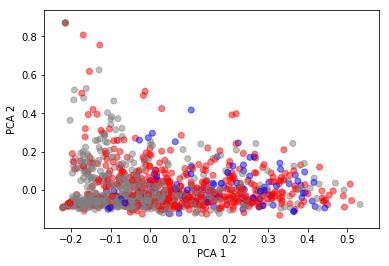

In [164]:
colors = {'Male':'red', 'Female':'blue', 'Unknown': 'gray'}

plt.scatter(projected[:, 0], projected[:, 1], c=sex_selected.Sex.apply(lambda x: colors[x]), alpha=0.5)

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.show()

#### Conclusion
One cannot clearly differentiate between Man and Woman although on the left buttom side there seems to be an overconcentration of red.

<a id='LSA_2'></a>

### 2.1 LSA Analysis

In [165]:
# create output with tfidf array
d = calc_tfidf(group=['genre', 'play', 'actor_name'], norm=True)
tf_score = d[0]
tf_score.shape

(1383, 19346)

In [166]:
# Select only columns where words appear greater than 3 times
selected = tf_score[:,sum(tf_score>0)>3]
selected.shape

(1383, 6820)

In [167]:
dtm_lsa = lsa.fit_transform(selected)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)
lsa.components_.shape

(2, 6820)

In [168]:
selected_columns_vec = [x for x, y in zip(d[1], sum(tf_score>0)>3) if y == True]
pd.DataFrame(lsa.components_, index = ["component_1","component_2"], columns = selected_columns_vec)

aaron   abandon  abandond      abat     abbey     abbot  \
component_1  0.004497  0.000707  0.001409  0.003046  0.002050  0.001062   
component_2 -0.006243 -0.000280  0.003868 -0.000462 -0.002168  0.001079   

                  abe     abhor   abhorrd      abid    ...        youll  \
component_1  0.001724  0.003951  0.001300  0.005469    ...     0.014339   
component_2  0.000145 -0.003143 -0.001083  0.001517    ...    -0.000376   

                young   younger  youngest      your     youth      youv  \
component_1  0.030044  0.004464  0.002738  0.007857  0.023088  0.001050   
component_2 -0.002786 -0.001308 -0.001248  0.004440 -0.015097  0.000246   

                 zeal    zealou     zound  
component_1  0.004864  0.001047  0.002587  
component_2  0.003993 -0.000439 -0.001604  

[2 rows x 6820 columns]

In [169]:
selected_cols = create_df(sp_sex, ['genre', 'play', 'actor_name'])
sex_selected = pd.merge(pd.DataFrame(selected_cols), sex, on='actor_name', how='left')
sex_selected.Sex = sex_selected.Sex.fillna('Unknown')

lsa_db = pd.concat([sex_selected, pd.DataFrame(dtm_lsa, columns=['comp1', 'comp2'])], axis=1)
lsa_db.head()

actor_name   genre                       play   Sex     comp1     comp2
0        ALL  Comedy  A Midsummer Night's Dream  Male  0.982386 -0.186862
1     BOTTOM  Comedy  A Midsummer Night's Dream  Male  0.995956 -0.089845
2     COBWEB  Comedy  A Midsummer Night's Dream  Male  0.998670  0.051558
3  DEMETRIUS  Comedy  A Midsummer Night's Dream  Male  0.976610 -0.215017
4      EGEUS  Comedy  A Midsummer Night's Dream  Male  0.994148  0.108027

GRATIANO  A Midsummer Night's Dream
KING  As You Like It
DROMIO OF EPHESUS  Cymbeline
Lords  Cymbeline
PUCK  Much Ado About Nothing
DUKE VINCENTIO  The
Merry Wives of Windsor
ROSALIND  The Comedy of Errors
FORD  The Merchant of Venice
PROSPERO  Troilus and Cressida
PANDARUS  Twelfth Night
LANCASTER  Henry V
Chorus  Henry VI, part 1
Clerk  Henry VI, part 2
All  Henry VIII
KING HENRY VIII  King John
BASTARD  Richard II
RICHMOND  Antony and Cleopatra
Second Roman  Coriolanus
Second Soldier  Coriolanus
ROSENCRANTZ:  Hamlet
ALBANY  Macbeth
MALCOLM  Othello
All  Timon of Athens


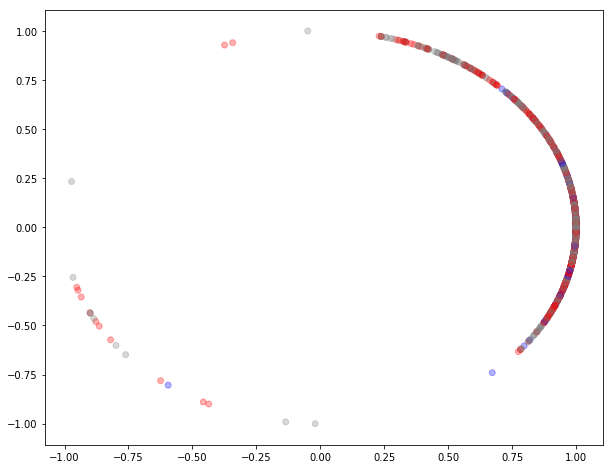

In [170]:
colors = {'Male':'red', 'Female':'blue', 'Unknown':'gray'}

fig = plt.figure(figsize=(10, 8))

plt.scatter(lsa_db.comp1, lsa_db.comp2, c=lsa_db.Sex.apply(lambda x: colors[x]), alpha=0.3)
for label, play, x, y in zip(lsa_db.actor_name, lsa_db.play, lsa_db.comp1, lsa_db.comp2):
    if x < -0:
        #plt.annotate(label, xy=(x, y))
        print(label + '  ' + play)

#plt.ylim(-1, -0.9)
#plt.xlim(-0.4, 0.3)
plt.show()

### All characters in the bottom left seem to be men, powerful or roles with influential behaviour
- Don Adriano de Armado is an affected Spanish braggart. He thinks himself a great friend of the King’s.
- Puck is a clever, mischievous elf, sprite or jester that personifies the wise knave
- FORD is a central character in The Merry Wives of Windsor. He is a middle-aged, middle-class gentleman. Jealous person.
- Vincentio as an arrogant, presumptuous man, who acts as though he were God, and is not at all a divine person
- He acts as a go-between for Troilus and Cressida and is always reducing their relationship to nothing more than a steamy hook-
up. He kills all the romance between our lovebirds when he rushes them off to the bedroom? 
- Richmond is the guy who bumps Richard off the throne and becomes King Henry VII.
- Bastard is an excellent fighter, hugely energetic, the Bastard is glib and extraordinarily cheeky, to the extent that John sometimes has to rein him in. Utterly guileless, he has no qualms about giving up a guaranteed income for the sake of a new name and the opportunities afforded by serving the King.
- Fortinbras is the Prince of Norway.



<a id='Classifier'></a>

# 3.0 Classification

<a id='ClassifierGenre'></a>

### 3.1 Genre Classification

In [171]:
# create output with tfidf array
d = calc_tfidf(group=['genre', 'play', 'actor_name'], norm=True)
tf_score = d[0]
tf_score.shape

(1383, 19346)

In [172]:
# Select only columns where words appear greater than 3 times
selected = tf_score[:,sum(tf_score>0)>3]
selected.shape

(1383, 6820)

In [173]:
selected_cols = create_df(sp_sex, ['genre', 'play', 'actor_name'])
sex_selected = pd.merge(pd.DataFrame(selected_cols), sex, on='actor_name', how='left')
sex_selected.Sex = sex_selected.Sex.fillna('Unknown')
sex_selected.shape

(1383, 4)

In [174]:
selected_columns_vec = [x for x, y in zip(d[1], sum(d[0]>0)>3) if y == True]
full_db = pd.concat([sex_selected, pd.DataFrame(selected, columns=selected_columns_vec)], axis=1)
full_db.head()

actor_name   genre                       play   Sex  aaron  abandon  \
0        ALL  Comedy  A Midsummer Night's Dream  Male    0.0      0.0   
1     BOTTOM  Comedy  A Midsummer Night's Dream  Male    0.0      0.0   
2     COBWEB  Comedy  A Midsummer Night's Dream  Male    0.0      0.0   
3  DEMETRIUS  Comedy  A Midsummer Night's Dream  Male    0.0      0.0   
4      EGEUS  Comedy  A Midsummer Night's Dream  Male    0.0      0.0   

   abandond  abat  abbey  abbot  ...    youll  young  younger  youngest  your  \
0       0.0   0.0    0.0    0.0  ...      0.0    0.0      0.0       0.0   0.0   
1       0.0   0.0    0.0    0.0  ...      0.0    0.0      0.0       0.0   0.0   
2       0.0   0.0    0.0    0.0  ...      0.0    0.0      0.0       0.0   0.0   
3       0.0   0.0    0.0    0.0  ...      0.0    0.0      0.0       0.0   0.0   
4       0.0   0.0    0.0    0.0  ...      0.0    0.0      0.0       0.0   0.0   

      youth  youv  zeal  zealou  zound  
0  0.000000   0.0   0.0     0.0    0.0  
1  0.000000   0.0   0.0     0.0    0.0  
2  0.000000   0.0   0.0     0.0    0.0  
3  0.000000   0.0   0.0     0.0    0.0  
4  0.046002   0.0   0.0     0.0    0.0  

[5 rows x 6824 columns]

In [175]:
full_db['genre'].value_counts()

Comedy     480
History    477
Tragedy    426
Name: genre, dtype: int64

In [176]:
x_train, x_test, y_train, y_test = train_test_split(full_db.iloc[:,4:], full_db.genre, test_size=0.33, random_state=19)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(926, 6820)
(926,)
(457, 6820)
(457,)


In [177]:
y_train.value_counts()

Comedy     339
History    320
Tragedy    267
Name: genre, dtype: int64

In [178]:
clf = LDA()
clf.fit(x_train, y_train)

/Users/rkheruwa/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/Users/rkheruwa/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [179]:
prediction = clf.predict(x_test)

In [180]:
my_crosstab = pd.crosstab(prediction, y_test)
my_crosstab

genre    Comedy  History  Tragedy
row_0                            
Comedy      118       42       48
History       8       98       13
Tragedy      15       17       98

In [181]:
sum(np.diag(my_crosstab))/sum(np.sum(my_crosstab))

0.68708971553610498

<a id='ClassifierPlay'></a>

### 3.2 Play Classification

In [182]:
x_train, x_test, y_train, y_test = train_test_split(full_db.iloc[:,4:], full_db.iloc[:,2], test_size=0.33, random_state=19)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(926, 6820)
(926,)
(457, 6820)
(457,)


In [183]:
y_train.value_counts()

Richard III                    53
Henry VI, part 1               41
Henry VI, part 2               38
Antony and Cleopatra           36
Coriolanus                     36
Pericles, Prince of Tyre       35
Henry V                        34
Cymbeline                      32
Timon of Athens                31
Henry VIII                     31
Julius Caesar                  29
Hamlet                         28
Henry VI, part 3               28
Henry IV, part 2               28
Romeo and Juliet               27
Taming of the Shrew            26
Macbeth                        25
Richard II                     25
Henry IV, part 1               24
A Midsummer Night's Dream      22
All's Well That Ends Well      22
Winter's Tale                  22
Othello                        21
As You Like It                 20
The Merchant of Venice         19
The\nMerry Wives of Windsor    19
Titus Andronicus               18
King John                      18
Love's Labours Lost            17
The Tempest   

In [184]:
clf = LDA()
clf.fit(x_train, y_train)

/Users/rkheruwa/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [185]:
prediction = clf.predict(x_test)

In [186]:
my_crosstab = pd.crosstab(prediction, y_test)
my_crosstab

play                         A Midsummer Night's Dream  \
row_0                                                    
A Midsummer Night's Dream                            6   
All's Well That Ends Well                            0   
Antony and Cleopatra                                 0   
As You Like It                                       0   
Coriolanus                                           0   
Cymbeline                                            0   
Hamlet                                               0   
Henry IV, part 1                                     0   
Henry IV, part 2                                     0   
Henry V                                              0   
Henry VI, part 1                                     0   
Henry VI, part 2                                     0   
Henry VI, part 3                                     2   
Henry VIII                                           0   
Julius Caesar                                        0   
King John                                            0   
King Lear                                            0   
Love's Labours Lost                                  0   
Macbeth                                              0   
Measure for Measure                                  0   
Much Ado About Nothing                               0   
Othello                                              0   
Pericles, Prince of Tyre                             0   
Richard II                                           0   
Richard III                                          0   
Romeo and Juliet                                     0   
Taming of the Shrew                                  0   
The\nMerry Wives of Windsor                          0   
The Comedy of Errors                                 0   
The Merchant of Venice                               0   
The Tempest                                          0   
Timon of Athens                                      0   
Titus Andronicus                                     0   
Troilus and Cressida                                 0   
Twelfth Night                                        1   
Two Gentlemen of Verona                              0   
Winter's Tale                                        0   

play                         All's Well That Ends Well  Antony and Cleopatra  \
row_0                                                                          
A Midsummer Night's Dream                            0                     0   
All's Well That Ends Well                            0                     0   
Antony and Cleopatra                                 1                    10   
As You Like It                                       0                     1   
Coriolanus                                           0                     0   
Cymbeline                                            0                     0   
Hamlet                                               0                     0   
Henry IV, part 1                                     0                     0   
Henry IV, part 2                                     0                     0   
Henry V                                              0                     0   
Henry VI, part 1                                     0                     0   
Henry VI, part 2                                     0                     1   
Henry VI, part 3                                     1                     2   
Henry VIII                                           0                     0   
Julius Caesar                                        0                     0   
King John                                            0                     0   
King Lear                                            0                     1   
Love's Labours Lost                                  0                     0   
Macbeth                                              0                     0   
Measure for Measure                                  0   

In [187]:
sum(np.diag(my_crosstab))/sum(np.sum(my_crosstab))

0.39606126914660833

#### Conclusion:
- It is quite good to differentiate between the genres with a simple model 
- It is much more difficult to identify the correct play

<a id='Network Analysis'></a>



# 4.0 Network Analysis

<a id='DataAnalysis'></a>


## 4.1 Data Preparation and Analysis

Running NetworkX tests:.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

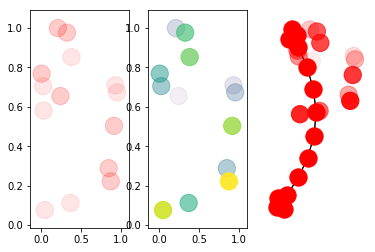

..

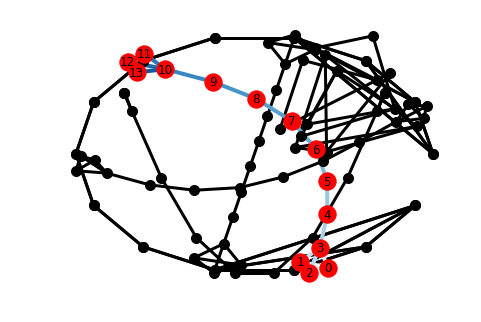

...

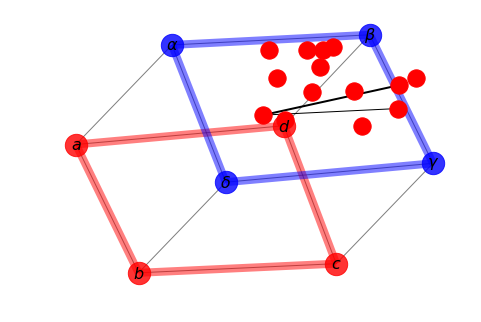

..........................................................................................................................................................................................................................................................................................................................S............................................................................................................................................................
----------------------------------------------------------------------
Ran 3175 tests in 106.446s

OK (SKIP=3)


In [188]:
nx.test()

* Given Shakespeare_data.csv dataset comprised of all of Shakespeare's plays. It includes the following:

    1.The first column is the Data-Line, it just keeps track of all the rows there are.
    2.The second column is the play that the lines are from.
    3.The third column is the player line number.
    4.The fourth column is the Act-Scene-Line from which any given line is from.
    5.The fifth column is the player who is saying any given line.
    6.The sixth column is the line being spoken.


In [189]:
df = pd.read_csv('/Users/rkheruwa/Downloads/shakespeare-plays/Shakespeare_data.csv')

In [190]:
df.head(10)

Dataline      Play  PlayerLinenumber ActSceneLine         Player  \
0         1  Henry IV               NaN          NaN            NaN   
1         2  Henry IV               NaN          NaN            NaN   
2         3  Henry IV               NaN          NaN            NaN   
3         4  Henry IV               1.0        1.1.1  KING HENRY IV   
4         5  Henry IV               1.0        1.1.2  KING HENRY IV   
5         6  Henry IV               1.0        1.1.3  KING HENRY IV   
6         7  Henry IV               1.0        1.1.4  KING HENRY IV   
7         8  Henry IV               1.0        1.1.5  KING HENRY IV   
8         9  Henry IV               1.0        1.1.6  KING HENRY IV   
9        10  Henry IV               1.0        1.1.7  KING HENRY IV   

                                          PlayerLine  
0                                              ACT I  
1                       SCENE I. London. The palace.  
2  Enter KING HENRY, LORD JOHN OF LANCASTER, the ...  
3             So shaken as we are, so wan with care,  
4         Find we a time for frighted peace to pant,  
5     And breathe short-winded accents of new broils  
6            To be commenced in strands afar remote.  
7          No more the thirsty entrance of this soil  
8  Shall daub her lips with her own children's bl...  
9   Nor more shall trenching war channel her fields,

In [191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111396 entries, 0 to 111395
Data columns (total 6 columns):
Dataline            111396 non-null int64
Play                111396 non-null object
PlayerLinenumber    111393 non-null float64
ActSceneLine        105153 non-null object
Player              111389 non-null object
PlayerLine          111396 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 5.1+ MB


In [192]:
df['Player'].replace(np.nan, 'Other',inplace = True)
df.head(5)

Dataline      Play  PlayerLinenumber ActSceneLine         Player  \
0         1  Henry IV               NaN          NaN          Other   
1         2  Henry IV               NaN          NaN          Other   
2         3  Henry IV               NaN          NaN          Other   
3         4  Henry IV               1.0        1.1.1  KING HENRY IV   
4         5  Henry IV               1.0        1.1.2  KING HENRY IV   

                                          PlayerLine  
0                                              ACT I  
1                       SCENE I. London. The palace.  
2  Enter KING HENRY, LORD JOHN OF LANCASTER, the ...  
3             So shaken as we are, so wan with care,  
4         Find we a time for frighted peace to pant,

## Number of total plays as shown below are 36

In [193]:
print("Number of plays are: " + str(df['Play'].nunique()))

Number of plays are: 36


### Let us try to find out the names of all of the plays and list them

In [194]:
pd.DataFrame(df['Play'].unique().tolist(), columns=['Play Name'])

Play Name
0                   Henry IV
1            Henry VI Part 1
2            Henry VI Part 2
3            Henry VI Part 3
4   Alls well that ends well
5             As you like it
6       Antony and Cleopatra
7         A Comedy of Errors
8                 Coriolanus
9                  Cymbeline
10                    Hamlet
11                   Henry V
12                Henry VIII
13                 King John
14             Julius Caesar
15                 King Lear
16        Loves Labours Lost
17                   macbeth
18       Measure for measure
19        Merchant of Venice
20    Merry Wives of Windsor
21  A Midsummer nights dream
22    Much Ado about nothing
23                   Othello
24                  Pericles
25                Richard II
26               Richard III
27          Romeo and Juliet
28       Taming of the Shrew
29               The Tempest
30           Timon of Athens
31          Titus Andronicus
32      Troilus and Cressida
33             Twelfth Night
34   Two Gentlemen of Verona
35            A Winters Tale

### Next on, lets try to plot the "Number of actors" against each "Play" and visualize them

    Number of Actors                      Play
0                 71               Richard III
1                 65           Henry VI Part 2
2                 62                Coriolanus
3                 55           Timon of Athens
4                 55      Antony and Cleopatra
5                 53           Henry VI Part 1
6                 51             Julius Caesar
7                 48                  Pericles
8                 47                   Henry V
9                 47                Henry VIII
10                46           Henry VI Part 3
11                42                 Cymbeline
12                42                   macbeth
13                38       Taming of the Shrew
14                37                Richard II
15                37          Romeo and Juliet
16                36                  Henry IV
17                36            A Winters Tale
18                35                    Hamlet
19                31  A Midsummer nights dream
20           

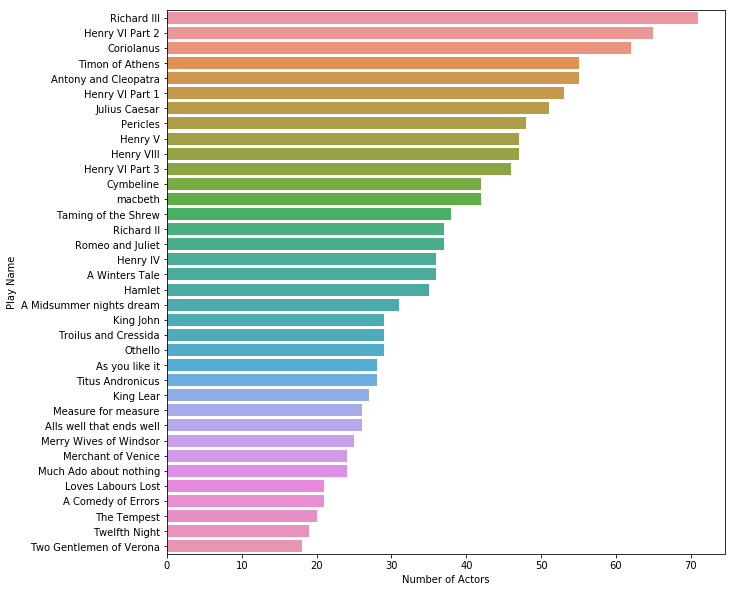

In [195]:
numberOfActors = df.groupby(['Play'])['Player'].nunique().sort_values(ascending= False).to_frame()
numberOfActors['Play'] = numberOfActors.index.tolist()
numberOfActors.columns = ['Number of Actors','Play']
numberOfActors.index= np.arange(0,len(numberPlayers))
print(numberOfActors)

plt.figure(figsize=(10,10))
ax = sns.barplot(x='Number of Actors',y='Play',data=numberOfActors)
ax.set(xlabel='Number of Actors', ylabel='Play Name')
plt.show()

### Let us try to analyze the total number of lines in each individual play

In [196]:
play_data = df.groupby('Play').count().sort_values(by='PlayerLine',ascending=False)['PlayerLine']
play_data = play_data.to_frame()
play_data['Play'] = play_data.index.tolist()
play_data.index = np.arange(0,len(play_data)) #changing the index from plays to numbers
play_data.columns =['Lines','Play']
play_data

Lines                      Play
0    4244                    Hamlet
1    3992                Coriolanus
2    3958                 Cymbeline
3    3941               Richard III
4    3862      Antony and Cleopatra
5    3766                 King Lear
6    3762                   Othello
7    3711      Troilus and Cressida
8    3489            A Winters Tale
9    3419                Henry VIII
10   3395                   Henry V
11   3334           Henry VI Part 2
12   3313          Romeo and Juliet
13   3205                  Henry IV
14   3138           Henry VI Part 3
15   3083  Alls well that ends well
16   2998       Measure for measure
17   2986        Loves Labours Lost
18   2983           Henry VI Part 1
19   2937                Richard II
20   2831    Merry Wives of Windsor
21   2822            As you like it
22   2806       Taming of the Shrew
23   2802        Merchant of Venice
24   2771             Julius Caesar
25   2766                 King John
26   2726          Titus Andronicus
27   2704    Much Ado about nothing
28   2662           Timon of Athens
29   2648             Twelfth Night
30   2641                  Pericles
31   2586                   macbeth
32   2403               The Tempest
33   2357   Two Gentlemen of Verona
34   2300  A Midsummer nights dream
35   2055        A Comedy of Errors

### Next on, lets try to plot the "Total number of lines" against each "Play" and visualize them

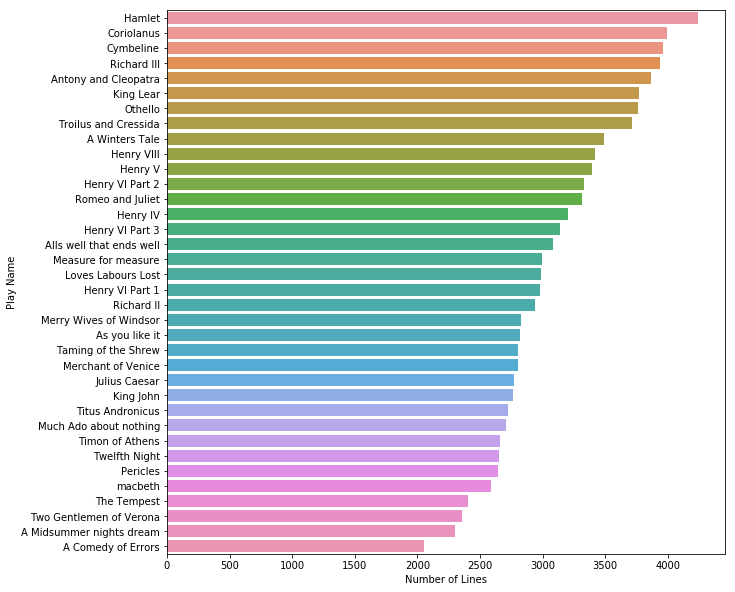

In [197]:
plt.figure(figsize=(10,10))
ax= sns.barplot(x='Lines',y='Play',data=play_data, order = play_data['Play'])
ax.set(xlabel='Number of Lines', ylabel='Play Name')
plt.show()

In [198]:
# Total number of lines said by each player in the respective plays

In [199]:
df.groupby(['Play','Player']).count()['PlayerLine']

Play                      Player            
A Comedy of Errors        ADRIANA               284
                          AEGEON                150
                          AEMELIA                75
                          ANGELO                 99
                          ANTIPHOLUS              6
                          BALTHAZAR              31
                          Courtezan              43
                          DROMIO OF EPHESUS     191
                          DROMIO OF SYRACUSE    323
                          DUKE SOLINUS           97
                          First Merchant         19
                          Gaoler                  1
                          LUCE                   11
                          LUCIANA               118
                          OCTAVIUS CAESAR         3
                          OF EPHESUS            221
                          OF SYRACUSE           292
                          Officer                17
                   

### Forming a frame for the lines said by each player across all the plays

In [200]:
lines_per_player= df.groupby(['Play','Player']).count()['PlayerLine']
lines_per_player= lines_per_player.to_frame()
lines_per_player

PlayerLine
Play                     Player                        
A Comedy of Errors       ADRIANA                    284
                         AEGEON                     150
                         AEMELIA                     75
                         ANGELO                      99
                         ANTIPHOLUS                   6
                         BALTHAZAR                   31
                         Courtezan                   43
                         DROMIO OF EPHESUS          191
                         DROMIO OF SYRACUSE         323
                         DUKE SOLINUS                97
                         First Merchant              19
                         Gaoler                       1
                         LUCE                        11
                         LUCIANA                    118
                         OCTAVIUS CAESAR              3
                         OF EPHESUS                 221
                         OF SYRACUSE                292
                         Officer                     17
                         PINCH                       17
                         Second Merchant             41
                         Servant                     16
A Midsummer nights dream ALL                          2
                         BOTTOM                     220
                         COBWEB                       4
                         DEMETRIUS                  144
                         EGEUS                       42
                         FLUTE                       26
                         FORD                         3
                         Fairy                       33
                         HELENA                     237
...                                                 ...
macbeth                  First Murderer              35
                         First Witch                 68
                         Gentlewoman                 27
                         HECATE                      43
                         LADY MACBETH               279
                         LADY MACDUFF                43
                         LENNOX                      79
                         Lord                        25
                         Lords                        4
                         MACBETH                    783
                         MACDUFF                    193
                         MALCOLM                    222
                         MENTEITH                    12
                         Messenger                   24
                         Old Man                     15
                         Porter                      53
                         ROSS                       137
                         SEYTON                       6
                         SIWARD                      37
                         Second Apparition            5
                         Second Murderer             16
                         Second Witch                29
                         Sergeant                    35
                         Servant                      6
                         Soldiers                     1
                         Son                         24
                         Third Apparition             6
                         Third Murderer               8
                         Third Witch                 27
                         YOUNG SIWARD                 8

[1328 rows x 1 columns]

### Plotting the number of lines said by each player across all the plays

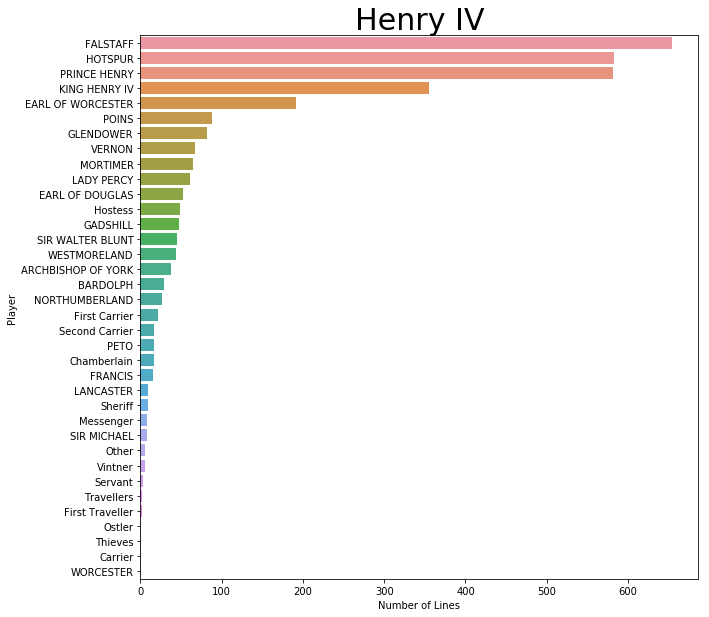

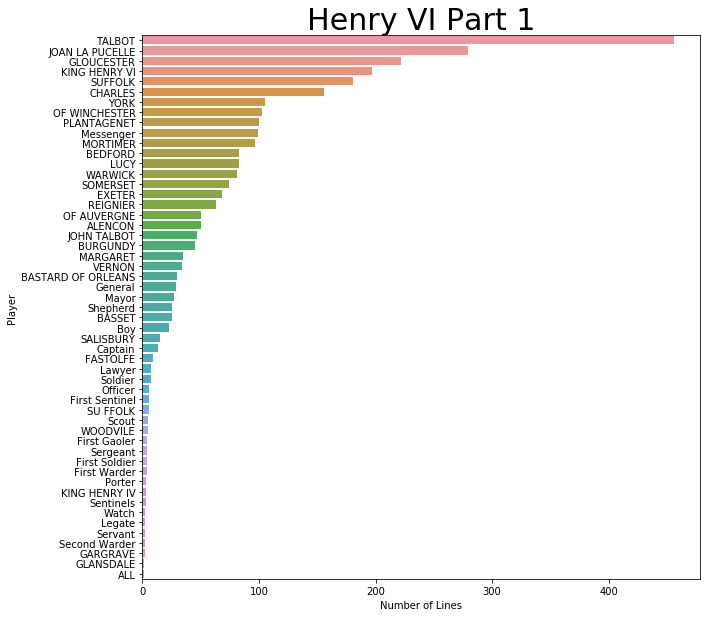

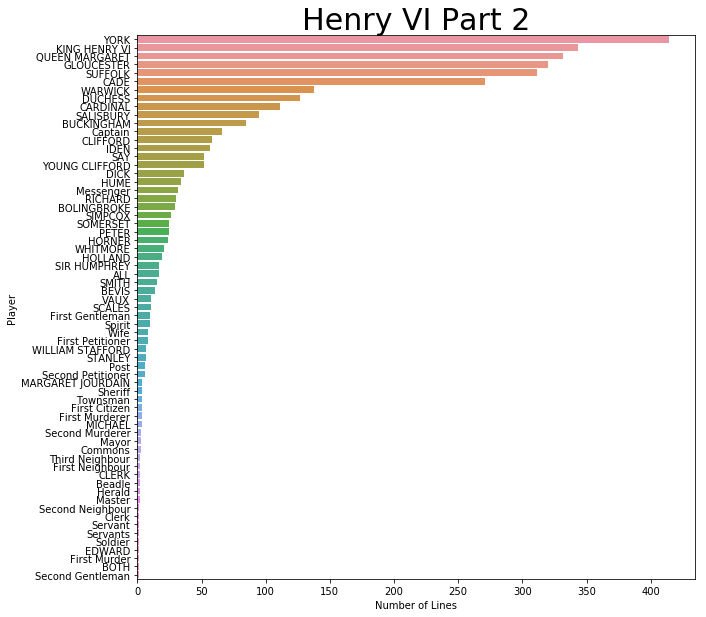

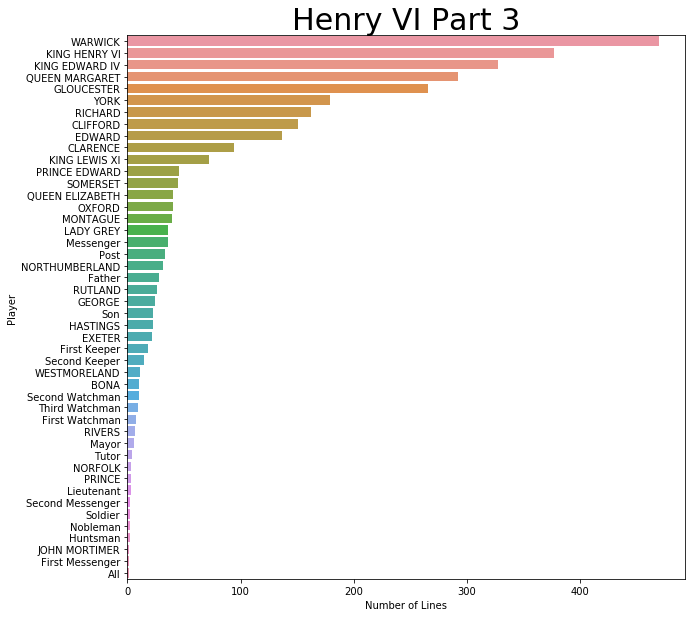

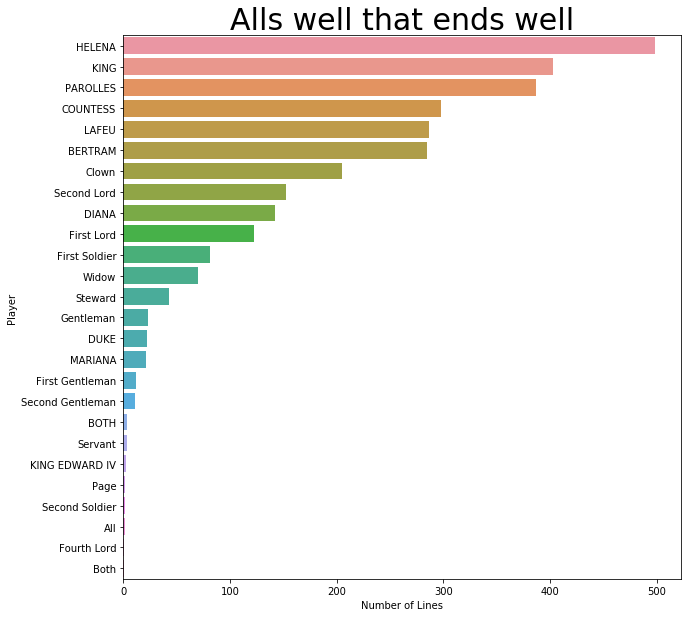

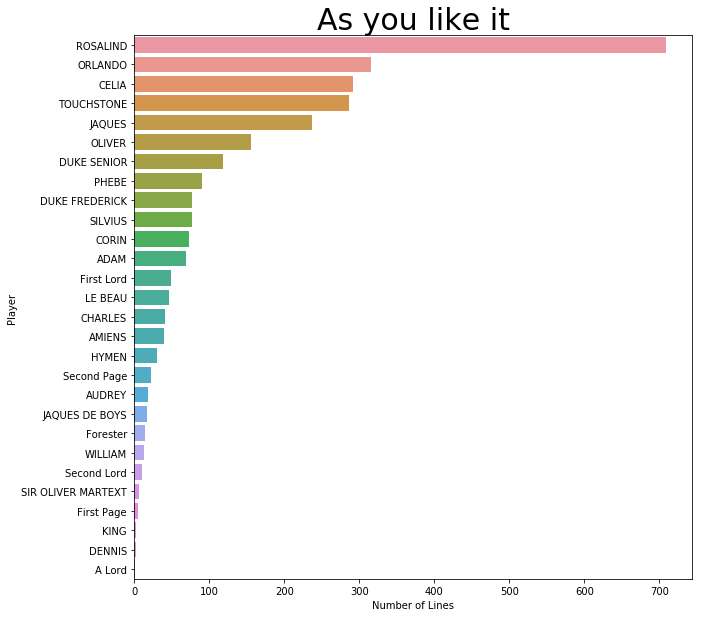

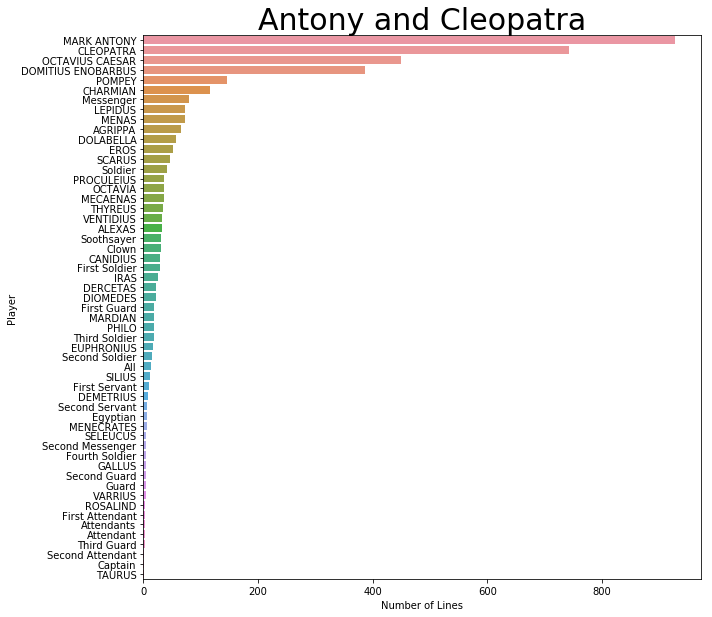

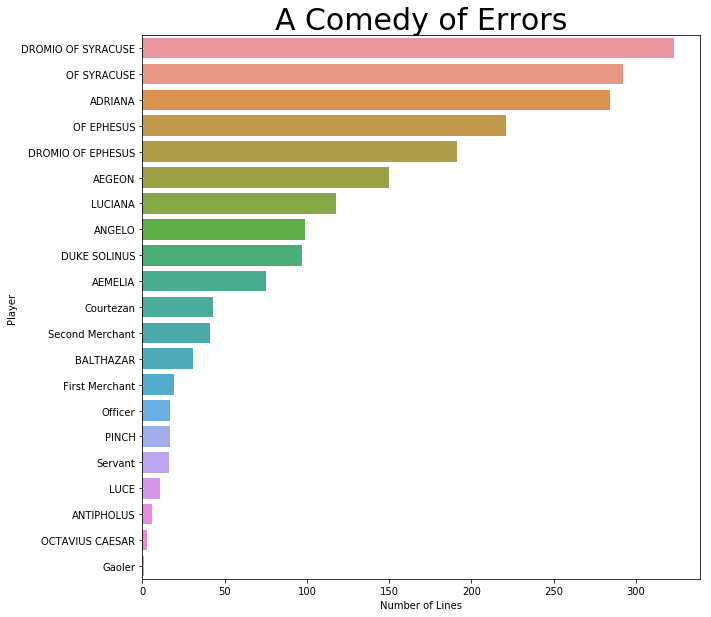

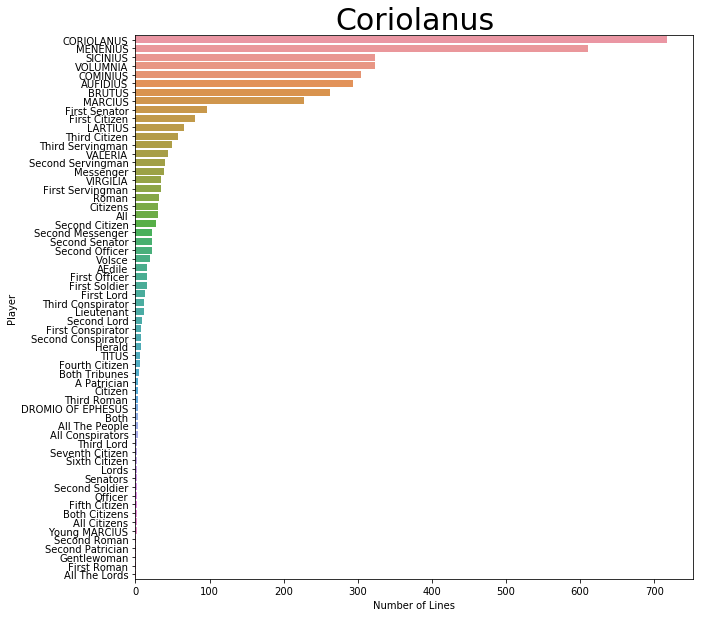

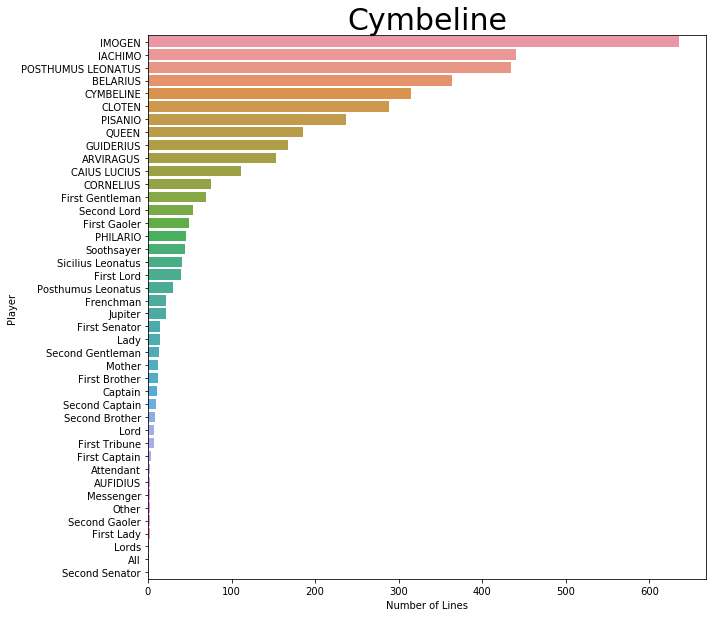

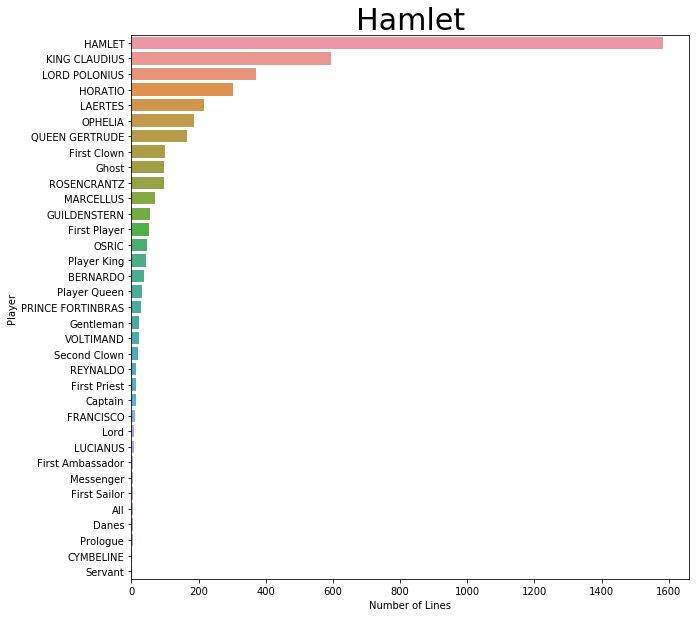

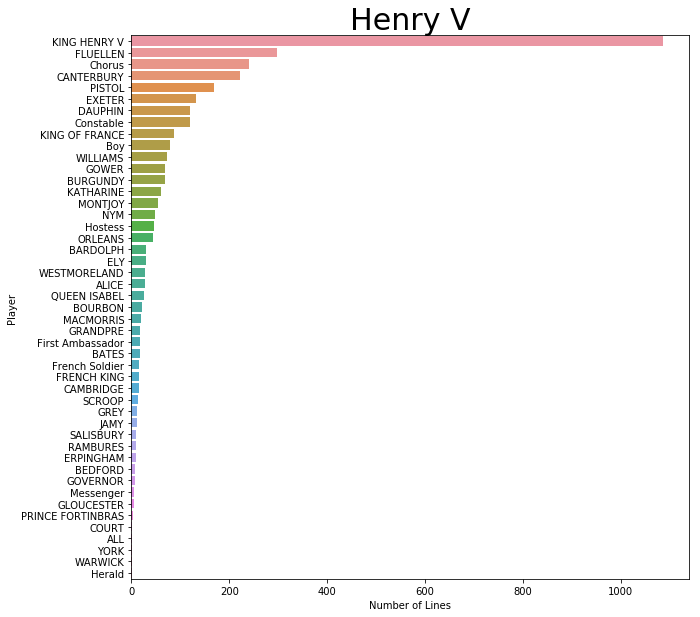

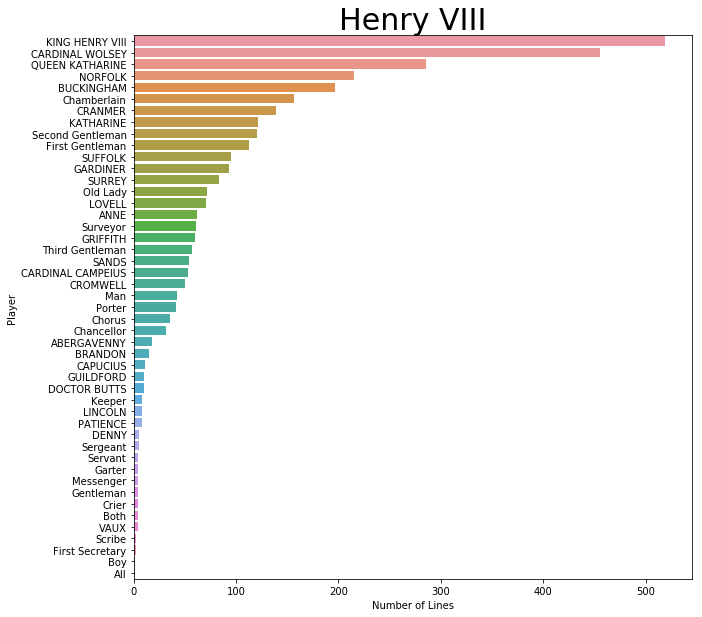

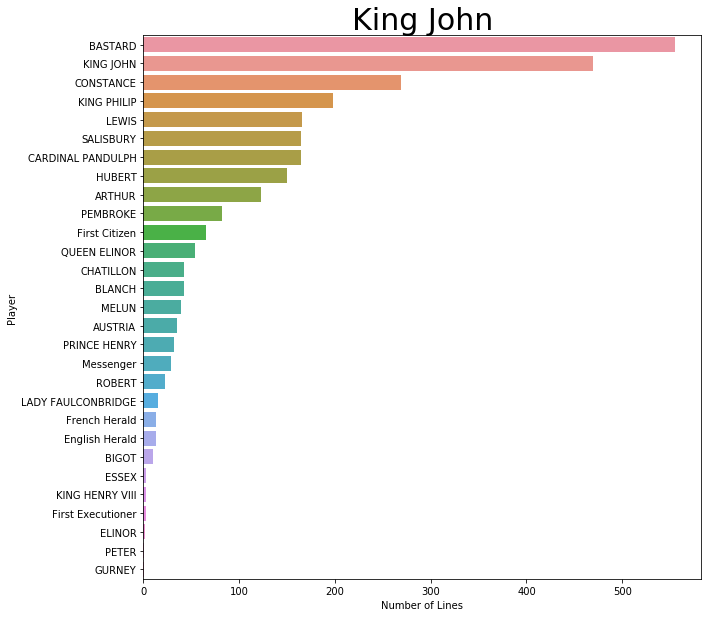

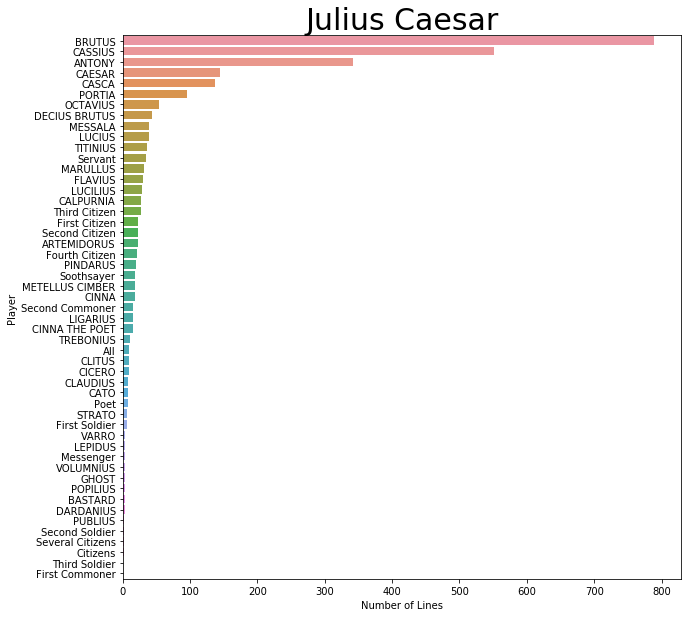

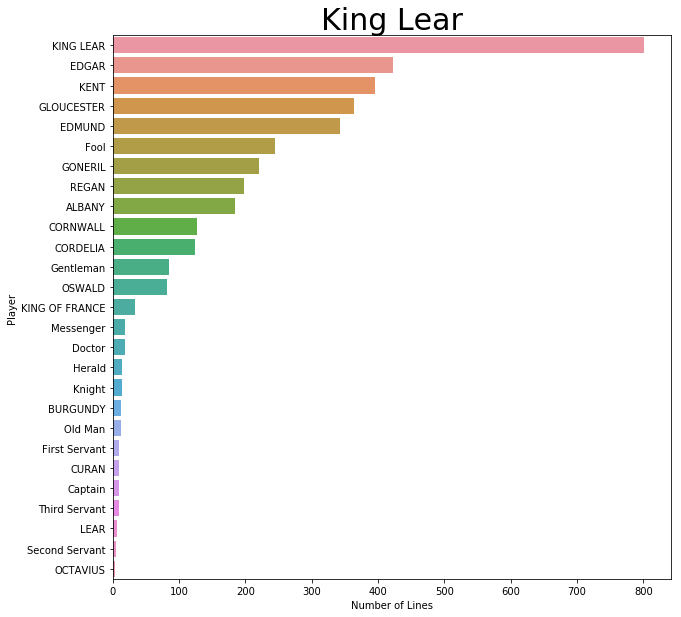

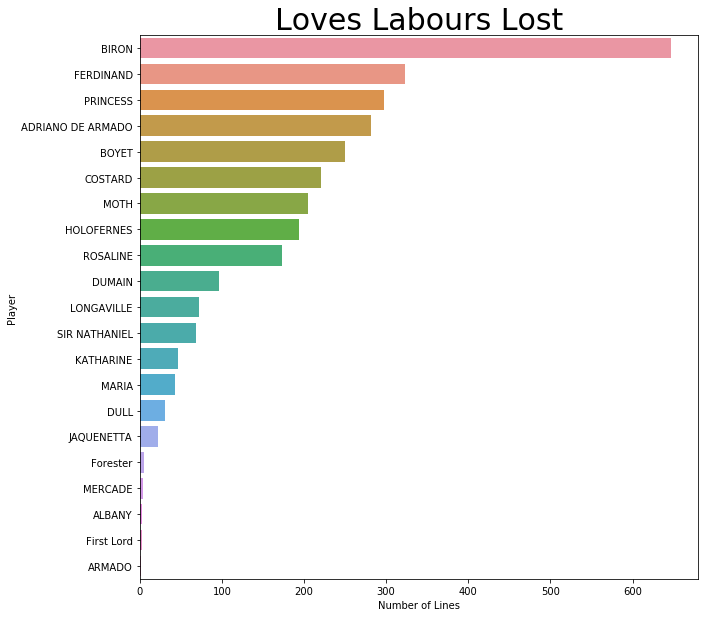

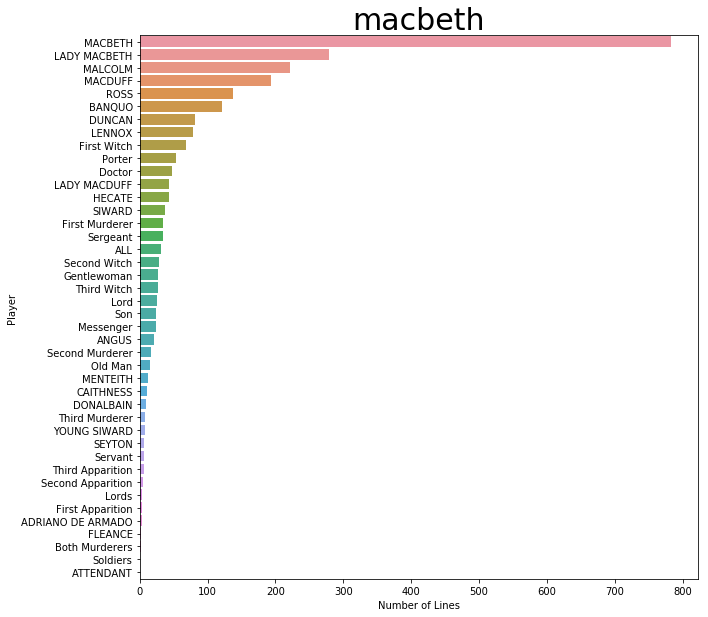

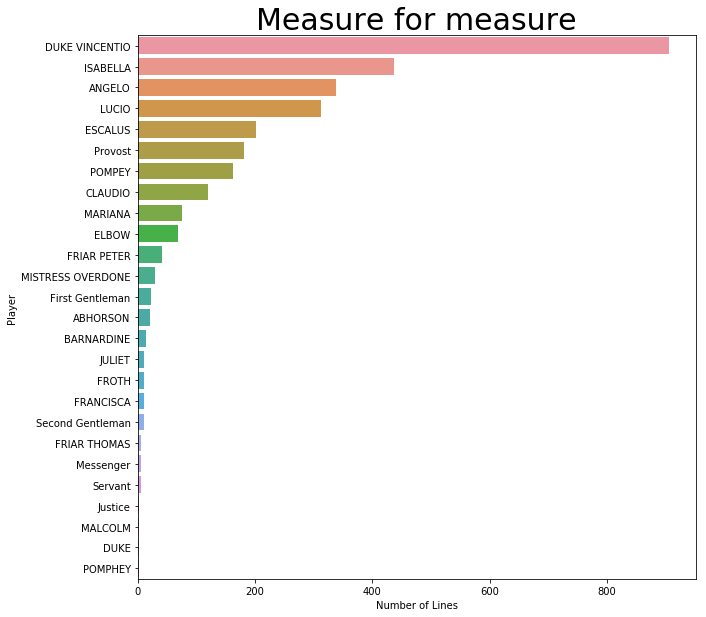

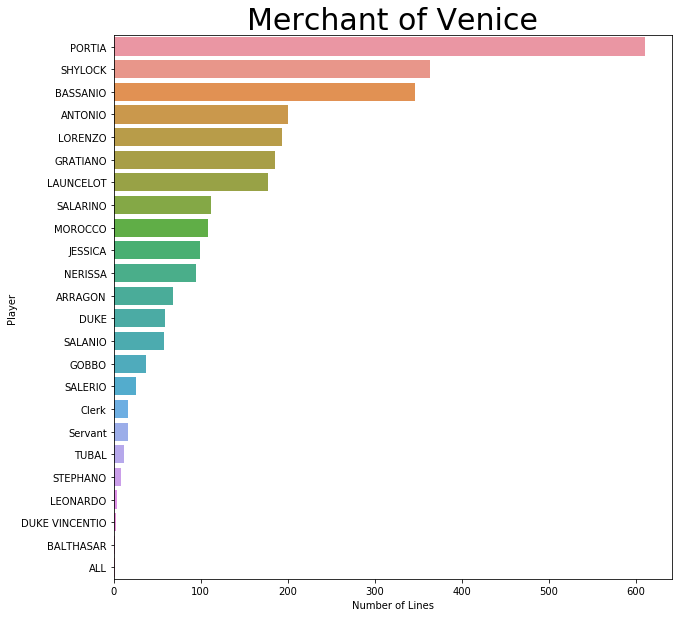

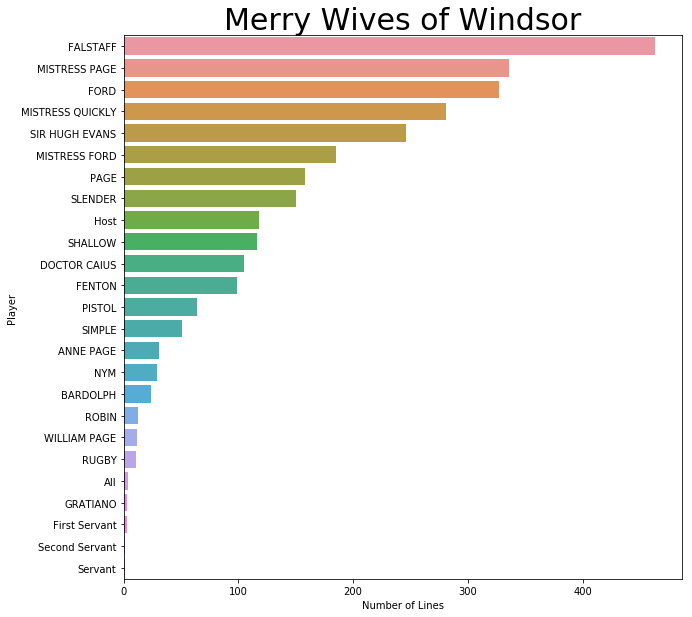

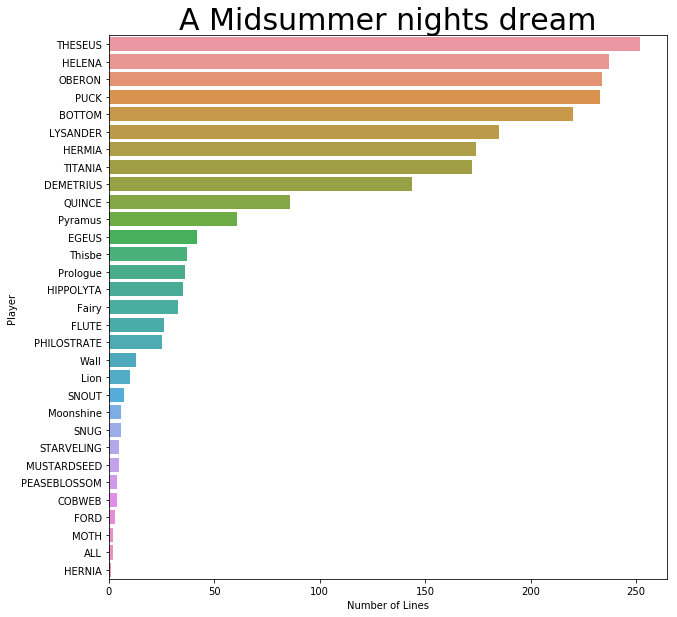

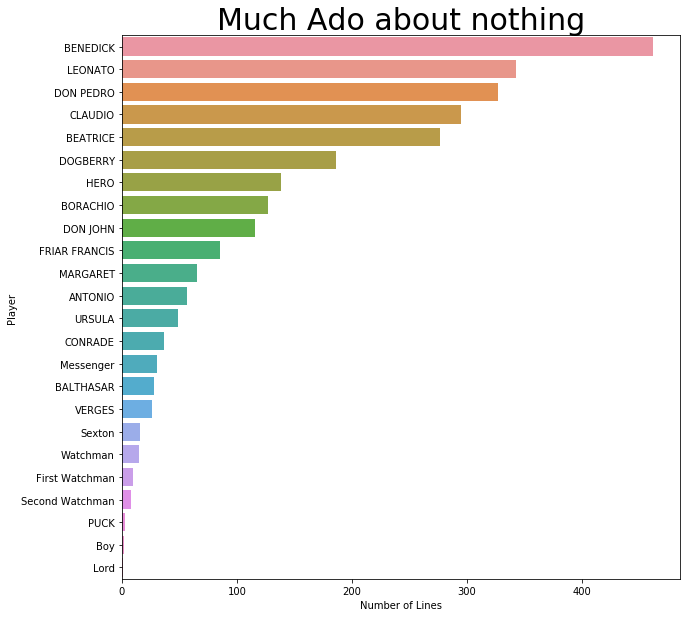

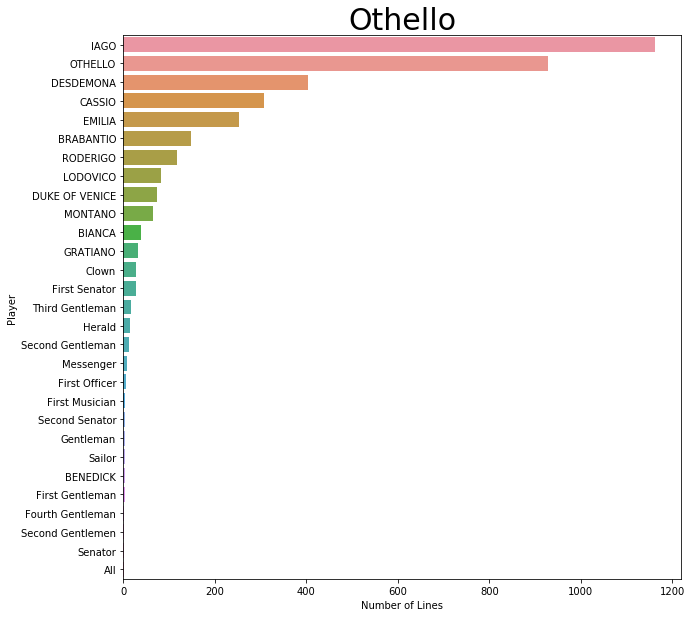

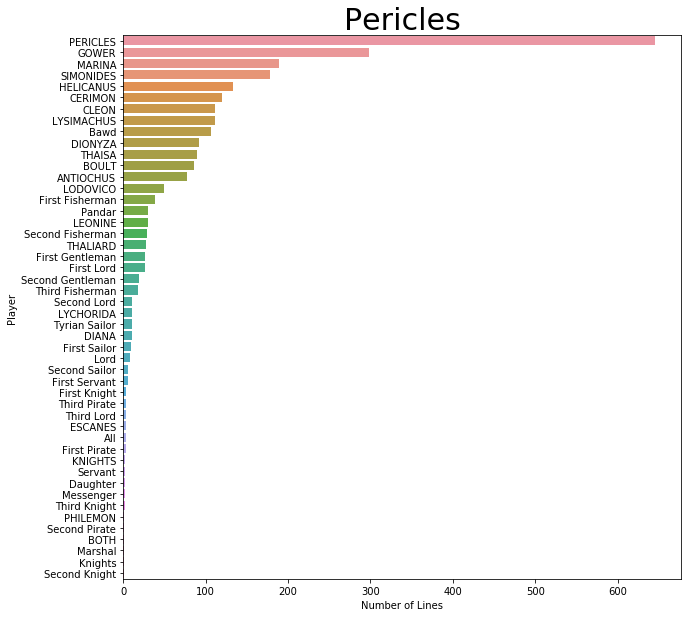

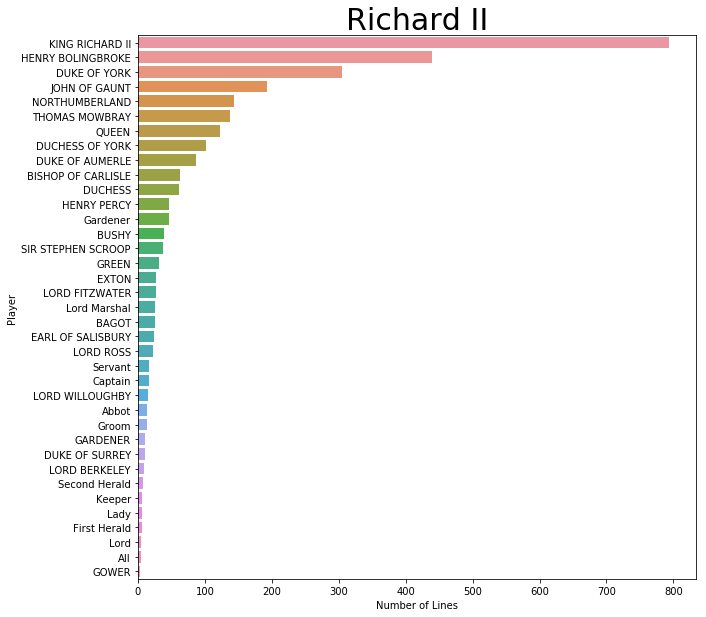

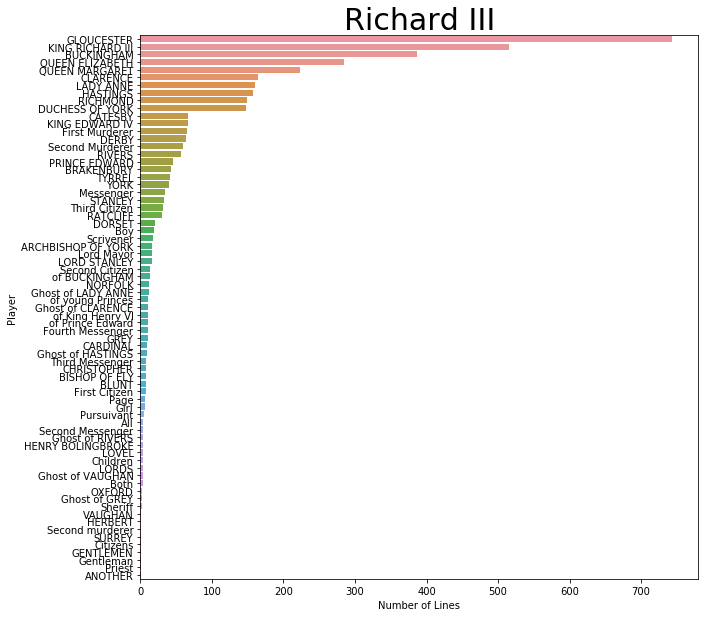

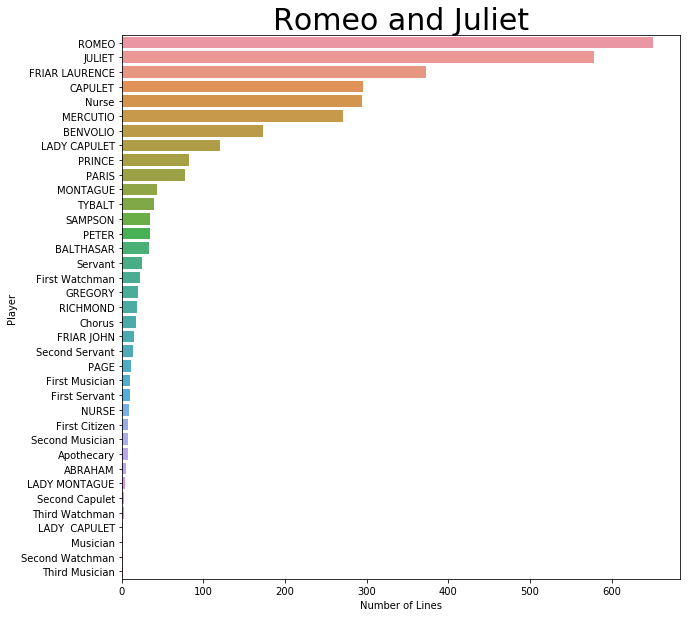

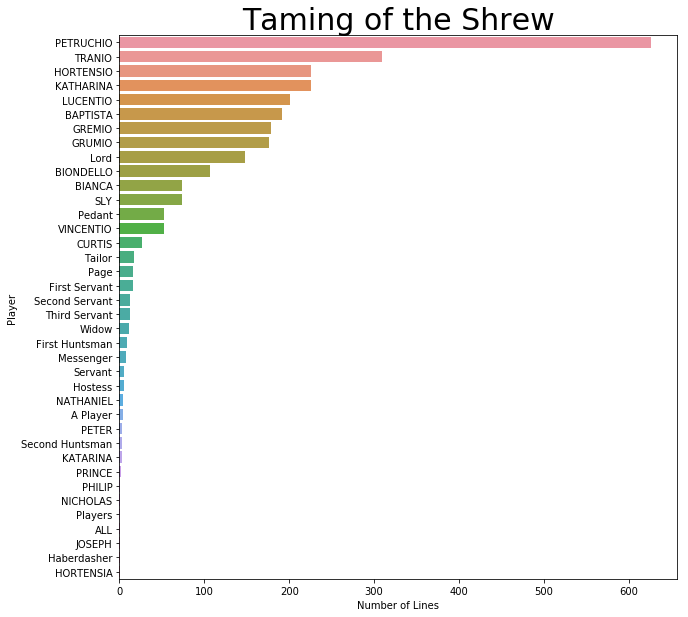

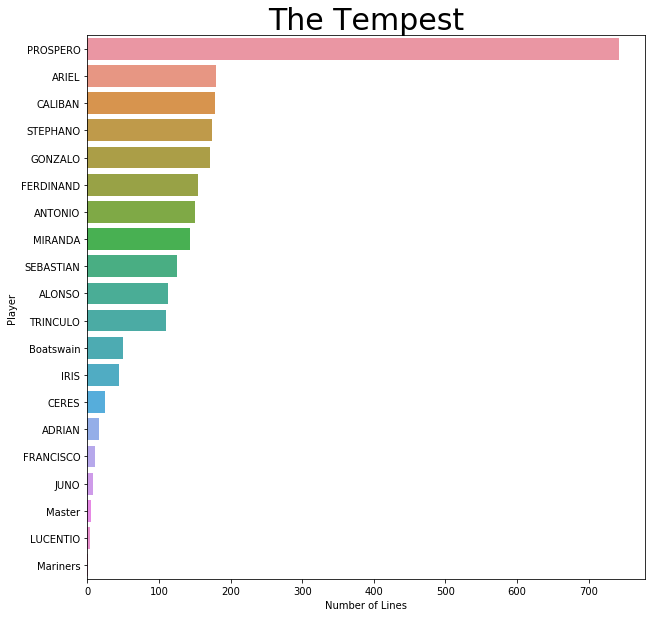

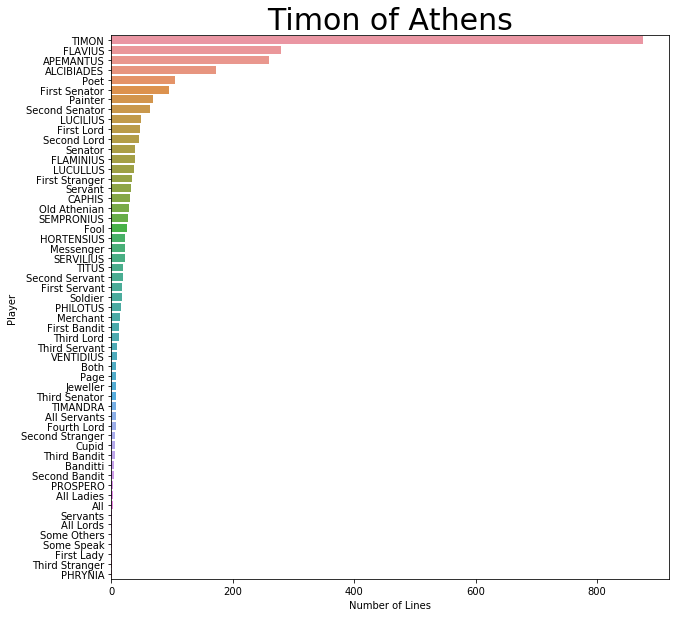

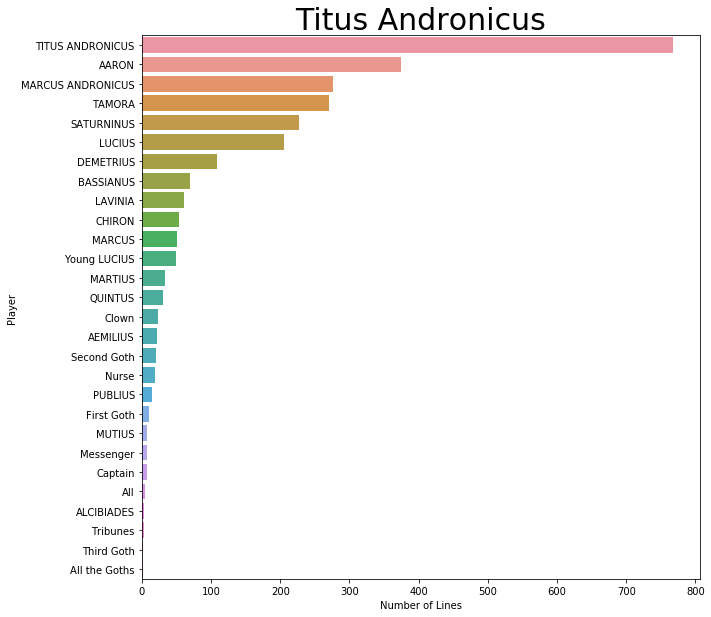

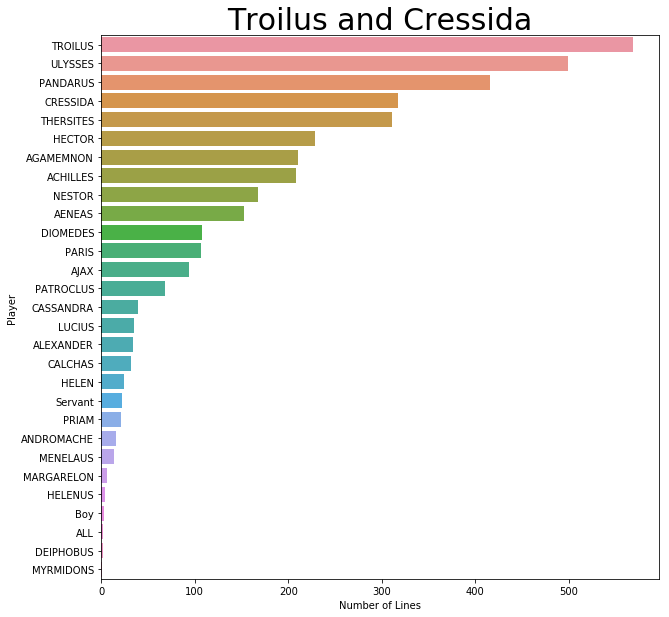

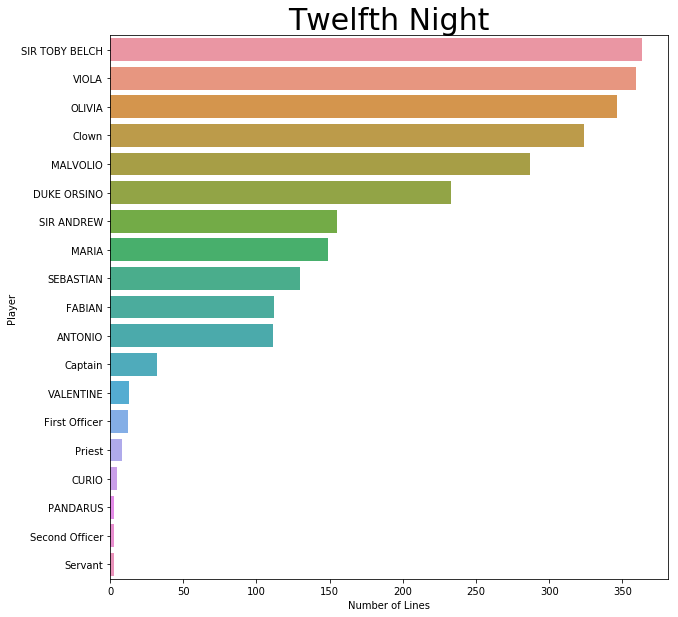

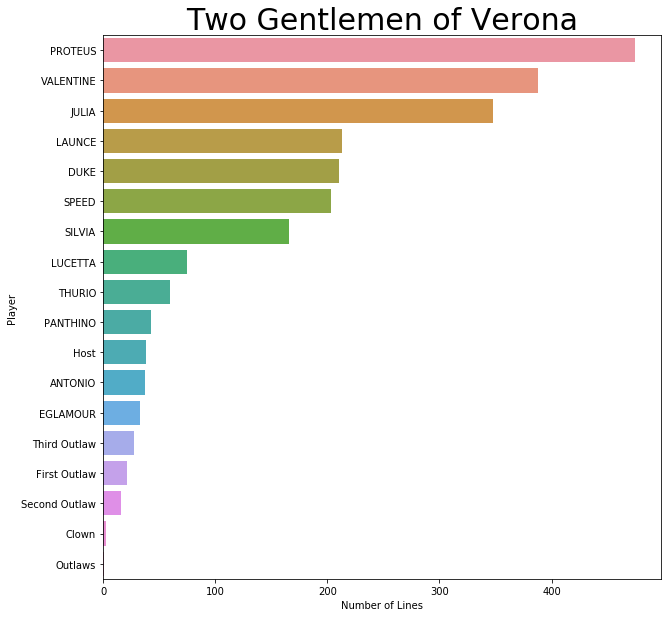

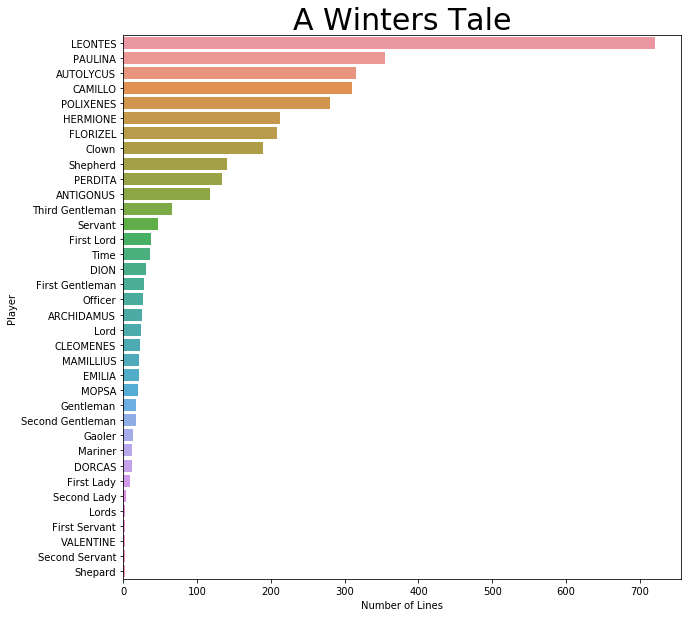

In [201]:
play_name = df['Play'].unique().tolist()
for play in play_name:
    p_line = df[df['Play']==play].groupby('Player').count().sort_values(by='PlayerLine',ascending=False)['PlayerLine']
    p_line = p_line.to_frame()
    p_line['Player'] = p_line.index.tolist()
    p_line.index = np.arange(0,len(p_line))
    p_line.columns=['Lines','Player']
    plt.figure(figsize=(10,10))
    ax= sns.barplot(x='Lines',y='Player',data=p_line)
    ax.set(xlabel='Number of Lines', ylabel='Player')
    plt.title(play,fontsize=30)
    plt.show()

<a id='GraphAnalysis'></a>

## 4.2 Graph Analysis and Central Measures

### Visualizing the plays as a network

In [202]:
g= nx.Graph()

In [203]:
g = nx.from_pandas_dataframe(df,source='Play',target='Player')

In [204]:
print (nx.info(g))

Name: 
Type: Graph
Number of nodes: 971
Number of edges: 1328
Average degree:   2.7353


* There are a total of 971 players across all the plays which converts to a total of 971 nodes. 
* Total number of edges between 971 players is 1328.
* We will be plotting entire network, which will give us a sense of the play and the players connected to them.

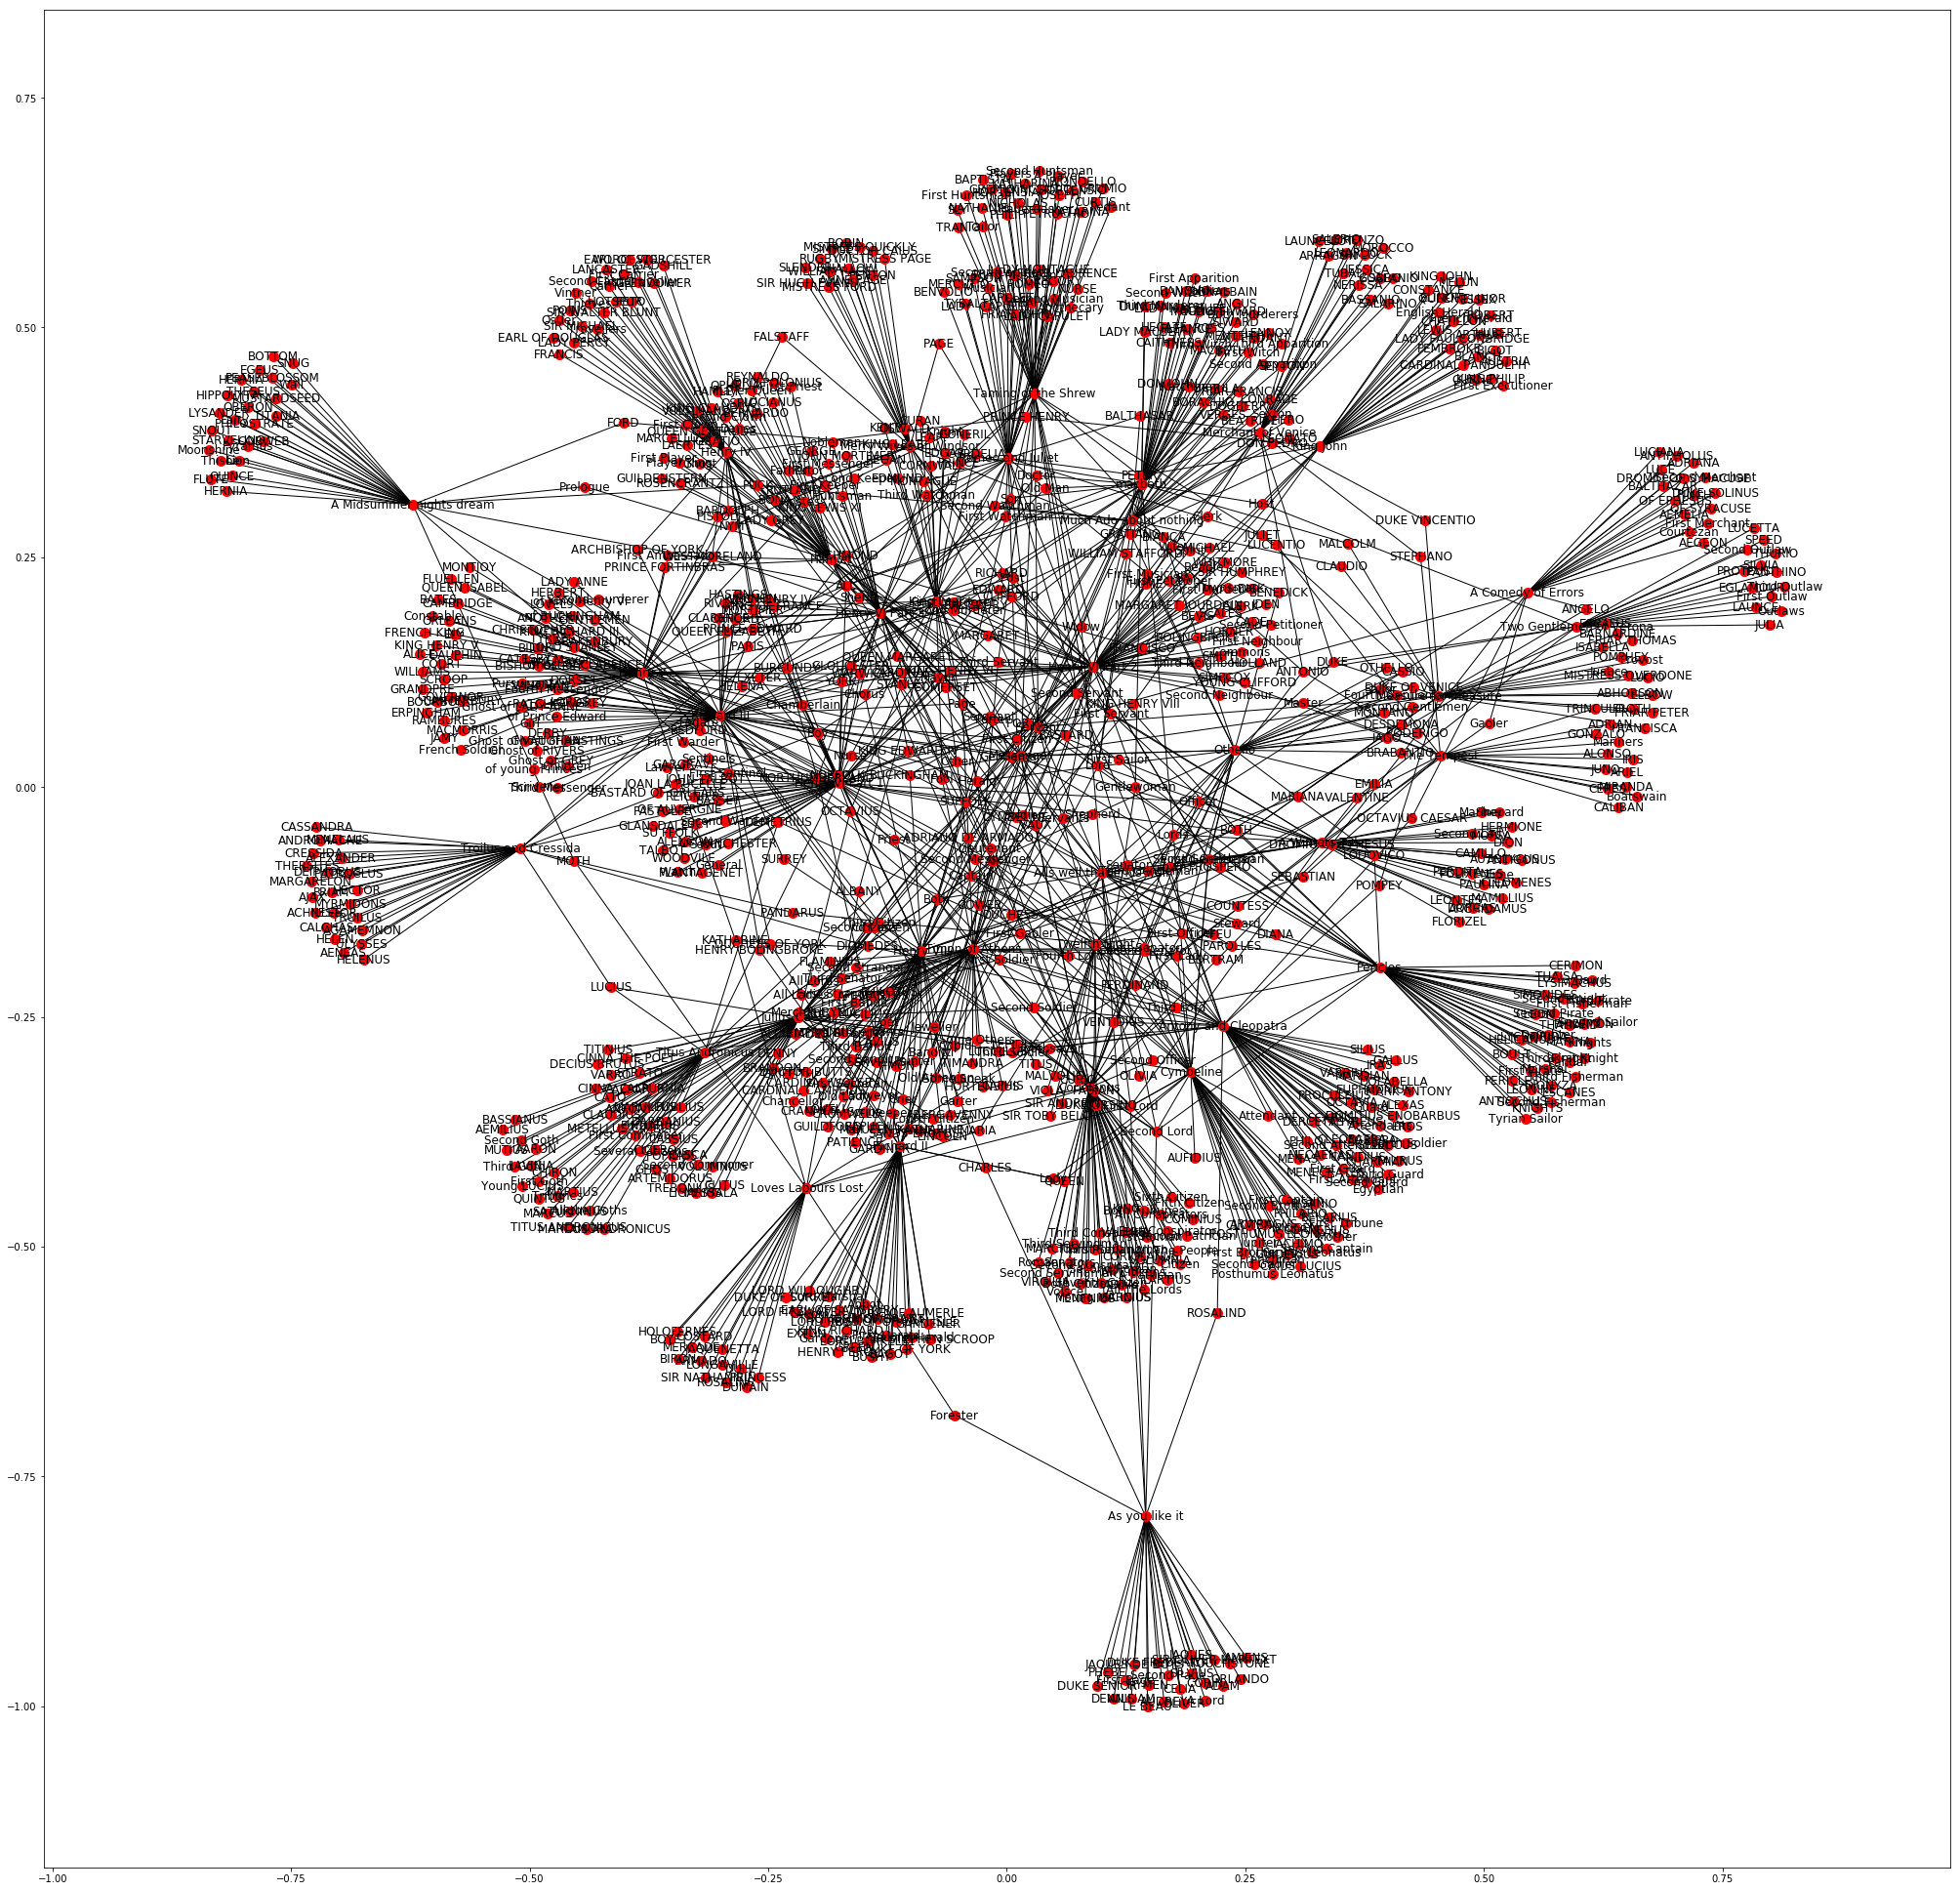

In [205]:
plt.figure(figsize=(35,35)) 
nx.draw_networkx(g,with_labels=True,node_size=100)
plt.show()

## Lets do Network Analysis

* Degree centrality for a particular node is the fraction of nodes it is connected to. 
* The degree centrality values are normalized by dividing by the maximum possible degree in a simple graph n-1 where n is the number of nodes in Graph.



* PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links.
* It was originally designed as an algorithm to rank web pages.

In [206]:
centralMeasures = pd.DataFrame(nx.degree_centrality(g),index=[0]).T
centralMeasures.columns=['Degree Centrality']
centralMeasures['Page Rank']= pd.DataFrame(nx.pagerank(g),index=[0]).T
centralMeasures['Name']= centralMeasures.index.tolist()
centralMeasures.index = np.arange(0,len(centralMeasures))
centralMeasures

Degree Centrality  Page Rank                      Name
0             0.021649   0.008255        A Comedy of Errors
1             0.001031   0.000500                    A Lord
2             0.031959   0.012699  A Midsummer nights dream
3             0.001031   0.000443               A Patrician
4             0.001031   0.000453                  A Player
5             0.037113   0.011904            A Winters Tale
6             0.001031   0.000469                     AARON
7             0.001031   0.000440               ABERGAVENNY
8             0.001031   0.000450                  ABHORSON
9             0.001031   0.000443                   ABRAHAM
10            0.001031   0.000489                  ACHILLES
11            0.001031   0.000500                      ADAM
12            0.001031   0.000479                    ADRIAN
13            0.001031   0.000488                   ADRIANA
14            0.002062   0.000787         ADRIANO DE ARMADO
15            0.001031   0.000488                    AEGEON
16            0.001031   0.000488                   AEMELIA
17            0.001031   0.000469                  AEMILIUS
18            0.001031   0.000489                    AENEAS
19            0.001031   0.000443                    AEdile
20            0.001031   0.000489                 AGAMEMNON
21            0.001031   0.000458                   AGRIPPA
22            0.001031   0.000489                      AJAX
23            0.002062   0.000758                    ALBANY
24            0.002062   0.000754                ALCIBIADES
25            0.001031   0.000431                   ALENCON
26            0.001031   0.000489                 ALEXANDER
27            0.001031   0.000458                    ALEXAS
28            0.001031   0.000439                     ALICE
29            0.008247   0.002578                       ALL
..                 ...        ...                       ...
941           0.001031   0.000443                  VIRGILIA
942           0.001031   0.000464                 VOLTIMAND
943           0.001031   0.000443                  VOLUMNIA
944           0.001031   0.000452                 VOLUMNIUS
945           0.001031   0.000457                   Vintner
946           0.001031   0.000443                    Volsce
947           0.004124   0.001247                   WARWICK
948           0.003093   0.001000              WESTMORELAND
949           0.001031   0.000427                  WHITMORE
950           0.001031   0.000500                   WILLIAM
951           0.001031   0.000449              WILLIAM PAGE
952           0.001031   0.000427          WILLIAM STAFFORD
953           0.001031   0.000439                  WILLIAMS
954           0.001031   0.000431                  WOODVILE
955           0.001031   0.000457                 WORCESTER
956           0.001031   0.000502                      Wall
957           0.001031   0.000431                     Watch
958           0.001031   0.000450                  Watchman
959           0.002062   0.000704                     Widow
960           0.001031   0.000427                      Wife
961           0.005155   0.001528                      YORK
962           0.001031   0.000427            YOUNG CLIFFORD
963           0.001031   0.000460              YOUNG SIWARD
964           0.001031   0.000469              Young LUCIUS
965           0.001031   0.000443             Young MARCIUS
966           0.043299   0.015130                   macbeth
967           0.001031   0.000436             of BUCKINGHAM
968           0.001031   0.000436          of King Henry VI
969           0.001031   0.000436          of Prince Edward
970           0.001031   0.000436          of young Princes

[971 rows x 3 columns]

* Let us sort by descending level of degree centrality. As we can see, the character "Messenger" has the highest Degree Centrality.

In [207]:
centralMeasures[centralMeasures['Name'].isin(df['Player'].unique().tolist())].sort_values(by='Degree Centrality',ascending=False)

Degree Centrality  Page Rank                Name
609           0.022680   0.006576           Messenger
845           0.020619   0.006075             Servant
58            0.015464   0.004496                 All
190           0.009278   0.002794             Captain
340           0.008247   0.002487       First Servant
313           0.008247   0.002397     First Gentleman
809           0.008247   0.002397    Second Gentleman
321           0.008247   0.002521          First Lord
29            0.008247   0.002578                 ALL
547           0.008247   0.002546                Lord
833           0.007216   0.002183      Second Servant
199           0.007216   0.002188               Clown
391           0.007216   0.002109           Gentleman
306           0.006186   0.001917       First Citizen
125           0.006186   0.001911                 Boy
369           0.006186   0.001806          GLOUCESTER
818           0.006186   0.001914         Second Lord
438           0.005155   0.001545              Herald
855           0.005155   0.001551             Soldier
342           0.005155   0.001572       First Soldier
121           0.005155   0.001547                Both
41            0.005155   0.001693             ANTONIO
961           0.005155   0.001528                YORK
338           0.004124   0.001279       First Senator
236           0.004124   0.001334                DUKE
835           0.004124   0.001296      Second Soldier
641           0.004124   0.001334             Officer
661           0.004124   0.001347               PETER
947           0.004124   0.001247             WARWICK
550           0.004124   0.001314               Lords
..                 ...        ...                 ...
395           0.001031   0.000436       Ghost of GREY
396           0.001031   0.000436   Ghost of HASTINGS
397           0.001031   0.000436  Ghost of LADY ANNE
368           0.001031   0.000457           GLENDOWER
366           0.001031   0.000452               GHOST
333           0.001031   0.000464        First Player
352           0.001031   0.000422    Fourth Gentleman
334           0.001031   0.000464        First Priest
335           0.001031   0.000443         First Roman
337           0.001031   0.000440     First Secretary
339           0.001031   0.000431      First Sentinel
341           0.001031   0.000443    First Servingman
343           0.001031   0.000439      First Stranger
344           0.001031   0.000457     First Traveller
345           0.001031   0.000439       First Tribune
346           0.001031   0.000431        First Warder
348           0.001031   0.000460         First Witch
354           0.001031   0.000436    Fourth Messenger
365           0.001031   0.000414              GEORGE
355           0.001031   0.000458      Fourth Soldier
356           0.001031   0.000487       French Herald
357           0.001031   0.000439      French Soldier
358           0.001031   0.000439           Frenchman
359           0.001031   0.000457            GADSHILL
360           0.001031   0.000458              GALLUS
361           0.001031   0.000468            GARDENER
362           0.001031   0.000440            GARDINER
363           0.001031   0.000431            GARGRAVE
364           0.001031   0.000436           GENTLEMEN
970           0.001031   0.000436    of young Princes

[935 rows x 3 columns]

* If we sort by Page rank in a descending order, we will get the centrality measures only for Players(or actors).
* Again by Page Rank too, the character "Messenger" is the most influential and we can see other actors too as shown below

In [208]:
#Centrality measures only for players (or actors)
centralMeasures[centralMeasures['Name'].isin(df['Player'].unique().tolist())].sort_values(by='Page Rank',ascending=False)

Degree Centrality  Page Rank              Name
609           0.022680   0.006576         Messenger
845           0.020619   0.006075           Servant
58            0.015464   0.004496               All
190           0.009278   0.002794           Captain
29            0.008247   0.002578               ALL
547           0.008247   0.002546              Lord
321           0.008247   0.002521        First Lord
340           0.008247   0.002487     First Servant
809           0.008247   0.002397  Second Gentleman
313           0.008247   0.002397   First Gentleman
199           0.007216   0.002188             Clown
833           0.007216   0.002183    Second Servant
391           0.007216   0.002109         Gentleman
306           0.006186   0.001917     First Citizen
818           0.006186   0.001914       Second Lord
125           0.006186   0.001911               Boy
369           0.006186   0.001806        GLOUCESTER
41            0.005155   0.001693           ANTONIO
342           0.005155   0.001572     First Soldier
855           0.005155   0.001551           Soldier
121           0.005155   0.001547              Both
438           0.005155   0.001545            Herald
961           0.005155   0.001528              YORK
661           0.004124   0.001347             PETER
236           0.004124   0.001334              DUKE
641           0.004124   0.001334           Officer
746           0.004124   0.001320         SALISBURY
550           0.004124   0.001314             Lords
835           0.004124   0.001296    Second Soldier
820           0.004124   0.001287  Second Messenger
..                 ...        ...               ...
422           0.001031   0.000427            HORNER
810           0.001031   0.000422  Second Gentlemen
590           0.001031   0.000422           MONTANO
110           0.001031   0.000422         BRABANTIO
639           0.001031   0.000422           OTHELLO
731           0.001031   0.000422          RODERIGO
443           0.001031   0.000422              IAGO
146           0.001031   0.000422            CASSIO
792           0.001031   0.000422            Sailor
216           0.001031   0.000422         DESDEMONA
240           0.001031   0.000422    DUKE OF VENICE
352           0.001031   0.000422  Fourth Gentleman
297           0.001031   0.000414            Father
103           0.001031   0.000414              BONA
622           0.001031   0.000414          Nobleman
494           0.001031   0.000414         LADY GREY
479           0.001031   0.000414     KING LEWIS XI
455           0.001031   0.000414     JOHN MORTIMER
441           0.001031   0.000414          Huntsman
815           0.001031   0.000414     Second Keeper
738           0.001031   0.000414           RUTLAND
365           0.001031   0.000414            GEORGE
323           0.001031   0.000414   First Messenger
318           0.001031   0.000414      First Keeper
924           0.001031   0.000414             Tutor
653           0.001031   0.000406          PAROLLES
92            0.001031   0.000406           BERTRAM
181           0.001031   0.000406          COUNTESS
500           0.001031   0.000406             LAFEU
862           0.001031   0.000406           Steward

[935 rows x 3 columns]

### The actor "Messenger" spoke a total of 508 lines across all the plays

In [209]:
#getting the number of lines a messenger spoke across all the plays
df[df['Player']=='Messenger']['PlayerLine'].count()

508

### Lets find Degree Centrality and Page Rank for all the plays and then sort them in descending order by 'Degree Centrality'

* As we can see from the result, "Richard III" is the most influential plot and "Two Gentleman of Verona" least influential. 

In [210]:
centralMeasures[centralMeasures['Name'].isin(df['Play'].unique().tolist())].sort_values(by='Degree Centrality',ascending=False)

Degree Centrality  Page Rank                      Name
740           0.073196   0.023528               Richard III
435           0.067010   0.020893           Henry VI Part 2
202           0.063918   0.021069                Coriolanus
918           0.056701   0.018453           Timon of Athens
68            0.056701   0.019671      Antony and Cleopatra
434           0.054639   0.017234           Henry VI Part 1
463           0.052577   0.017871             Julius Caesar
699           0.049485   0.017188                  Pericles
433           0.048454   0.015721                   Henry V
437           0.048454   0.015826                Henry VIII
436           0.047423   0.014047           Henry VI Part 3
206           0.043299   0.014070                 Cymbeline
966           0.043299   0.015130                   macbeth
889           0.039175   0.013343       Taming of the Shrew
742           0.038144   0.012592          Romeo and Juliet
739           0.038144   0.013661                Richard II
432           0.037113   0.012812                  Henry IV
5             0.037113   0.011904            A Winters Tale
431           0.036082   0.012750                    Hamlet
2             0.031959   0.012699  A Midsummer nights dream
486           0.029897   0.011367                 King John
923           0.029897   0.011414      Troilus and Cressida
646           0.029897   0.009122                   Othello
919           0.028866   0.010376          Titus Andronicus
70            0.028866   0.011397            As you like it
487           0.027835   0.008830                 King Lear
67            0.026804   0.007711  Alls well that ends well
605           0.026804   0.009044       Measure for measure
608           0.025773   0.008675    Merry Wives of Windsor
607           0.024742   0.008589        Merchant of Venice
612           0.024742   0.008343    Much Ado about nothing
0             0.021649   0.008255        A Comedy of Errors
551           0.021649   0.008066        Loves Labours Lost
890           0.020619   0.007645               The Tempest
925           0.019588   0.006413             Twelfth Night
926           0.018557   0.006960   Two Gentlemen of Verona

### Sorting by 'Page Rank' also give Richard III as the most influential play.

In [211]:
centralMeasures[centralMeasures['Name'].isin(df['Play'].unique().tolist())].sort_values(by='Page Rank',ascending=False)

Degree Centrality  Page Rank                      Name
740           0.073196   0.023528               Richard III
202           0.063918   0.021069                Coriolanus
435           0.067010   0.020893           Henry VI Part 2
68            0.056701   0.019671      Antony and Cleopatra
918           0.056701   0.018453           Timon of Athens
463           0.052577   0.017871             Julius Caesar
434           0.054639   0.017234           Henry VI Part 1
699           0.049485   0.017188                  Pericles
437           0.048454   0.015826                Henry VIII
433           0.048454   0.015721                   Henry V
966           0.043299   0.015130                   macbeth
206           0.043299   0.014070                 Cymbeline
436           0.047423   0.014047           Henry VI Part 3
739           0.038144   0.013661                Richard II
889           0.039175   0.013343       Taming of the Shrew
432           0.037113   0.012812                  Henry IV
431           0.036082   0.012750                    Hamlet
2             0.031959   0.012699  A Midsummer nights dream
742           0.038144   0.012592          Romeo and Juliet
5             0.037113   0.011904            A Winters Tale
923           0.029897   0.011414      Troilus and Cressida
70            0.028866   0.011397            As you like it
486           0.029897   0.011367                 King John
919           0.028866   0.010376          Titus Andronicus
646           0.029897   0.009122                   Othello
605           0.026804   0.009044       Measure for measure
487           0.027835   0.008830                 King Lear
608           0.025773   0.008675    Merry Wives of Windsor
607           0.024742   0.008589        Merchant of Venice
612           0.024742   0.008343    Much Ado about nothing
0             0.021649   0.008255        A Comedy of Errors
551           0.021649   0.008066        Loves Labours Lost
67            0.026804   0.007711  Alls well that ends well
890           0.020619   0.007645               The Tempest
926           0.018557   0.006960   Two Gentlemen of Verona
925           0.019588   0.006413             Twelfth Night

<a id='Clustering'></a>




# 5.0 Clustering

<a id='DataPreparation'></a>


## 5.1 Initial Data Preparation and Analysis

In [212]:
nltk.download("stopwords")
nltk.download("brown")
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import brown

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rkheruwa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package brown to /Users/rkheruwa/nltk_data...
[nltk_data]   Package brown is already up-to-date!


## Let us do webscraping again to suit the clustering related task and define each methods individually 

In [213]:
# Creation of text files for entire poems and plays 
def create_meta_text_files(resultURLs):
    k = 0
    for i in resultURLs:
        if len(i) > 1:
            for j in i:
                urltemp = url + j
                html = urlopen(urltemp)
                bsObj = BeautifulSoup(html)
                if 'full' in j:
                    name = j[0:j.find('/')]
                else: 
                    name = j[j.find('/')+1:len(j)-5]
                name = resultURLs[k-4][0].lower() + '_' + name + '.txt'
                print (resultURLs[k-4][0], url+j, name)
                with open(name, 'w') as file:
                    file.write(bsObj.get_text())
        k += 1

In [214]:
# Creation text files for entire poems and plays by scene
def create_all_text_files(resultURLs, full_play):
    exclude = ['amazon', 'Shakespeare', 'full']
    k = 0
    for i in resultURLs:
        if len(i) > 1:
            for j in i:
                urltemp = url + j
                html = urlopen(urltemp)
                bsObj = BeautifulSoup(html)
                if 'index' in j:
                    linkname = j[0:j.find('/')]
                else: 
                    linkname = j[j.find('/')+1:len(j)-5]
                name = resultURLs[k-4][0].lower() + '__' + linkname + '.txt'
                if full_play or (('Poetry' in resultURLs[k-4][0]) and ('sonnet' not in j)):
                    with open(name, 'w') as file:
                        print (resultURLs[k-4][0], url+j, name)
                        file.write(bsObj.get_text())
                for link in bsObj.findAll('a', href=True):
                    if not any(x in str(link['href']) for x in exclude):
                        sublink = str(link['href'])
                        sublink = sublink[0:len(sublink)-5]
                        subname = resultURLs[k-4][0].lower() + '__' + linkname + '__' + sublink.lower() + '.txt'
                        if 'sonnet' in link['href']:
                            suburltemp = url+'/'+ resultURLs[k-4][0] + '/' + link['href']
                        else: 
                            suburltemp = url+linkname+'/'+link['href']
                        print(resultURLs[k-4][0], suburltemp, subname)
                        html = urlopen(suburltemp)
                        bsObj = BeautifulSoup(html)
                        with open(subname, 'w') as file:
                          file.write(bsObj.get_text())
        k += 1        




In [215]:
# Creation of a two-dimensional array of all plays and poems with their genres
def makeTitleList(table):
    result = []
    allrows = table.findAll('tr')
    for row in allrows:
        allcols = row.findAll('td')
        for col in allcols:
            colresult = []
            for cell in (col.findAll('a') or col.findAll('h2')):
                colresult.append(cell.text.strip('\n'))
            result.append(colresult)
    return result

In [216]:
# Creation of a two-dimensional array of all plays and poems' URLs with their genres
def makeURLList(table, full_play):
    result = []
    allrows = table.findAll('tr')
    for row in allrows:
        allcols = row.findAll('td')
        for col in allcols:
            colresult = []
            if (len(col.findAll('h2')) > 0):
                for cell in (col.findAll('a') or col.findAll('h2')):
                    colresult.append(cell.text.strip('\n'))
            else:
                for cell in col.findAll('a', href=True):
                    temp = str(cell['href'])
                    if full_play:
                        full = temp.replace('index', 'full')
                    else: 
                        full = temp
                    colresult.append(full)
            result.append(colresult)
    return result

## Choosing same shakespeare.mit.edu data and these will create individual files for all of the plays across all the genres. 

In [217]:
url = "http://shakespeare.mit.edu/"
html = urlopen(url)
bsObj = BeautifulSoup(html)
resultTitles = makeTitleList(bsObj('table')[1])
print("resultTitles : ", resultTitles)
resultURLs = makeURLList(bsObj('table')[1], False)
print("resultURLs : " , resultURLs)
create_all_text_files(resultURLs, True)

/Users/rkheruwa/anaconda/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/rkheruwa/anaconda/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


resultTitles :  [['Comedy'], ['History'], ['Tragedy'], ['Poetry'], ["All's Well That Ends Well", 'As You Like It', 'The Comedy of Errors', 'Cymbeline', "Love's Labours Lost", 'Measure for Measure', 'The\nMerry Wives of Windsor', 'The Merchant of Venice', "A Midsummer Night's Dream", 'Much Ado About Nothing', 'Pericles, Prince of Tyre', 'Taming of the Shrew', 'The Tempest', 'Troilus and Cressida', 'Twelfth Night', 'Two Gentlemen of Verona', "Winter's Tale"], ['Henry IV, part 1', 'Henry IV, part 2', 'Henry V', 'Henry VI, part 1', 'Henry VI, part 2', 'Henry VI, part 3', 'Henry VIII', 'King John', 'Richard II', 'Richard III'], ['Antony and Cleopatra', 'Coriolanus', 'Hamlet', 'Julius Caesar', 'King Lear', 'Macbeth', 'Othello', 'Romeo and Juliet', 'Timon of Athens', 'Titus Andronicus'], ['The Sonnets', "A Lover's Complaint", 'The Rape of Lucrece', 'Venus and Adonis', 'Funeral Elegy by W.S.']]
resultURLs :  [['Comedy'], ['History'], ['Tragedy'], ['Poetry'], ['allswell/index.html', 'asyoulikei

Comedy http://shakespeare.mit.edu/cymbeline/cymbeline.1.2.html comedy__cymbeline__cymbeline.1.2.txt
Comedy http://shakespeare.mit.edu/cymbeline/cymbeline.1.3.html comedy__cymbeline__cymbeline.1.3.txt
Comedy http://shakespeare.mit.edu/cymbeline/cymbeline.1.4.html comedy__cymbeline__cymbeline.1.4.txt
Comedy http://shakespeare.mit.edu/cymbeline/cymbeline.1.5.html comedy__cymbeline__cymbeline.1.5.txt
Comedy http://shakespeare.mit.edu/cymbeline/cymbeline.1.6.html comedy__cymbeline__cymbeline.1.6.txt
Comedy http://shakespeare.mit.edu/cymbeline/cymbeline.2.1.html comedy__cymbeline__cymbeline.2.1.txt
Comedy http://shakespeare.mit.edu/cymbeline/cymbeline.2.2.html comedy__cymbeline__cymbeline.2.2.txt
Comedy http://shakespeare.mit.edu/cymbeline/cymbeline.2.4.html comedy__cymbeline__cymbeline.2.4.txt
Comedy http://shakespeare.mit.edu/cymbeline/cymbeline.2.5.html comedy__cymbeline__cymbeline.2.5.txt
Comedy http://shakespeare.mit.edu/cymbeline/cymbeline.3.1.html comedy__cymbeline__cymbeline.3.1.txt


Comedy http://shakespeare.mit.edu/merchant/merchant.2.5.html comedy__merchant__merchant.2.5.txt
Comedy http://shakespeare.mit.edu/merchant/merchant.2.6.html comedy__merchant__merchant.2.6.txt
Comedy http://shakespeare.mit.edu/merchant/merchant.2.7.html comedy__merchant__merchant.2.7.txt
Comedy http://shakespeare.mit.edu/merchant/merchant.2.8.html comedy__merchant__merchant.2.8.txt
Comedy http://shakespeare.mit.edu/merchant/merchant.2.9.html comedy__merchant__merchant.2.9.txt
Comedy http://shakespeare.mit.edu/merchant/merchant.3.1.html comedy__merchant__merchant.3.1.txt
Comedy http://shakespeare.mit.edu/merchant/merchant.3.2.html comedy__merchant__merchant.3.2.txt
Comedy http://shakespeare.mit.edu/merchant/merchant.3.3.html comedy__merchant__merchant.3.3.txt
Comedy http://shakespeare.mit.edu/merchant/merchant.3.4.html comedy__merchant__merchant.3.4.txt
Comedy http://shakespeare.mit.edu/merchant/merchant.3.5.html comedy__merchant__merchant.3.5.txt
Comedy http://shakespeare.mit.edu/mercha

Comedy http://shakespeare.mit.edu/tempest/tempest.4.1.html comedy__tempest__tempest.4.1.txt
Comedy http://shakespeare.mit.edu/tempest/tempest.5.1.html comedy__tempest__tempest.5.1.txt
Comedy http://shakespeare.mit.edu/troilus_cressida/index.html comedy__troilus_cressida.txt
Comedy http://shakespeare.mit.edu/troilus_cressida/troilus_cressida.1.1.html comedy__troilus_cressida__troilus_cressida.1.1.txt
Comedy http://shakespeare.mit.edu/troilus_cressida/troilus_cressida.1.2.html comedy__troilus_cressida__troilus_cressida.1.2.txt
Comedy http://shakespeare.mit.edu/troilus_cressida/troilus_cressida.1.3.html comedy__troilus_cressida__troilus_cressida.1.3.txt
Comedy http://shakespeare.mit.edu/troilus_cressida/troilus_cressida.2.1.html comedy__troilus_cressida__troilus_cressida.2.1.txt
Comedy http://shakespeare.mit.edu/troilus_cressida/troilus_cressida.2.2.html comedy__troilus_cressida__troilus_cressida.2.2.txt
Comedy http://shakespeare.mit.edu/troilus_cressida/troilus_cressida.2.3.html comedy__

Comedy http://shakespeare.mit.edu/winters_tale/winters_tale.2.1.html comedy__winters_tale__winters_tale.2.1.txt
Comedy http://shakespeare.mit.edu/winters_tale/winters_tale.2.2.html comedy__winters_tale__winters_tale.2.2.txt
Comedy http://shakespeare.mit.edu/winters_tale/winters_tale.2.3.html comedy__winters_tale__winters_tale.2.3.txt
Comedy http://shakespeare.mit.edu/winters_tale/winters_tale.3.1.html comedy__winters_tale__winters_tale.3.1.txt
Comedy http://shakespeare.mit.edu/winters_tale/winters_tale.3.2.html comedy__winters_tale__winters_tale.3.2.txt
Comedy http://shakespeare.mit.edu/winters_tale/winters_tale.3.3.html comedy__winters_tale__winters_tale.3.3.txt
Comedy http://shakespeare.mit.edu/winters_tale/winters_tale.4.2.html comedy__winters_tale__winters_tale.4.2.txt
Comedy http://shakespeare.mit.edu/winters_tale/winters_tale.4.3.html comedy__winters_tale__winters_tale.4.3.txt
Comedy http://shakespeare.mit.edu/winters_tale/winters_tale.4.4.html comedy__winters_tale__winters_tale.

History http://shakespeare.mit.edu/1henryvi/1henryvi.1.4.html history__1henryvi__1henryvi.1.4.txt
History http://shakespeare.mit.edu/1henryvi/1henryvi.1.5.html history__1henryvi__1henryvi.1.5.txt
History http://shakespeare.mit.edu/1henryvi/1henryvi.1.6.html history__1henryvi__1henryvi.1.6.txt
History http://shakespeare.mit.edu/1henryvi/1henryvi.2.1.html history__1henryvi__1henryvi.2.1.txt
History http://shakespeare.mit.edu/1henryvi/1henryvi.2.2.html history__1henryvi__1henryvi.2.2.txt
History http://shakespeare.mit.edu/1henryvi/1henryvi.2.3.html history__1henryvi__1henryvi.2.3.txt
History http://shakespeare.mit.edu/1henryvi/1henryvi.2.4.html history__1henryvi__1henryvi.2.4.txt
History http://shakespeare.mit.edu/1henryvi/1henryvi.2.5.html history__1henryvi__1henryvi.2.5.txt
History http://shakespeare.mit.edu/1henryvi/1henryvi.3.1.html history__1henryvi__1henryvi.3.1.txt
History http://shakespeare.mit.edu/1henryvi/1henryvi.3.2.html history__1henryvi__1henryvi.3.2.txt
History http://shake

History http://shakespeare.mit.edu/henryviii/henryviii.2.2.html history__henryviii__henryviii.2.2.txt
History http://shakespeare.mit.edu/henryviii/henryviii.2.3.html history__henryviii__henryviii.2.3.txt
History http://shakespeare.mit.edu/henryviii/henryviii.2.4.html history__henryviii__henryviii.2.4.txt
History http://shakespeare.mit.edu/henryviii/henryviii.3.1.html history__henryviii__henryviii.3.1.txt
History http://shakespeare.mit.edu/henryviii/henryviii.3.2.html history__henryviii__henryviii.3.2.txt
History http://shakespeare.mit.edu/henryviii/henryviii.4.1.html history__henryviii__henryviii.4.1.txt
History http://shakespeare.mit.edu/henryviii/henryviii.4.2.html history__henryviii__henryviii.4.2.txt
History http://shakespeare.mit.edu/henryviii/henryviii.5.1.html history__henryviii__henryviii.5.1.txt
History http://shakespeare.mit.edu/henryviii/henryviii.5.2.html history__henryviii__henryviii.5.2.txt
History http://shakespeare.mit.edu/henryviii/henryviii.5.3.html history__henryviii

Tragedy http://shakespeare.mit.edu/cleopatra/cleopatra.2.5.html tragedy__cleopatra__cleopatra.2.5.txt
Tragedy http://shakespeare.mit.edu/cleopatra/cleopatra.2.6.html tragedy__cleopatra__cleopatra.2.6.txt
Tragedy http://shakespeare.mit.edu/cleopatra/cleopatra.2.7.html tragedy__cleopatra__cleopatra.2.7.txt
Tragedy http://shakespeare.mit.edu/cleopatra/cleopatra.3.1.html tragedy__cleopatra__cleopatra.3.1.txt
Tragedy http://shakespeare.mit.edu/cleopatra/cleopatra.3.2.html tragedy__cleopatra__cleopatra.3.2.txt
Tragedy http://shakespeare.mit.edu/cleopatra/cleopatra.3.3.html tragedy__cleopatra__cleopatra.3.3.txt
Tragedy http://shakespeare.mit.edu/cleopatra/cleopatra.3.4.html tragedy__cleopatra__cleopatra.3.4.txt
Tragedy http://shakespeare.mit.edu/cleopatra/cleopatra.3.5.html tragedy__cleopatra__cleopatra.3.5.txt
Tragedy http://shakespeare.mit.edu/cleopatra/cleopatra.3.6.html tragedy__cleopatra__cleopatra.3.6.txt
Tragedy http://shakespeare.mit.edu/cleopatra/cleopatra.3.7.html tragedy__cleopatra

Tragedy http://shakespeare.mit.edu/hamlet/hamlet.5.1.html tragedy__hamlet__hamlet.5.1.txt
Tragedy http://shakespeare.mit.edu/hamlet/hamlet.5.2.html tragedy__hamlet__hamlet.5.2.txt
Tragedy http://shakespeare.mit.edu/julius_caesar/index.html tragedy__julius_caesar.txt
Tragedy http://shakespeare.mit.edu/julius_caesar/julius_caesar.1.1.html tragedy__julius_caesar__julius_caesar.1.1.txt
Tragedy http://shakespeare.mit.edu/julius_caesar/julius_caesar.1.2.html tragedy__julius_caesar__julius_caesar.1.2.txt
Tragedy http://shakespeare.mit.edu/julius_caesar/julius_caesar.1.3.html tragedy__julius_caesar__julius_caesar.1.3.txt
Tragedy http://shakespeare.mit.edu/julius_caesar/julius_caesar.2.1.html tragedy__julius_caesar__julius_caesar.2.1.txt
Tragedy http://shakespeare.mit.edu/julius_caesar/julius_caesar.2.2.html tragedy__julius_caesar__julius_caesar.2.2.txt
Tragedy http://shakespeare.mit.edu/julius_caesar/julius_caesar.2.3.html tragedy__julius_caesar__julius_caesar.2.3.txt
Tragedy http://shakespear

Tragedy http://shakespeare.mit.edu/othello/othello.3.4.html tragedy__othello__othello.3.4.txt
Tragedy http://shakespeare.mit.edu/othello/othello.4.1.html tragedy__othello__othello.4.1.txt
Tragedy http://shakespeare.mit.edu/othello/othello.4.2.html tragedy__othello__othello.4.2.txt
Tragedy http://shakespeare.mit.edu/othello/othello.4.3.html tragedy__othello__othello.4.3.txt
Tragedy http://shakespeare.mit.edu/othello/othello.5.1.html tragedy__othello__othello.5.1.txt
Tragedy http://shakespeare.mit.edu/othello/othello.5.2.html tragedy__othello__othello.5.2.txt
Tragedy http://shakespeare.mit.edu/romeo_juliet/index.html tragedy__romeo_juliet.txt
Tragedy http://shakespeare.mit.edu/romeo_juliet/romeo_juliet.1.0.html tragedy__romeo_juliet__romeo_juliet.1.0.txt
Tragedy http://shakespeare.mit.edu/romeo_juliet/romeo_juliet.1.1.html tragedy__romeo_juliet__romeo_juliet.1.1.txt
Tragedy http://shakespeare.mit.edu/romeo_juliet/romeo_juliet.1.2.html tragedy__romeo_juliet__romeo_juliet.1.2.txt
Tragedy h

Poetry http://shakespeare.mit.edu//Poetry/sonnet.XXI.html poetry__sonnets__sonnet.xxi.txt
Poetry http://shakespeare.mit.edu//Poetry/sonnet.XXII.html poetry__sonnets__sonnet.xxii.txt
Poetry http://shakespeare.mit.edu//Poetry/sonnet.XXIII.html poetry__sonnets__sonnet.xxiii.txt
Poetry http://shakespeare.mit.edu//Poetry/sonnet.XXIV.html poetry__sonnets__sonnet.xxiv.txt
Poetry http://shakespeare.mit.edu//Poetry/sonnet.XXV.html poetry__sonnets__sonnet.xxv.txt
Poetry http://shakespeare.mit.edu//Poetry/sonnet.XXVI.html poetry__sonnets__sonnet.xxvi.txt
Poetry http://shakespeare.mit.edu//Poetry/sonnet.XXVII.html poetry__sonnets__sonnet.xxvii.txt
Poetry http://shakespeare.mit.edu//Poetry/sonnet.XXVIII.html poetry__sonnets__sonnet.xxviii.txt
Poetry http://shakespeare.mit.edu//Poetry/sonnet.XXIX.html poetry__sonnets__sonnet.xxix.txt
Poetry http://shakespeare.mit.edu//Poetry/sonnet.XXX.html poetry__sonnets__sonnet.xxx.txt
Poetry http://shakespeare.mit.edu//Poetry/sonnet.XXXI.html poetry__sonnets__so

Poetry http://shakespeare.mit.edu//Poetry/sonnet.CXI.html poetry__sonnets__sonnet.cxi.txt
Poetry http://shakespeare.mit.edu//Poetry/sonnet.CXII.html poetry__sonnets__sonnet.cxii.txt
Poetry http://shakespeare.mit.edu//Poetry/sonnet.CXIII.html poetry__sonnets__sonnet.cxiii.txt
Poetry http://shakespeare.mit.edu//Poetry/sonnet.CXIV.html poetry__sonnets__sonnet.cxiv.txt
Poetry http://shakespeare.mit.edu//Poetry/sonnet.CXV.html poetry__sonnets__sonnet.cxv.txt
Poetry http://shakespeare.mit.edu//Poetry/sonnet.CXVI.html poetry__sonnets__sonnet.cxvi.txt
Poetry http://shakespeare.mit.edu//Poetry/sonnet.CXVII.html poetry__sonnets__sonnet.cxvii.txt
Poetry http://shakespeare.mit.edu//Poetry/sonnet.CXVIII.html poetry__sonnets__sonnet.cxviii.txt
Poetry http://shakespeare.mit.edu//Poetry/sonnet.CXIX.html poetry__sonnets__sonnet.cxix.txt
Poetry http://shakespeare.mit.edu//Poetry/sonnet.CXX.html poetry__sonnets__sonnet.cxx.txt
Poetry http://shakespeare.mit.edu//Poetry/sonnet.CXXI.html poetry__sonnets__so

In [218]:
# Using Snowball stemmer 
stemmer = SnowballStemmer("english")
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

In [219]:
# First we will tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
def tokenize_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    return tokens

# A tokenizer and stemmer which returns the set of stems in the text that it is passed
def tokenize_and_stem(text):
    # Tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    stems = [stemmer.stem(t) for t in tokens]
    return stems


# Return data frame containing tokenized text list, indexed by stemmed text list
def get_vocab_frame(text, verbose):
    totalvocab_stemmed = []
    totalvocab_tokenized = []
    totalvocab_stemmed = tokenize_and_stem(text) 
    totalvocab_tokenized = tokenize_only(text)
    vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
    if verbose:
        print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')
    return vocab_frame



In [220]:
# Matrix  of cosine similarity
def get_cosine_similarity(tfidf_matrix):
    dist = 1 - cosine_similarity(tfidf_matrix)
    return dist

In [221]:
# Vectorizer parameters
def get_tfidf_vectorizer():
    tfidf_vectorizer = TfidfVectorizer(max_df=0.999, max_features=200000,
                                        min_df=0.001, stop_words='english',
                                        use_idf=True, tokenizer=tokenize_and_stem, 
                                        ngram_range=(1,3))
    return tfidf_vectorizer

In [222]:
# tfidf matrix
def get_tfidf_matrix(tfidf_vectorizer, text):
    tfidf_matrix = tfidf_vectorizer.fit_transform(text) #fit the vectorizer to synopses
    return tfidf_matrix

In [223]:
# Feature names
def get_feature_names(tfidf_vectorizer):
    terms = tfidf_vectorizer.get_feature_names()
    return terms

In [224]:

# k-means clustering, return kmeans object
def get_kmeans(tfidf_matrix, num_clusters):
    km = KMeans(n_clusters=num_clusters)
    km.fit(tfidf_matrix)
    return km

In [225]:
# Cluster labels
def get_kmeans_clusters(km):
    clusters = km.labels_.tolist()
    return clusters

In [226]:
# using randomized PCA
def reduce_two_dim(train):
    rpca=RandomizedPCA(n_components=2)
    return rpca.fit_transform(train)    

In [227]:
def get_mini_batch_km(num_clusters):
    km = MiniBatchKMeans(n_clusters=num_clusters, init='k-means++', n_init=1,
                         init_size=1000,
                         batch_size=1000, verbose=1)
    return km

In [228]:
# Counting line functions
def countLines(ln):      
    return 1
def countBlankLines(ln): 
    return 0 if ln.strip() else 1
def countWords(ln):      
    return len(ln.split())

In [229]:
def charCounter(validChars):
    vc = set(validChars)
    def counter(ln):
        return sum(1 for ch in ln if ch in vc)
    return counter

In [230]:
countSentences = charCounter('.!?')
countLetters   = charCounter(string.ascii_letters)
countPunct     = charCounter(string.punctuation)



In [231]:
# compile file stats
class FileStats(object):
    def __init__(self, countFns, labels=None):
        super(FileStats,self).__init__()
        self.fns    = countFns
        self.labels = labels if labels else [fn.__name__ for fn in countFns]
        self.reset()

    def reset(self):
        self.counts = [0]*len(self.fns)

    def file_stats(self, fname):
        try:
            with open(fname) as inf:
                for line in inf:
                    for i,fn in enumerate(self.fns):
                        self.counts[i] += fn(line)
        except IOError:
            print('Could not open file {0} for reading'.format(fname))
        return (np.array(self.labels), self.counts)
    
            
    def __str__(self):
        return '\n'.join('{0:20} {1:>6}'.format(label, count) for label,count in zip(self.labels, self.counts))
    
stats = FileStats(
    (countLines, countBlankLines, countSentences, countWords, countLetters, countPunct),
    ("Lines",    "Blank Lines",   "Sentences",    "Words",    "Letters",    "Punctuation")
)



In [232]:
# Counting paragraphs
def count_paragraphs(file):
    f = open(file, 'r')
    paragraph = 0
    last_paragraph = 0
    lines = f.readlines()
    for idx, line in enumerate(lines):
        if not line == '\n':
            m = re.search(r'\w', line)
            str = m.group(0)
        try:
            # if the line is a newline, and the previous line has a str in it, then  
            # count it as a paragraph.
            if line == '\n' and str in lines[idx-1]: 
                paragraph +=1
        except:
            pass
    if lines[-1] != '\n': # if the last line is not a new line, count a paragraph.
        paragraph +=1
    
    counts = (paragraph, )
    labels = ("Paragraphs", "")
    return labels, counts

In [233]:
# Create a word count dictionary: key=word, value=count 
#(options: strip punction, strip stop words )
def create_wordcount_dict(file, strip_punc, strip_stop):
    counts = dict()
    stop = "."
    comma = ","
    counts[stop] = 0
    counts[comma] = 0
    with open(file, 'r') as fhand:
       for line in fhand:
            counts[stop] += max(0,line.find(stop))
            counts[comma] += max(0,line.find(comma))
            clean = ' '.join(filter(None, (word.strip(string.punctuation) for word in line.split())))
            words = clean.split()
            if strip_punc:
                words = [word.lower() for word in words if word not in string.punctuation]
            if strip_stop:
                words = [word.lower() for word in words if word not in stopwords.words('english')]
            for word in words:
                if word not in counts:
                    counts[word] = 1
                else:
                    counts[word] += 1
    return counts 

In [234]:
# Return feature words 
def get_feature_words(wordcount):
    stop_count = wordcount['.']
    comma_count = wordcount[',']
    and_count = wordcount['and']
    or_count = wordcount['or']
    a_count = wordcount['a']
    an_count = wordcount['an']
    the_count = wordcount['the']
    in_count = wordcount['in']
    on_count = wordcount['on']
    to_count = wordcount['to']
    of_count = wordcount['of']
    it_count = wordcount['it']
    that_count = wordcount['that']
    as_count = wordcount['as']
    is_count = wordcount['is']
    so_count = wordcount['so']
    counts = (stop_count, comma_count, and_count, or_count, a_count, 
              an_count, the_count, in_count, on_count, to_count, of_count,  
             it_count, that_count, as_count, is_count, so_count)
    labels = ("Stops", "Commas", "Count 'and'", "Count 'or'", "Count 'a'", 
              "Count 'an'", "Count 'the'", "Count 'in'", "Count 'on'", 
              "Count 'to'", "Count 'of'", "Count 'it'","Count 'that'",
              "Count 'as'", "Count 'is'", "Count 'so'")
    return labels, counts

In [235]:
# print words by clusters
def print_clusters(num_clusters, frame):
    print() #add whitespace
    print() #add whitespace
    for i in range(num_clusters):
        print("Cluster %d words:" % (i+1), end='')
        for word in frame.ix[i]['word'].values.tolist():
            try:
                print(' %s,' % word, end='')
            except:
                continue
        print() #add whitespace
        print() #add whitespace



In [236]:
# Compute Dissimilarity
def compute_dissimilarity(filenames):
    vectorizer = CountVectorizer(input='filename')               
    dtm = vectorizer.fit_transform(filenames)                            
    dtm = dtm.toarray()  
    dist = 1 - cosine_similarity(dtm)
    return dist



In [237]:
# Getting file names
def get_file_names(startswith, count_underscores):
    filenames = []   
    for file in os.listdir():
        if ((file.startswith(startswith)) and 
        (file.count('_') == count_underscores)):
            filenames.append(file)
    return filenames

In [238]:
gs = gridspec.GridSpec(3,2)
# Plot ALL (exclude the sonnets (too short))
filenames = get_file_names('tragedy__', 2)
print("filenames : ", filenames)
filenames.extend(get_file_names('poetry__', 2))
filenames.extend(get_file_names('history__', 2))
filenames.extend(get_file_names('comedy__', 2))
dist = compute_dissimilarity(filenames)
pos = mds.fit_transform(dist) 
xs, ys = pos[:, 0], pos[:, 1]
names = [fn.replace('.txt', '') for fn in filenames]

plt.figure(figsize=(15,15))
ax = plt.subplot(gs[0,:])
ax.set_title('Dissimilarities: tragedy = blue, poetry = black, history = red, comedy = orange')
for x, y, name in zip(xs, ys, names):
   
    if "tragedy" in name: color = 'blue' 
    if "poetry" in name: color = 'black' 
    if "history" in name: color = 'red'  
    if "comedy" in name: color = 'orange'
    plt.scatter(x, y, color=color, s=50)
    if x > -0.2 and x < -0.15:
        plt.text(x, y, name[name.find('_')+2:])
    if x > 0.2: 
        plt.text(x, y, name[name.find('_')+2:])
    if x == xs.min(): 
        plt.text(x, y, name[name.find('_')+2:])

filenames :  ['tragedy__cleopatra.txt', 'tragedy__coriolanus.txt', 'tragedy__hamlet.txt', 'tragedy__lear.txt', 'tragedy__macbeth.txt', 'tragedy__othello.txt', 'tragedy__timon.txt', 'tragedy__titus.txt']


In [239]:
# Plot TRAGEDIES
filenames = get_file_names('tragedy__', 2)
dist = compute_dissimilarity(filenames)
pos = mds.fit_transform(dist) 
xs, ys = pos[:, 0], pos[:, 1]
names = [fn.replace('.txt', '') for fn in filenames]
ax = plt.subplot(gs[1,0])
ax.set_title('Dissimilarities: tragedy = blue')
for x, y, name in zip(xs, ys, names):
    if "tragedy" in name: color = 'blue' 
    plt.scatter(x, y, color=color, s=50)
    if x == xs.min() or x == xs.max(): 
        plt.text(x, y, name[name.find('_')+2:])    

In [240]:
# Plot POETRY
filenames = get_file_names('poetry__', 2)
filenames.extend(get_file_names('poetry__', 4))
dist = compute_dissimilarity(filenames)
pos = mds.fit_transform(dist) 
xs, ys = pos[:, 0], pos[:, 1]
names = [fn.replace('.txt', '') for fn in filenames]
ax = plt.subplot(gs[1,1])
ax.set_title('Dissimilarities: poetry = black, sonnets = lightgrey')
for x, y, name in zip(xs, ys, names):
    if "poetry" in name: color = 'black'
    if "sonnet" in name: color = 'lightgrey'
    plt.scatter(x, y, color=color, s=50)
    if x == xs.min() or x == xs.max(): 
        plt.text(x, y, name[name.find('_')+2:])

In [241]:
# Plot HISTORIES
filenames = get_file_names('history__', 2)
dist = compute_dissimilarity(filenames)
pos = mds.fit_transform(dist) 
xs, ys = pos[:, 0], pos[:, 1]
names = [fn.replace('.txt', '') for fn in filenames]
ax = plt.subplot(gs[2,0])
ax.set_title('Dissimilarities: history = red')
for x, y, name in zip(xs, ys, names):
    if "history" in name: color = 'red'  
    plt.scatter(x, y, color=color, s=50)
    if x == xs.min() or x == xs.max(): 
        plt.text(x, y, name[name.find('_')+2:])
    

In [242]:
# Plot COMEDIES
filenames = get_file_names('comedy__', 2)
dist = compute_dissimilarity(filenames)
pos = mds.fit_transform(dist) 
xs, ys = pos[:, 0], pos[:, 1]
names = [fn.replace('.txt', '') for fn in filenames]
ax = plt.subplot(gs[2,1])
ax.set_title('Dissimilarities: comedy = orange')
for x, y, name in zip(xs, ys, names):
    if "comedy" in name: color = 'orange'
    plt.scatter(x, y, color=color, s=50)
    if x == xs.min() or x == xs.max(): 
        plt.text(x, y, name[name.find('_')+2:])

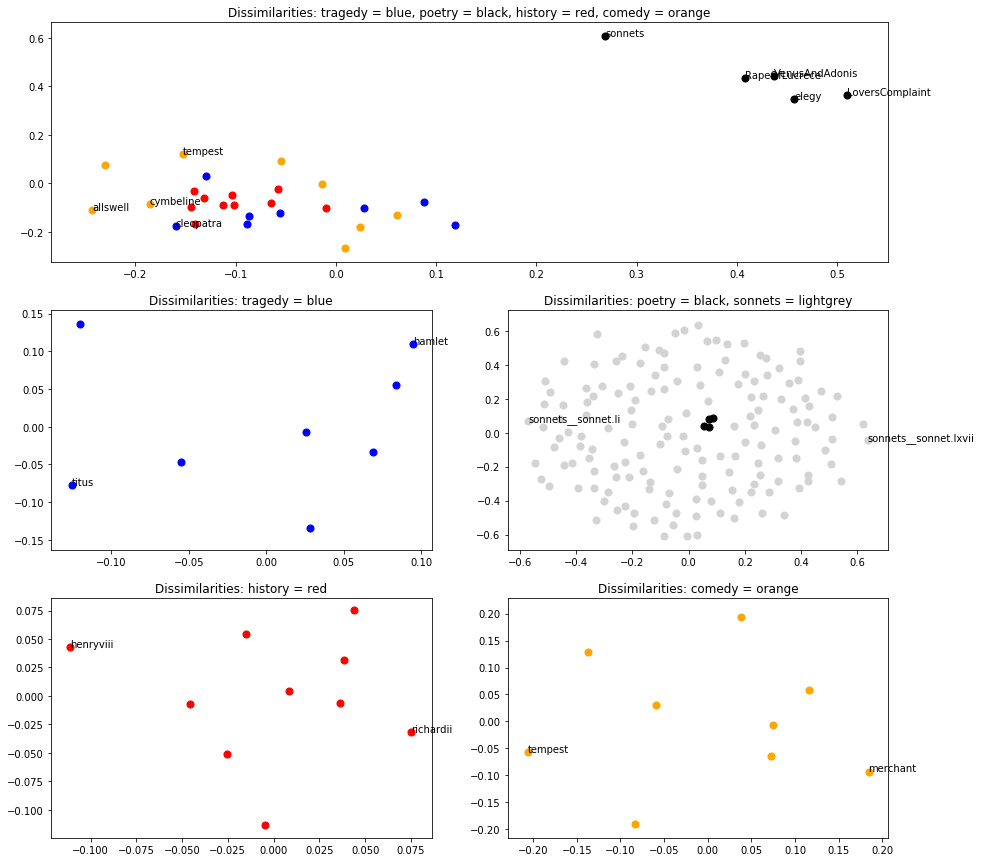

In [243]:
plt.show()

* As can be seen above, in the first plot, the poetry cluster points are plotted on the far right top denoted by black color with others like tragedy in blue, history in red and comedy in orange all plotted at the same area near each other because of the similarity between them.
* The third plot is of the poetry and sonnets, with sonnets being plotted in light grey and poetry in black centred in the plot. 

### Next on, along with the giving individual colors to the plays across all genres, lets try to find outliers amongst each of the genres and print them.

-------
Tragedy Outliers:
cleopatra__cleopatra.3.3
-------
Tragedy Outliers:
macbeth__macbeth.3.3
-------
Poetry Outliers:
sonnets
-------
Poetry Outliers:
VenusAndAdonis
-------
History Outliers:
henryv__henryv.3.4
-------
History Outliers:
henryv__henryv.4.5
-------
Comedy Outliers:
cymbeline__cymbeline.1.2
-------
Comedy Outliers:
lll__lll.1.2


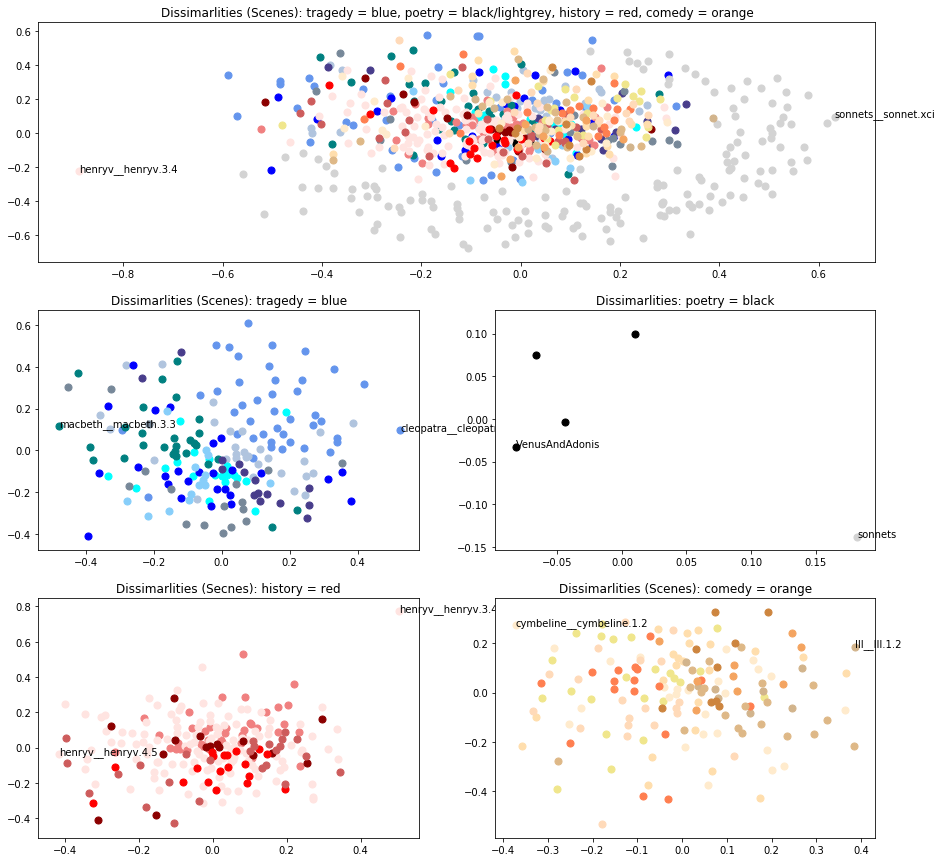

In [244]:
def get_the_color(name):
     # tragedies
    if "tragedy" in name: color = 'blue'
    
    if "titus" in name: color = 'lightskyblue'
    if "timon" in name: color = 'lightslategrey'
    if "romeo" in name: color = 'mediumblue'
    if "othello" in name: color = 'darkslateblue'
    if "macbeth" in name: color = 'teal'    
    if "lear" in name: color = 'b'   
    if "caesar" in name: color = 'aliceblue'  
    if "hamlet" in name: color = 'cyan' 
    if "coriolanus" in name: color = 'lightsteelblue'
    if "cleopatra" in name: color = 'cornflowerblue'
        
    # poetry
    if "poetry" in name: color = 'black' 
        
    if "sonnet" in name: color = 'lightgrey'
    
    # histories
    if "history" in name: color = 'red'  
    if "richardiii" in name: color = 'tomato'
    if "richardiii" in name: color = 'indianred'
    if "john" in name: color = 'darkred'
    if "henryviii" in name: color = 'salmon'
    if "henryvi" in name: color = 'orangered'
    if "henryv" in name: color = 'mistyrose'
    if "henryiv" in name: color = 'lightcoral'
        
    # comedies
    if "comedy" in name: color = 'orange'
    
    if "winters" in name: color = 'goldenrod'
    if "gentelmen" in name: color = 'darkorange'
    if "twelfth" in name: color = 'wheat'
    if "cressida" in name: color = 'bisque'
    if "tempest" in name: color = 'sandybrown'  
    if "shrew" in name: color = 'gold' 
    if "pericles" in name: color = 'peachpuff' 
    if "ado" in name: color = 'darkgoldenrod' 
    if "midsummer" in name: color = 'peru' 
    if "merchant" in name: color = 'burlywood' 
    if "merry" in name: color = 'moccasin' 
    if "measure" in name: color = 'coral' 
    if "lll" in name: color = 'tan' 
    if "cymbeline" in name: color = 'blanchedalmond' 
    if "errors" in name: color = 'orange' 
    if "asyoulikeit" in name: color = 'navajowhite' 
    if "allswell" in name: color = 'khaki' 
    
    return color

#--------------------------------------------------------------------------------

# Plot ALL (exclude the sonnets (too short))
gs = gridspec.GridSpec(3,2)
filenames = get_file_names('tragedy__', 4)
filenames.extend(get_file_names('poetry__', 2))
filenames.extend(get_file_names('poetry__', 4))
filenames.extend(get_file_names('history__', 4))
filenames.extend(get_file_names('comedy__', 4))
dist = compute_dissimilarity(filenames)
pos = mds.fit_transform(dist) 
xs, ys = pos[:, 0], pos[:, 1]
names = [fn.replace('.txt', '') for fn in filenames]

plt.figure(figsize=(15,15))
ax = plt.subplot(gs[0,:])
ax.set_title('Dissimarlities (Scenes): tragedy = blue, poetry = black/lightgrey, history = red, comedy = orange')
for x, y, name in zip(xs, ys, names):
    color = get_the_color(name)
    plt.scatter(x, y, color=color, s=50)
    if x == xs.min() or x == xs.max(): 
        plt.text(x, y, name[name.find('_')+2:])
        
#--------------------------------------------------------------------------------

# Plot TRAGEDIES
filenames = get_file_names('tragedy__', 4)
dist = compute_dissimilarity(filenames)
pos = mds.fit_transform(dist) 
xs, ys = pos[:, 0], pos[:, 1]
names = [fn.replace('.txt', '') for fn in filenames]
ax = plt.subplot(gs[1,0])
ax.set_title('Dissimarlities (Scenes): tragedy = blue')
for x, y, name in zip(xs, ys, names):
    color = get_the_color(name)
    plt.scatter(x, y, color=color, s=50)
    if x == xs.min() or x == xs.max():
        print("-------")
        print("Tragedy Outliers:")
        print(name[name.find('_')+2:])
        plt.text(x, y, name[name.find('_')+2:])
    
#--------------------------------------------------------------------------------

# Plot POETRY
filenames = get_file_names('poetry__', 2)
#filenames.extend(get_file_names('poetry__', 4))
dist = compute_dissimilarity(filenames)
pos = mds.fit_transform(dist) 
xs, ys = pos[:, 0], pos[:, 1]
names = [fn.replace('.txt', '') for fn in filenames]
ax = plt.subplot(gs[1,1])
ax.set_title('Dissimarlities: poetry = black')
for x, y, name in zip(xs, ys, names):
    color = get_the_color(name)
    plt.scatter(x, y, color=color, s=50)
    if x == xs.min() or x == xs.max():
        print("-------")
        print("Poetry Outliers:")
        print(name[name.find('_')+2:])
        plt.text(x, y, name[name.find('_')+2:])

#--------------------------------------------------------------------------------

# Plot HISTORIES
filenames = get_file_names('history__', 4)
dist = compute_dissimilarity(filenames)
pos = mds.fit_transform(dist) 
xs, ys = pos[:, 0], pos[:, 1]
names = [fn.replace('.txt', '') for fn in filenames]
ax = plt.subplot(gs[2,0])
ax.set_title('Dissimarlities (Secnes): history = red')
for x, y, name in zip(xs, ys, names):  
    color = get_the_color(name)
    plt.scatter(x, y, color=color, s=50)
    if x == xs.min() or x == xs.max(): 
        plt.text(x, y, name[name.find('_')+2:])
        print("-------")
        print("History Outliers:")
        print(name[name.find('_')+2:])
    
#--------------------------------------------------------------------------------

# Plot COMEDIES
filenames = get_file_names('comedy__', 4)
dist = compute_dissimilarity(filenames)
pos = mds.fit_transform(dist) 
xs, ys = pos[:, 0], pos[:, 1]
names = [fn.replace('.txt', '') for fn in filenames]
ax = plt.subplot(gs[2,1])
ax.set_title('Dissimarlities (Scenes): comedy = orange')
for x, y, name in zip(xs, ys, names):
    color = get_the_color(name)
    plt.scatter(x, y, color=color, s=50)
    if x == xs.min() or x == xs.max(): 
        plt.text(x, y, name[name.find('_')+2:])
        print("-------")
        print("Comedy Outliers:")
        print(name[name.find('_')+2:])
        
plt.show()

<a id='k-means'></a>


## 5.2 K-means Clustering 

In [245]:
# Next on, we will  cluster all the words using k-means for k=20 and print all the words and clusters for VenusAndAdonis text

In [246]:
file = 'poetry__VenusAndAdonis.txt'
num_clusters = 20
wordcount = create_wordcount_dict(file, True, False)
tfidf_vectorizer = get_tfidf_vectorizer()
words = [word for word in wordcount.keys()]
tfidf_matrix = get_tfidf_matrix(tfidf_vectorizer, words)
km = get_kmeans(tfidf_matrix, num_clusters)
km_labels = get_kmeans_clusters(km)
vocab_cluster = { 'word': words, 'cluster': km_labels}
vocab_frame = pd.DataFrame(vocab_cluster, index = [km_labels] , columns = ['word', 'cluster'])
print_clusters(num_clusters, vocab_frame)



Cluster 1 words: ., ,, venus, and, adonis, vilia, miretur, vulgus, mihi, flavus, apollo, pocula, castalia, plena, ministret, aqua, to, the, right, honorable, henry, wriothesly, earl, of, southampton, baron, tichfield, i, know, not, how, shall, offend, in, dedicating, my, unpolished, lines, your, lordship, nor, world, will, censure, me, for, choosing, so, strong, a, prop, support, weak, burden, only, if, honour, seem, but, pleased, account, myself, highly, praised, vow, take, advantage, all, idle, hours, till, have, honoured, you, with, some, graver, labour, first, heir, invention, prove, deformed, be, sorry, it, had, noble, god-father, never, after, ear, barren, land, yield, still, bad, harvest, leave, honourable, survey, which, wish, may, always, answer, own, hopeful, expectation, duty, william, shakespeare, even, as, sun, face, ta'en, his, last, weeping, morn, hied, him, chase, he, sick-thoughted, makes, amain, unto, bold-faced, suitor, gins, thrice-fairer, than, thus, she, began, 

/Users/rkheruwa/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


 hotly, overlook, team, guide, side, lazy, spright, dark, disliking, louring, brows, o'erwhelming, misty, vapours, blot, souring, cries, fie, ay, quoth, young, unkind, bare, excuses, makest, sigh, celestial, breath, gentle, wind, cool, descending, too, shines, heaven, warm, lo, between, thence, harm, darts, forth, burneth, done, earthly, obdurate, flinty, hard, nay, flint, stone, relenteth, son, feel, want, tormenteth, mother, borne, mind, brought, am, contemn, great, danger, dwells, suit, worse, poor, speak, words, else, mute, interest, lifeless, picture, senseless, well-painted, idol, image, dun, statue, alone, thing, woman, complexion, men, direction, said, impatience, chokes, pleading, tongue, swelling, provoke, fiery, blaze, wrong, judge, cause, weeps, fain, sobs, intendments, break, sometimes, shakes, gazeth, infold, band, locks, lily, fingers, fondling, circuit, ivory, park, deer, mountain, dale, graze, hills, stray, lower, pleasant, fountains, limit, relief, enough, bottom-gras

 babe, dire, follow, expel, reviving, rejoice, flatters, pearls, glass, orient, drop, beside, pass, wash, sluttish, hard-believing, believe, credulous, weal, extremes, ridiculous, flatter, unlikely, kills, unweaves, web, wrought, all-to, naught, adds, honours, clepes, king, graves, kings, imperious, supreme, pardon, met, bloody, severe, shadow,--truth, confess, decease, provoked, commander, creature, act, author, slander, rule, hoping, rash, suspect, extenuate, humbly, insinuate, trophies, statues, tombs, victories, triumphs, glories, jove, wail, mutual, overthrow, chaos, fond, laden, trifles, unwitnessed, bethinking, grieves, merry, falcon, lure, stoops, unfortunately, conquest, stars, withdrew, snail, horns, shrinks, shelly, cave, pain, shade, creep, cabins, resign, office, disposing, consort, perplexed, throne, suggestion, quakes, foundation, terror, minds, confound, beds, leap, threw, flank, wonted, purple, wept, herb, stole, solemn, sympathy, noteth, shoulder, dumbly, franticly, d

In [247]:
file = 'poetry__VenusAndAdonis.txt'
with open(file, 'r') as f:
    text = f.read()
    f.close()

#def package_stats(file):
    for i, x in enumerate(stats.file_stats(file)):
        print(i,x)
        wordcount = create_wordcount_dict(file, True, False)
        for i, x in enumerate(get_feature_words(wordcount)):
            print(i, np.array(x)[0])
    for i, x in enumerate(count_paragraphs(file)): 
        print(i, np.array(x)[0])

0 ['Lines' 'Blank Lines' 'Sentences' 'Words' 'Letters' 'Punctuation']
0 Stops
1 8676
1 [1625, 408, 305, 9870, 41946, 2384]
0 Stops
1 8676
0 Paragraphs
1 203


In [248]:
file = 'poetry__VenusAndAdonis.txt'
num_clusters = 20
wordcount = create_wordcount_dict(file, True, False)
tfidf_vectorizer = get_tfidf_vectorizer()
words = [word for word in wordcount.keys()]
tfidf_matrix = get_tfidf_matrix(tfidf_vectorizer, words)
km = get_kmeans(tfidf_matrix, num_clusters)
km_labels = get_kmeans_clusters(km)
vocab_cluster = { 'word': words, 'cluster': km_labels}
vocab_frame = pd.DataFrame(vocab_cluster, index = [km_labels] , columns = ['word', 'cluster'])
print_clusters(num_clusters, vocab_frame)



Cluster 1 words: ., ,, venus, and, adonis, vilia, miretur, vulgus, mihi, flavus, apollo, pocula, castalia, plena, ministret, aqua, to, the, right, honorable, henry, wriothesly, earl, of, southampton, baron, tichfield, i, know, not, how, shall, offend, in, dedicating, my, unpolished, lines, your, lordship, nor, world, will, censure, me, for, choosing, so, strong, a, prop, support, weak, burden, only, if, seem, but, pleased, account, myself, highly, praised, vow, take, advantage, all, idle, hours, till, have, you, with, some, graver, labour, first, heir, invention, prove, deformed, be, sorry, it, had, noble, god-father, never, after, barren, land, yield, still, bad, harvest, leave, survey, content, which, wish, may, always, answer, own, hopeful, expectation, duty, william, shakespeare, even, as, sun, face, ta'en, his, last, weeping, morn, hied, him, chase, he, sick-thoughted, amain, unto, bold-faced, suitor, gins, woo, thrice-fairer, than, thus, she, began, chief, flower, sweet, above,

/Users/rkheruwa/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


 breed, dead, spite, death, survive, alive, love-sick, queen, sweat, lay, titan, tired, mid-day, eye, hotly, overlook, team, guide, side, lazy, spright, dark, disliking, louring, brows, o'erwhelming, misty, vapours, blot, souring, cries, fie, ay, quoth, young, unkind, bare, excuses, makest, sigh, celestial, breath, gentle, wind, cool, descending, too, shines, heaven, warm, lo, between, thence, harm, darts, forth, burneth, done, earthly, obdurate, flinty, hard, nay, flint, stone, relenteth, son, want, tormenteth, mother, borne, mind, brought, am, contemn, great, danger, dwells, suit, worse, poor, speak, words, else, mute, interest, lifeless, picture, senseless, well-painted, idol, image, dun, statue, contenting, alone, thing, woman, complexion, men, direction, said, impatience, chokes, pleading, tongue, swelling, provoke, fiery, blaze, wrong, judge, cause, weeps, fain, sobs, intendments, break, sometimes, shakes, gazeth, infold, band, struggles, locks, lily, fingers, fondling, circuit, 

 sound, deceiving, harmony, quiet, closure, quite, undone, bedchamber, lady, longs, groan, soundly, sleeps, urged, reprove, path, leadeth, device, lends, stranger, strange, bawd, fled, semblance, blotting, blame, tyrant, stains, bereaves, caterpillars, leaves, comforteth, sunshine, effect, remain, winter, summer, half, truth, forged, text, old, orator, sadness, teen, attended, offended, homeward, laund, apace, deeply, star, shooteth, glides, shore, gazing, late-embarked, waves, ridges, meeting, contend, merciless, pitchy, unaware, jewel, flood, night-wanderers, often, mistrustful, confounded, discovery, neighbour, troubled, verbal, repetition, moans, redoubled, times, echoes, marking, wailing, extemporally, woeful, ditty, thrall, dote, wise, folly, foolish-witty, anthem, concludes, choir, song, tedious, outwore, such-like, circumstance, suchlike, copious, stories, oftentimes, without, audience, withal, sounds, resembling, parasites, shrill-tongued, tapsters, answering, soothing, humour

/Users/rkheruwa/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
/Users/rkheruwa/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
/Users/rkheruwa/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_s

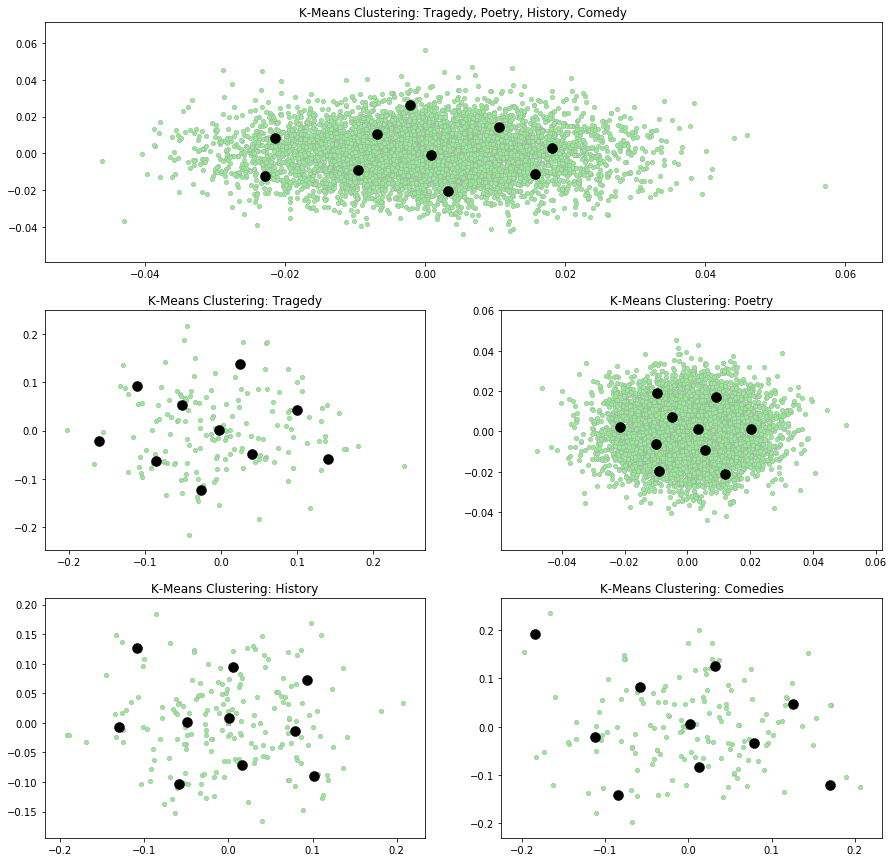

In [249]:
#--------------------------------------------------------------------------------

def clustering_from_files(filenames, num_clusters):
                               
    vectorizer = CountVectorizer(input='filename')               
    dtm = vectorizer.fit_transform(filenames) 
    vocab = vectorizer.get_feature_names()                             
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.7,
                                 stop_words='english')
    
    to_reduce = vectorizer.fit_transform(vocab)

    km = MiniBatchKMeans(n_clusters=num_clusters, init='k-means++', n_init=1,
                         init_size=1000,
                         batch_size=1000, verbose=0)

    return (km, to_reduce)

#--------------------------------------------------------------------------------

def plot(kmeans,reduced_data):
    kmeans.fit(reduced_data)
    h = 0.1
    x_min, x_max = reduced_data[:, 0].min() + 1, reduced_data[:, 0].max() - 1
    y_min, y_max = reduced_data[:, 1].min() + 1, reduced_data[:, 1].max() - 1
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='o', s=20, linewidths=0.5,
               color='lightgreen', edgecolors='darkgrey')
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
               marker='o', s=100, linewidths=0.5,
               color='black', zorder=10)
    #plt.xlim(x_min, x_max)
    #plt.ylim(y_min, y_max)
    #plt.xticks(())
    #plt.yticks(())

#--------------------------------------------------------------------------------

def reduce_two_dim(train):
    rpca=RandomizedPCA(n_components=2)
    return rpca.fit_transform(train)    

#--------------------------------------------------------------------------------

# 1 x large graph for all 
# and then 1 x each for all tragedies, histories, comedies and poems 
gs = gridspec.GridSpec(3,2)
plt.figure(figsize=(15,15))

#--------------------------------------------------------------------------------

num_clusters = 10
filenames = get_file_names('tragedy__', 2)
filenames.extend(get_file_names('poetry__', 2))
filenames.extend(get_file_names('history__', 2))
filenames.extend(get_file_names('comedy__', 2))
k_means, to_reduce = clustering_from_files(filenames, num_clusters)
reduced = reduce_two_dim(to_reduce.toarray())
ax = plt.subplot(gs[0,:])
plot(k_means,reduced)
ax.set_title('K-Means Clustering: Tragedy, Poetry, History, Comedy')

#--------------------------------------------------------------------------------

# Plot TRAGEDIES
filenames = get_file_names('tragedy__', 2)
ax = plt.subplot(gs[1,0])
k_means, to_reduce = clustering_from_files(filenames, num_clusters)
reduced = reduce_two_dim(to_reduce.toarray())
plot(k_means,reduced)
ax.set_title('K-Means Clustering: Tragedy')
    
#--------------------------------------------------------------------------------

# Plot POETRY
filenames = get_file_names('poetry__', 2)
filenames.extend(get_file_names('poetry__', 4))
ax = plt.subplot(gs[1,1])
k_means, to_reduce = clustering_from_files(filenames, num_clusters)
reduced = reduce_two_dim(to_reduce.toarray())
plot(k_means,reduced)
ax.set_title('K-Means Clustering: Poetry')

#--------------------------------------------------------------------------------

# Plot HISTORIES
filenames = get_file_names('history__', 2)
ax = plt.subplot(gs[2,0])
k_means, to_reduce = clustering_from_files(filenames, num_clusters)
reduced = reduce_two_dim(to_reduce.toarray())
plot(k_means,reduced)
ax.set_title('K-Means Clustering: History')
    
#--------------------------------------------------------------------------------

# Plot COMEDIES
filenames = get_file_names('comedy__', 2)
ax = plt.subplot(gs[2,1])
k_means, to_reduce = clustering_from_files(filenames, num_clusters)
reduced = reduce_two_dim(to_reduce.toarray())
plot(k_means,reduced)
ax.set_title('K-Means Clustering: Comedies')

plt.show()

* Above, we have plots of k-means clustering with k = 10 for all of the tragedy, comedy, poetry, history combined and individual genre plots too.
* We can see k=10 points in the form of black cluster points for all of them and the data points in general. 

/Users/rkheruwa/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
/Users/rkheruwa/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
/Users/rkheruwa/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_s

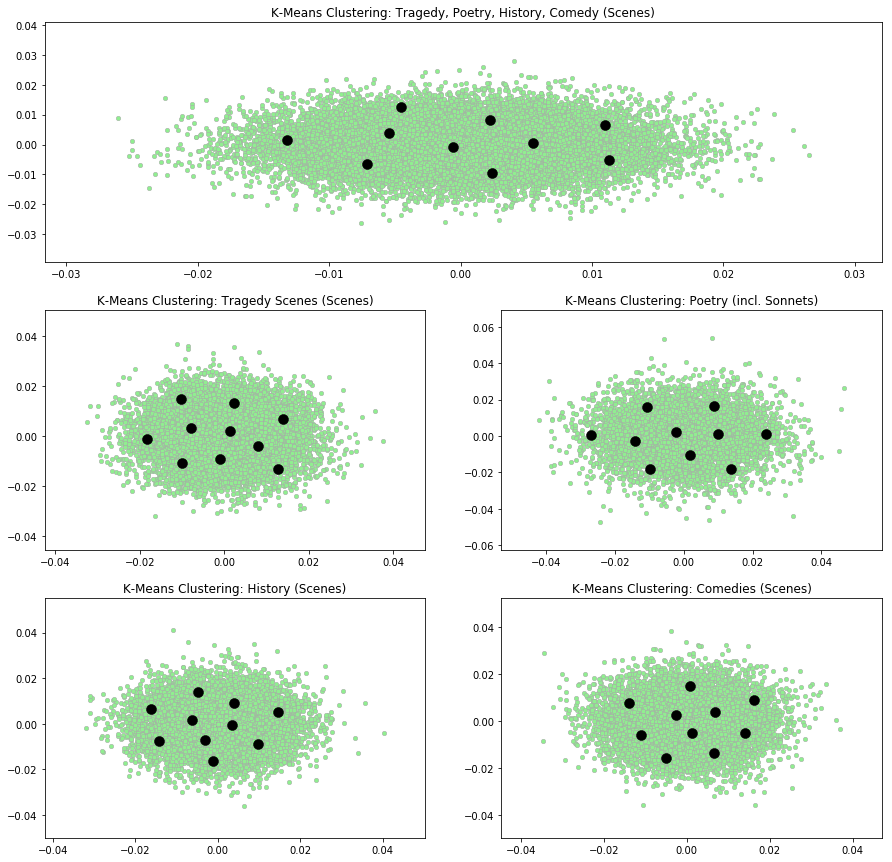

In [250]:
# 1 x large graph for all 
# and then 1 x each for all tragedies, histories, comedies and poems 
gs = gridspec.GridSpec(3,2)
plt.figure(figsize=(15,15))

#--------------------------------------------------------------------------------

num_clusters = 10
filenames = get_file_names('tragedy__', 4)
filenames.extend(get_file_names('poetry__', 2))
filenames.extend(get_file_names('poetry__', 4))
filenames.extend(get_file_names('history__', 4))
filenames.extend(get_file_names('comedy__', 4))
k_means, to_reduce = clustering_from_files(filenames, num_clusters)
reduced = reduce_two_dim(to_reduce.toarray())
ax = plt.subplot(gs[0,:])
plot(k_means,reduced)
ax.set_title('K-Means Clustering: Tragedy, Poetry, History, Comedy (Scenes)')


#--------------------------------------------------------------------------------

# Plot TRAGEDIES
filenames = get_file_names('tragedy__', 4)
ax = plt.subplot(gs[1,0])
k_means, to_reduce = clustering_from_files(filenames, num_clusters)
reduced = reduce_two_dim(to_reduce.toarray())
plot(k_means,reduced)
ax.set_title('K-Means Clustering: Tragedy Scenes (Scenes)')
    
#--------------------------------------------------------------------------------

# Plot POETRY
filenames = get_file_names('poetry__', 2)
filenames.extend(get_file_names('poetry__', 4))
ax = plt.subplot(gs[1,1])
k_means, to_reduce = clustering_from_files(filenames, num_clusters)
reduced = reduce_two_dim(to_reduce.toarray())
plot(k_means,reduced)
ax.set_title('K-Means Clustering: Poetry (incl. Sonnets)')

#--------------------------------------------------------------------------------

# Plot HISTORIES
filenames = get_file_names('history__', 4)
ax = plt.subplot(gs[2,0])
k_means, to_reduce = clustering_from_files(filenames, num_clusters)
reduced = reduce_two_dim(to_reduce.toarray())
plot(k_means,reduced)
ax.set_title('K-Means Clustering: History (Scenes)')

    
#--------------------------------------------------------------------------------

# Plot COMEDIES
filenames = get_file_names('comedy__', 4)
ax = plt.subplot(gs[2,1])
k_means, to_reduce = clustering_from_files(filenames, num_clusters)
reduced = reduce_two_dim(to_reduce.toarray())
plot(k_means,reduced)
ax.set_title('K-Means Clustering: Comedies (Scenes)')

plt.show()

<a id='Dendrogram'></a>


## 5.3 Hierarchical Clustering Dendrogram

### Let's have Hierarchical Clustering Dendrogram to have a view at the genres. 


* As one can see, the cluster which has all under poetry is distant away from the other cluster which has all the other remaining genres.

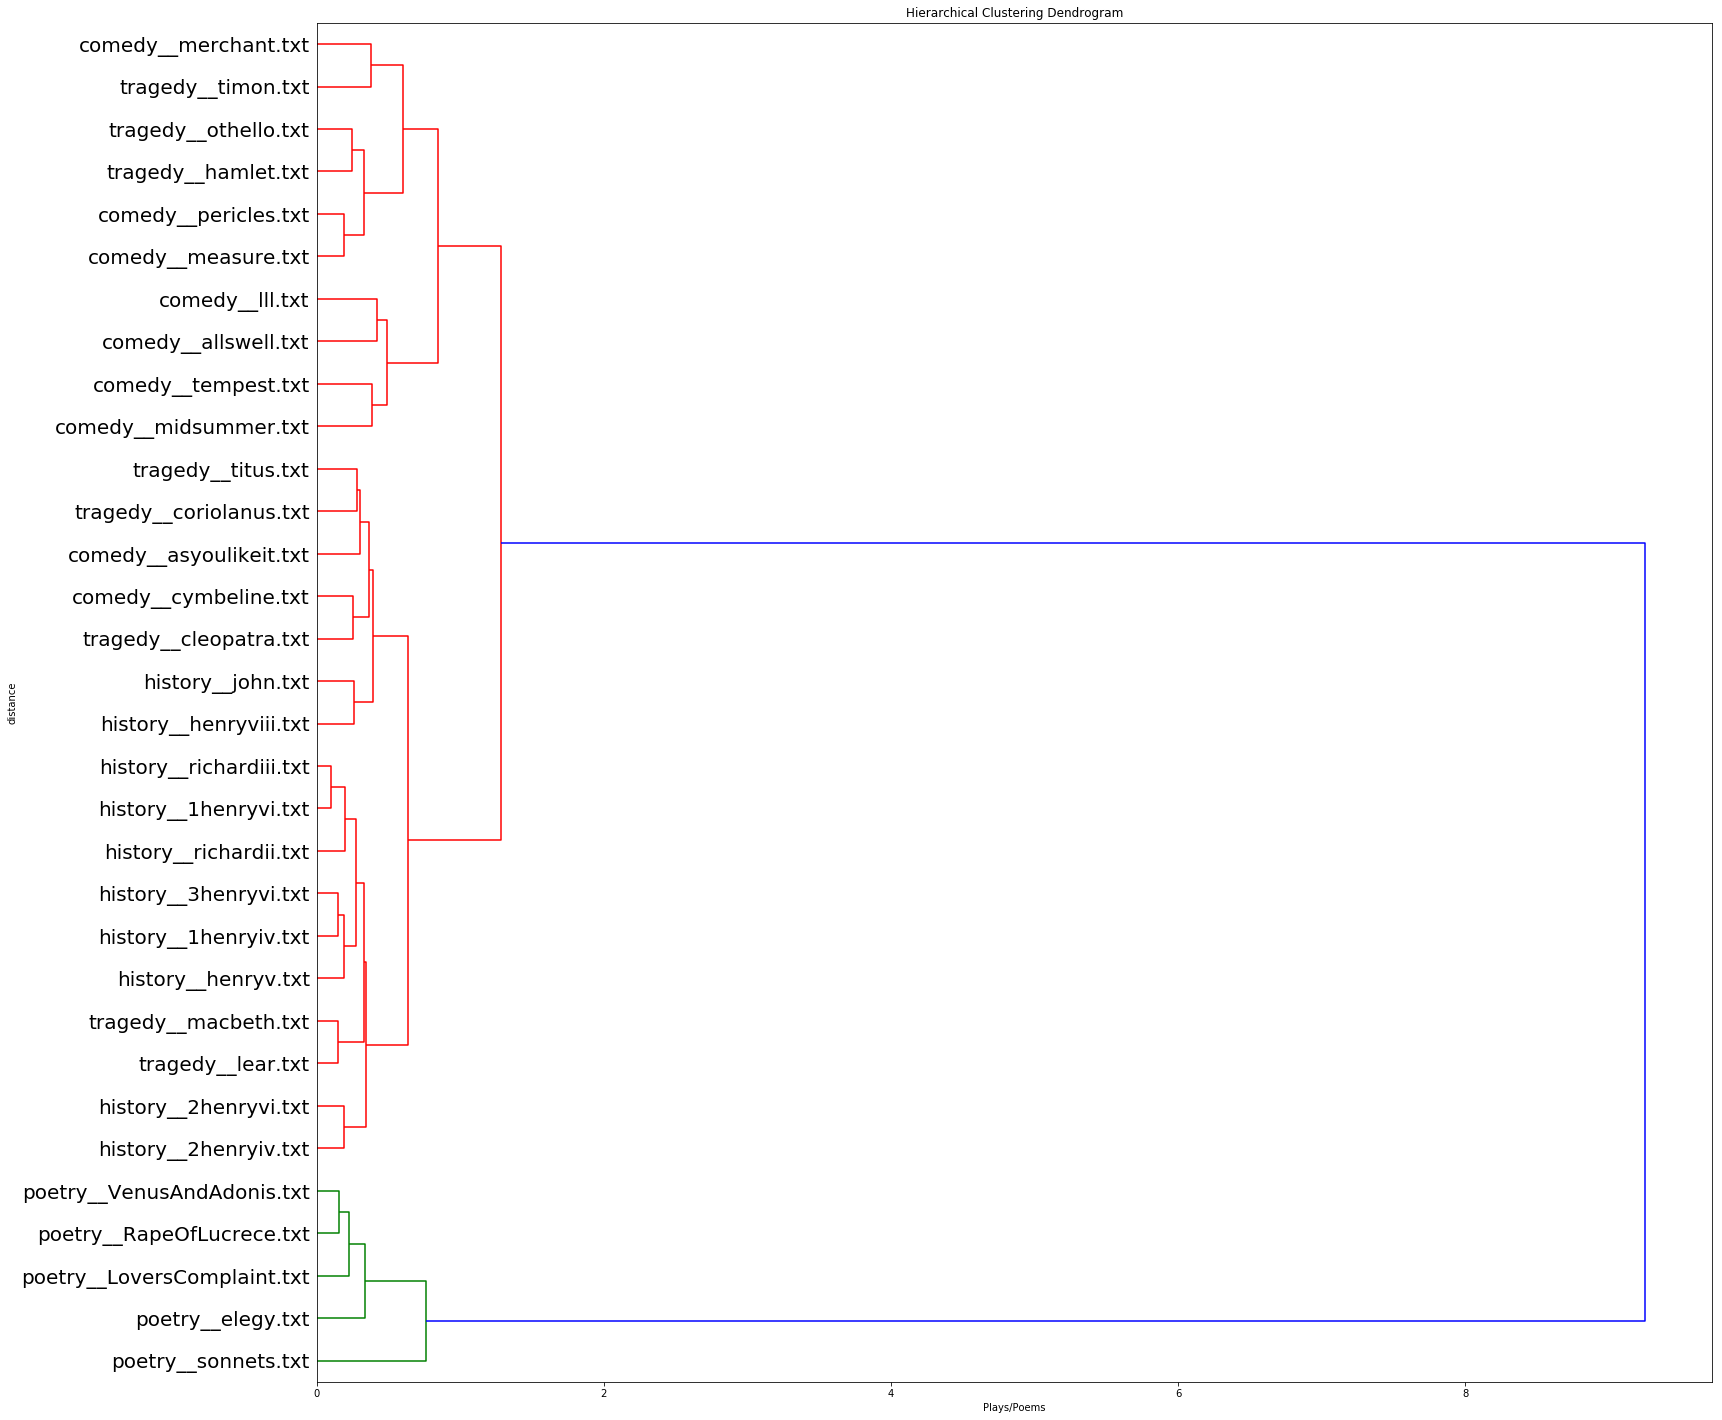

In [251]:
# Plot ALL (exclude the sonnets (too short))
filenames = get_file_names('tragedy__', 2)
filenames.extend(get_file_names('poetry__', 2))
filenames.extend(get_file_names('history__', 2))
filenames.extend(get_file_names('comedy__', 2))
dist = compute_dissimilarity(filenames)

linkage_matrix = ward(dist)
# calculate full dendrogram
plt.figure(figsize=(25, 25))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Plays/Poems')
plt.ylabel('distance')
dendrogram(
    linkage_matrix,
    p=20,
    leaf_font_size=20.,
    orientation="right",
    labels=filenames
)
plt.show()

* As a whole, it has two primary clusters where one cluster has Poetry genre and the other one has all of the other genres combined which actually makes sense as the poetry is written in a very different way than other genres.
* Furthermore, the comedy and tragedy genres are overlapping and are near to each other for most of them while history genre is little away from and in its own cluster. 